## Notebook to inspect fitted models & create A contribution gif

In [55]:
%matplotlib notebook
import os
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import random
from ShapePipe.shapepipe.pipeline import file_io
from astropy.io import fits
import glob
import shutil
import galsim.hsm as hsm
from galsim import Image
import IPython.display as Ipd
import subprocess

In [56]:
# Nicely plot psf images in pixel and log domains
def plot_img(img, title_str = 'Def title'):
    # Define the color map to be used
    top = mpl.cm.get_cmap('Oranges_r', 128)
    bottom = mpl.cm.get_cmap('Blues', 128)
    newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                           bottom(np.linspace(0, 1, 128))))
    newcmp = ListedColormap(newcolors, name='OrangeBlue')

    # Plot the images
    my_data = img
    my_log_data = np.log(abs(my_data))
    
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    fig.suptitle(title_str)
    
    vmax1 = np.max([abs(np.max(my_data)), abs(np.min(my_data))])
    im = ax[0].imshow(my_data, cmap=newcmp, vmin=-vmax1, vmax=vmax1)
    ax[0].set_title('Pixel space')
    cbar = fig.colorbar(im, ax=ax[0], extend='both')
    cbar.minorticks_on()

    vmin1_log = np.max([abs(np.max(my_log_data)), abs(np.min(my_log_data))])
    if np.max(my_log_data) > 0:
        vmax1_log = np.max(my_log_data)
    else:
        vmax1_log = 0
    im2 = ax[1].imshow(my_log_data, cmap=newcmp, vmin=-vmin1_log, vmax=vmax1_log)
    ax[1].set_title('Log space')
    cbar = fig.colorbar(im2, ax=ax[1], extend='both')
    cbar.minorticks_on()

    plt.show()
    
    
# Define the color map to be used
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')    

## _New_ GIF creation routine

In [57]:
# Gif creation routine
def create_gif(data_matrix, dataset_fits_file, order_vec = None, gif_name = 'my_gif.gif'):

    x_pos = dataset_fits_file[2].data['XWIN_IMAGE']
    y_pos = dataset_fits_file[2].data['YWIN_IMAGE']

    #vmax1_A = np.max(data_A[1:,:])
    #vmin1_A = np.min(data_A[1:,:])
    vmax1_A = np.max([abs(np.max(data_matrix[1:,:])), abs(np.min(data_matrix[1:,:]))])

    tmp_folder_name = 'tmp_gif'

    # Create a temporary image folder
    try: 
        os.mkdir(tmp_folder_name)
        cwd_path = os.getcwd()
        os.chdir(cwd_path + '/' + tmp_folder_name)
    except:
        cwd_path = os.getcwd()
        os.chdir(cwd_path + '/' + tmp_folder_name)

    
    for it in range(data_matrix.shape[0]):
        if order_vec is None:
            ai = data_matrix[it,:]
        else:
            ai = data_matrix[order_vec[it],:]
            
        fig = plt.figure(figsize=(8,5))
        ax = plt.gca()
        ax.set_facecolor((167/256, 201/256, 223/256)) # Blue ugly color with good contrast
        im = plt.scatter(x_pos, y_pos, c=abs(ai), cmap='hot', vmin=0, vmax=vmax1_A*0.75)
        fig.set()
        cbar = plt.colorbar(im, extend='both')
        cbar.minorticks_on()
        plt.title('eigenPSF n%d'%(it))
        plt.savefig('eigenPSF_%d.png'%(it))
        plt.show()
        plt.close()

    try:
        subprocess.call('convert -delay 60 -loop 0 *png ' + gif_name, shell=True) # create the gif
        shutil.copy2(os.getcwd() + '/' + gif_name,'..') # copy the gif image
    except:
        os.chdir('..')

    os.chdir('..')
    shutil.rmtree(tmp_folder_name)   # Remove the temporary folder

def show_gif(gif_rel_path):
    with open(gif_rel_path,'rb') as f:
        display(Ipd.Image(data=f.read(), format='png'))

In [58]:
# Create a superGIF
def create_superGIF(data_matrix,data_vector, dataset_fits_file, order_vec, gif_name = 'my_gif.gif'):

    s_imgs = data_vector
    
    sort_idxs = order_vec 
    sort_idxs_noMax = order_vec[1:] # Do not include the max eigenPSF

    tmp_folder_name = 'tmp_super_gif'

    # Create a temporary image folder
    try: 
        os.mkdir(tmp_folder_name)
        cwd_path = os.getcwd()
        os.chdir(cwd_path + '/' + tmp_folder_name)
    except:
        cwd_path = os.getcwd()
        os.chdir(cwd_path + '/' + tmp_folder_name)

        
    for it in range(data_matrix.shape[0]):
        
        ai = data_matrix[sort_idxs[it],:]    
        
        figs2, axs2 = plt.subplots(1,2,figsize=(10,5),gridspec_kw={'width_ratios': [2, 3]})
    
        if it == 0:
            axs2[0].plot(s_imgs[sort_idxs], marker='o', markersize=3, label='S')
            axs2[0].plot(it,s_imgs[sort_idxs[it]], marker='o',markerfacecolor='r', markersize=8, label='selec S')
            axs2[0].set_title('Ordered eigenPSFs energy\n With mean PSF')
        else:
            axs2[0].plot(s_imgs[sort_idxs_noMax], marker='o', markersize=3, label='S')
            axs2[0].plot(it-1,s_imgs[sort_idxs_noMax[it-1]], marker='o',markerfacecolor='r', markersize=8, label='selec S')
            axs2[0].set_title('Ordered eigenPSFs energy\n Without mean PSF')
        

        x_pos = dataset_fits_file[2].data['XWIN_IMAGE']
        y_pos = dataset_fits_file[2].data['YWIN_IMAGE']
        vmax1_A = np.max([abs(np.max(data_matrix[1:,:])), abs(np.min(data_matrix[1:,:]))])

        axs2[1].set_facecolor((167/256, 201/256, 223/256)) # Blue ugly color with good contrast
        im = axs2[1].scatter(x_pos, y_pos, c=abs(ai), cmap='hot', vmin=0, vmax=vmax1_A*0.75)
        #fig.set()
        cbar = plt.colorbar(im, extend='both')
        cbar.minorticks_on()
        plt.title('eigenPSF n%d'%(it))
        
        plt.show()
        plt.savefig('eigenPSF_%02d.png'%(it))
        plt.close()
    

    try:
        subprocess.call('convert -delay 80 -loop 0 *png ' + gif_name, shell=True) # create the gif
        shutil.copy2(os.getcwd() + '/' + gif_name,'..') # copy the gif image
    except:
        os.chdir('..')

    os.chdir('..')
    shutil.rmtree(tmp_folder_name)   # Remove the temporary folder

In [59]:
# Analyze fitted model
def inspect_fit_model(file_path,dataset_path,test_n,catalog_n):
    
    # Parameters
    k = catalog_n
    
    # Import the model
    model = np.load(file_path,allow_pickle=True)

    dataset = fits.open(dataset_path)

    print('Model keys():')
    print(model[0].keys())
    print(model[1].keys())

    print('\n dataset keys():')
    print(dataset[2].columns)

    # Extract the data
    data_A = model[1]['A']
    vmax1_A = np.max([abs(np.max(data_A)), abs(np.min(data_A))])
    data_S = model[1]['S']
    vmax1_S = np.max([abs(np.max(data_S)), abs(np.min(data_S))])
    data_alpha = model[1]['alpha']
    vmax1_alpha = np.max([abs(np.max(data_alpha)), abs(np.min(data_alpha))])
    data_VT = model[1]['VT']
    vmax1_VT = np.max([abs(np.max(data_VT)), abs(np.min(data_VT))])

    #-----#
    
    # Plot the A and VT matrices
    figs, axs = plt.subplots(1,3,figsize=(10,5))

    im_0 = axs[0].imshow(data_A.T, cmap=newcmp, vmin=-vmax1_A, vmax=vmax1_A)
    axs[0].set_title('A.T')
    #plt.colorbar(im_0, ax = axs[0])
    cbar = figs.colorbar(im_0, ax=axs[0], extend='both')
    cbar.minorticks_on()

    im_1 = axs[1].imshow(data_VT, cmap=newcmp, vmin=-vmax1_VT, vmax=vmax1_VT)
    axs[1].set_title('VT')
    #plt.colorbar(im_1, ax = axs[1])
    cbar = figs.colorbar(im_1, ax=axs[1], extend='both')
    cbar.minorticks_on()

    im_2 = axs[2].imshow(data_alpha.T, cmap=newcmp, vmin=-vmax1_alpha, vmax=vmax1_alpha)
    axs[2].set_title('alpha.T')
    #plt.colorbar(im_1, ax = axs[1])
    cbar = figs.colorbar(im_2, ax=axs[2], extend='both')
    cbar.minorticks_on()
    plt.savefig('A_VT_alpha_test%d-cat_%d.png'%(test_n,k))

    # Plot the norm of S and H lines
    # a_lines = np.array([np.sqrt(np.sum(data_A[k,:]**2)) for k in range(data_A.shape[0])])
    s_imgs = np.array([np.sqrt(np.sum(data_S[:,:,k]**2)) for k in range(data_S.shape[2])])
    data_H = data_S @ data_A
    h_imgs = np.array([np.sqrt(np.sum(data_H[:,:,k]**2)) for k in range(data_H.shape[2])])

    sort_idxs = np.flip(np.argsort(s_imgs).astype(int)[:-1]) # Do not include the max eigenPSF

    figs2, axs2 = plt.subplots(1,2,figsize=(10,5))
    figs2.suptitle('test N%d, cat N%d'%(test_n,k))

    axs2[0].plot(s_imgs, marker='o', markersize=3, label='S')
    #axs2[0].plot(h_imgs, marker='o', markersize=3, label='H')
    axs2[0].set_title('All eigenPSF')
    axs2[0].legend()

    axs2[1].plot(s_imgs[sort_idxs], marker='o', markersize=3, label='S')
    #axs2[1].plot(h_imgs[sort_idxs], marker='o', markersize=3, label='H')
    axs2[1].set_title('Order and discard the max eigenPSF')
    axs2[1].legend()
    plt.show()
    plt.savefig('test_%d-cat_%d.png'%(test_n,k))

    # Plot two eigen PSF
    PSF_n = 0
    plot_img(data_S[:,:,PSF_n], title_str = 'eigenPSF n%d'%(PSF_n))
    PSF_n = 1
    plot_img(data_S[:,:,PSF_n], title_str = 'eigenPSF n%d'%(PSF_n))

    # Plot one reconstructed PSF
    recPSF_n = 0
    plot_img(data_H[:,:,recPSF_n], title_str = 'reconstructed PSF n%d'%(recPSF_n))
    
    
    

## TL tests

### Simulated data

<table>
<tr><th> Test 1 </th><th> Test 2 </th><th> Test 3 </th></tr>
<tr><td>

|      Test 1  |  Value |
|:------------:|:------:|
|  CCD_n       |    38  |
|  n_eigenPSF  |    16  |
|  n_eigenVec  |    5   |
|  sigmaNoise  | 0.4e-3 |
|   test_per   |   0.8  |
|   KSIG       |   3    |
| Apply_degrad |  True  |
|   ALPHA      |   None | 
    
</td><td>

|     Test 2   |  Value |
|:------------:|:------:|
|  CCD_n       |    38  |
|  n_eigenPSF  |    16  |
|  n_eigenVec  |    10  |
|  sigmaNoise  | 0.4e-3 |
|   test_per   |   0.8  |
|   KSIG       |   3    |
| Apply_degrad |  True  |
|   ALPHA      |   None | 
    
</td><td>

|   Test 3     |  Value |
|:------------:|:------:|
|  CCD_n       |    38  |
|  n_eigenPSF  |    16  |
|  n_eigenVec  |    20  |
|  sigmaNoise  | 0.4e-3 |
|   test_per   |   0.8  |
|   KSIG       |   3    |
| Apply_degrad |  True  |
|   ALPHA      |   None | 
    
</td></tr> </table>


<table>
<tr><th> Test 4 </th><th> Test 5 </th><th> Test 7 </th><th> Test 8 </th></tr>
<tr><td>

|    Test 4    |  Value |
|:------------:|:------:|
|  CCD_n       |    38  |
|  n_eigenPSF  |    8   |
|  n_eigenVec  |    10  |
|  sigmaNoise  | 0.4e-3 |
|   test_per   |   0.8  |
|   KSIG       |   3    |
| Apply_degrad |  True  |
|   ALPHA      |   None | 


</td><td>

|   Test 5     |  Value |
|:------------:|:------:|
|  CCD_n       |    38  |
|  n_eigenPSF  |    4   |
|  n_eigenVec  |    10  |
|  sigmaNoise  | 0.4e-3 |
|   test_per   |   0.8  |
|   KSIG       |   3    |
| Apply_degrad |  True  |
|   ALPHA      |   None | 
    
</td><td>

|     Test 7   |  Value |
|:------------:|:------:|
|  CCD_n       |    38  |
|  n_eigenPSF  |    50  |
|  n_eigenVec  |    5   |
|  sigmaNoise  |  1e-3  |
|   test_per   |   0.5  |
|   KSIG       |   1    |
| Apply_degrad |  True  |
|   ALPHA      |   None | 
    
</td><td>

|     Test 8   |  Value |
|:------------:|:------:|
|  CCD_n       |    38  |
|  n_eigenPSF  |    50  |
|  n_eigenVec  |    5   |
|  sigmaNoise  |  1e-3  |
|   test_per   |   0.5  |
|   KSIG       |   3    |
| Apply_degrad |  True  |
|   ALPHA      |   None | 
    
</td></tr> </table>

<table>
<tr><th> Test 9 </th><th> Test 10 </th><th> Test 11 </th></tr>
<tr><td>

|      Test 9  |  Value |
|:------------:|:------:|
|  CCD_n       |    38  |
|  n_eigenPSF  |    32  |
|  n_eigenVec  |    5   |
|  sigmaNoise  | 1e-3   |
|   test_per   |   0.5  |
|   KSIG       |   1    |
| Apply_degrad |  True  |
|   ALPHA      |   None | 
    
</td><td>

|     Test 10  |  Value |
|:------------:|:------:|
|  CCD_n       |    38  |
|  n_eigenPSF  |    32  |
|  n_eigenVec  |    5   |
|  sigmaNoise  | 1e-3   |
|   test_per   |   0.5  |
|   KSIG       |   0.5  |
| Apply_degrad |  True  |
|   ALPHA      |   None | 
    
</td><td>

|   Test 11    |  Value |
|:------------:|:------:|
|  CCD_n       |    38  |
|  n_eigenPSF  |    16  |
|  n_eigenVec  |    5   |
|  sigmaNoise  | 1e-3   |
|   test_per   |   0.5  |
|   KSIG       |   1    |
| Apply_degrad |  True  |
|   ALPHA      |   None | 
    
</td></tr> </table>

<table>
<tr><th> Test 14 </th><th> Test 15 </th><th> Test 16 </th><th> Test 17 </th></tr>
<tr><td>

|    Test 14   |  Value |
|:------------:|:------:|
|  CCD_n       |    38  | 
|  n_eigenPSF  |    24  |
|  n_eigenVec  |    5   |
|  sigmaNoise  | 1e-3   |
|   test_per   |   0.5  |
|   KSIG       |   0.1  |
| Apply_degrad |  True  |
|   ALPHA      |   None | 



</td><td>

|   Test 15    |  Value |
|:------------:|:------:|
|  CCD_n       |    38  |    
|  n_eigenPSF  |    24  |
|  n_eigenVec  |    5   |
|  sigmaNoise  |   1e-3 |
|   test_per   |   0.5  |
|   KSIG       |   0.1  |
| Apply_degrad |  True  |
|   ALPHA      | PSFEx  | 

</td><td>

|     Test 16  |  Value |
|:------------:|:------:|
|  CCD_n       |    2   | 
|  n_eigenPSF  |    24  |
|  n_eigenVec  |    5   |
|  sigmaNoise  |  1e-3  |
|   test_per   |   0.5  |
|   KSIG       |   0.1  |
| Apply_degrad |  True  |
|   ALPHA      |   None | 
    
</td><td>

|     Test 17  |  Value |
|:------------:|:------:|
|  CCD_n       |    2   | 
|  n_eigenPSF  |    24  |
|  n_eigenVec  |    5   |
|  sigmaNoise  |  1e-3  |
|   test_per   |   0.5  |
|   KSIG       |   0.1  |
| Apply_degrad |  True  |
|   ALPHA      |  PSFEx | 
    
</td></tr> </table>

### Hybrid Tests

<table>
<tr><th> Test 18 </th><th> Test 19 </th></tr>
<tr><td>

|      Test 18 |  Value |
|:------------:|:------:|
|  CCD_n       |    38  | 
|  n_eigenPSF  |    18  |
|  n_eigenVec  |    5   |
|  sigmaNoise  | 1e-3   |
|   test_per   |   0.5  |
|   KSIG       |   0.1  |
|   nb_iter    |   3    |
| Apply_degrad |  True  |
|   ALPHA      | hybrid_1 |
    
</td><td>

|     Test 19  |  Value |
|:------------:|:------:|
|  CCD_n       |    38  | 
|  n_eigenPSF  |    18  |
|  n_eigenVec  |    5   |
|  sigmaNoise  | 1e-3   |
|   test_per   |   0.5  |
|   KSIG       |   0.1  |
|   nb_iter    |   3    |
| Apply_degrad |  True  |
|   ALPHA      | hybrid_2 |
    
</td></tr> </table>

### Reuced simulated data (data subset)

<table>
<tr><th> Test 12 </th><th> Test 13 </th></tr>
<tr><td>

|      Test 12 |  Value |
|:------------:|:------:|
|  CCD_n       |    38  | 
|  n_eigenPSF  |    16  |
|  n_eigenVec  |    5   |
|  sigmaNoise  | 1e-3   |
|   test_per   |   0.5  |
|   KSIG       |   1    |
|   nb_iter    |   4    |
| Apply_degrad |  True  |
|   ALPHA      |   None |
    
</td><td>

|     Test 13  |  Value |
|:------------:|:------:|
|  CCD_n       |    38  | 
|  n_eigenPSF  |    16  |
|  n_eigenVec  |    5   |
|  sigmaNoise  | 1e-3   |
|   test_per   |   0.5  |
|   KSIG       |   1    |
|   nb_iter    |   2    |
| Apply_degrad |  True  |
|   ALPHA      |   None |
    
</td></tr> </table>

### Real CFIS data

#### Test and train on _the same_ star catalog, CCD = 38

<table>
<tr><th> Test 1 </th><th> Test 2 </th><th> Test 3 </th><th> Test 4 </th></tr>
<tr><td>

|      Test 1  |  Value |
|:------------:|:------:|
|  n_eigenPSF  |    8   |
|  n_eigenVec  |    10  |
|   test_per   |   1    |
|   KSIG       |   3    |
| Apply_degrad |  True  |
    
</td><td>

|     Test 2   |  Value |
|:------------:|:------:|
|  n_eigenPSF  |    16  |
|  n_eigenVec  |    10  |
|   test_per   |   1    |
|   KSIG       |   3    |
| Apply_degrad |  True  |

</td><td>

|   Test 3     |  Value |
|:------------:|:------:|
|  n_eigenPSF  |    32  |
|  n_eigenVec  |    10  |
|   test_per   |   1    |
|   KSIG       |   3    |
| Apply_degrad |  True  |

</td><td>

|   Test 4     |  Value |
|:------------:|:------:|
|  n_eigenPSF  |    32  |
|  n_eigenVec  |    5   |
|   test_per   |   1    |
|   KSIG       |   0.5  |
| Apply_degrad |  True  |

</td></tr> </table>



#### Test and train on _separate_ star catalogs, CCD = 38

<table>
<tr><th> Test 5 </th><th> Test 6 </th></tr>
<tr><td>

|      Test 5  |  Value |
|:------------:|:------:|
|  n_eigenPSF  |    32  |
|  n_eigenVec  |    5   |
|   test_per   |   1    |
|   KSIG       |   0.5  |
| Apply_degrad |  True  |
    
</td><td>

|     Test 6   |  Value |
|:------------:|:------:|
|  n_eigenPSF  |    32  |
|  n_eigenVec  |    5   |
|   test_per   |   1    |
|   KSIG       |   0.1  |
| Apply_degrad |  True  |

</td></tr> </table>


In [121]:
# The model data paths
model_path_19 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-19/shapepipe_run_2019-12-19_23-01-54/rca_runner/output/'
model_path_18 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-18/shapepipe_run_2019-12-19_23-01-08/rca_runner/output/'
model_path_17 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-17/shapepipe_run_2019-12-17_19-02-37/rca_runner/output/'
model_path_16 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-16/shapepipe_run_2019-12-17_19-01-53/rca_runner/output/'
model_path_15 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-15/shapepipe_run_2019-12-17_18-55-51/rca_runner/output/'
model_path_14 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-14/shapepipe_run_2019-12-17_18-52-07/rca_runner/output/'
model_path_13 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-13/shapepipe_run_2019-12-16_10-05-56/rca_runner/output/'
model_path_12 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-12/shapepipe_run_2019-12-16_09-57-54/rca_runner/output/'
model_path_11 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-11/shapepipe_run_2019-12-10_19-44-17/rca_runner/output/'
model_path_10 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-10/shapepipe_run_2019-12-10_19-42-46/rca_runner/output/'
model_path_9 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-9/shapepipe_run_2019-12-10_19-41-51/rca_runner/output/'
model_path_8 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-8/shapepipe_run_2019-12-06_18-52-29/rca_runner/output/'
model_path_7 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-7/shapepipe_run_2019-12-06_18-36-09/rca_runner/output/'
model_path_5 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-5/shapepipe_run_2019-12-02_18-07-46/rca_runner/output/'
model_path_4 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-4/shapepipe_run_2019-12-02_18-07-06/rca_runner/output/'
model_path_3 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-3/rca_runner/output/'
model_path_2 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-2/rca_runner/output/'
model_path_1 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-1/rca_runner/output/'

cfis_path_1 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/cfis-tests/output_fit/cfis-test-1/shapepipe_run_2019-12-03_18-22-42/rca_runner/output/'
cfis_path_2 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/cfis-tests/output_fit/cfis-test-2/shapepipe_run_2019-12-03_18-23-42/rca_runner/output/'
cfis_path_3 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/cfis-tests/output_fit/cfis-test-3/shapepipe_run_2019-12-03_18-25-19/rca_runner/output/'

# The model data file patterns
CFIS_val_pattern = 'validation_psf-*-*.fits'
CFIS_fit_pattern = 'fitted_model-*-*.npy'
alt_pattern = 'fitted_model-*-*.npy'


# The dataset paths
red_JB_CCD38 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/JB-data/reduced_CCD-38_dataset/'
JB_CCD38 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/JB-data/CCD-38_dataset/'
JB_CCD2 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/JB-data/CCD-2_dataset/'
CFIS_train_test = '/Users/tliaudat/Documents/PhD/codes/venv_p3/Data_preprocessing/CFIS-data/CFIS_CCDn_38/'

# The dataset file pattern
patt_JB = 'train-star_selection-*-*.fits'


# Select the model and paths to use
model_path = model_path_19
test_n = 19 # Test number
my_pattern = alt_pattern

dataset_path = JB_CCD38
dataset_pattern = patt_JB

# Load the data
file_paths = glob.glob(model_path + my_pattern)
dataset_paths = glob.glob(dataset_path + dataset_pattern)
file_paths.sort()
dataset_paths.sort()
k = 0 # Catalog number
print('Model path: \n' + file_paths[k])
print('Dataset path: \n' + dataset_paths[k])

Model path: 
/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_fit/test-19/shapepipe_run_2019-12-19_23-01-54/rca_runner/output/fitted_model-0000000-38.npy
Dataset path: 
/Users/tliaudat/Documents/PhD/codes/venv_p3/JB-data/CCD-38_dataset/train-star_selection-0000000-38.fits


In [122]:
# Import the model
model = np.load(file_paths[k],allow_pickle=True)

dataset = fits.open(dataset_paths[k])

print('Model keys():')
print(model[0].keys())
print(model[1].keys())

print('\n dataset keys():')
print(dataset[2].columns)

# Extract the data
data_A = model[1]['A']
vmax1_A = np.max([abs(np.max(data_A)), abs(np.min(data_A))])
data_S = model[1]['S']
vmax1_S = np.max([abs(np.max(data_S)), abs(np.min(data_S))])
data_alpha = model[1]['alpha']
vmax1_alpha = np.max([abs(np.max(data_alpha)), abs(np.min(data_alpha))])
data_VT = model[1]['VT']
vmax1_VT = np.max([abs(np.max(data_VT)), abs(np.min(data_VT))])

Model keys():
dict_keys(['n_comp', 'upfact'])
dict_keys(['obs_pos', 'A', 'S', 'flux_ref', 'psf_size', 'VT', 'alpha'])

 dataset keys():
ColDefs(
    name = 'VIGNET'; format = '2601D'; dim = '(51, 51)'
    name = 'XWIN_IMAGE'; format = '1D'
    name = 'YWIN_IMAGE'; format = '1D'
)


<IPython.core.display.Javascript object>


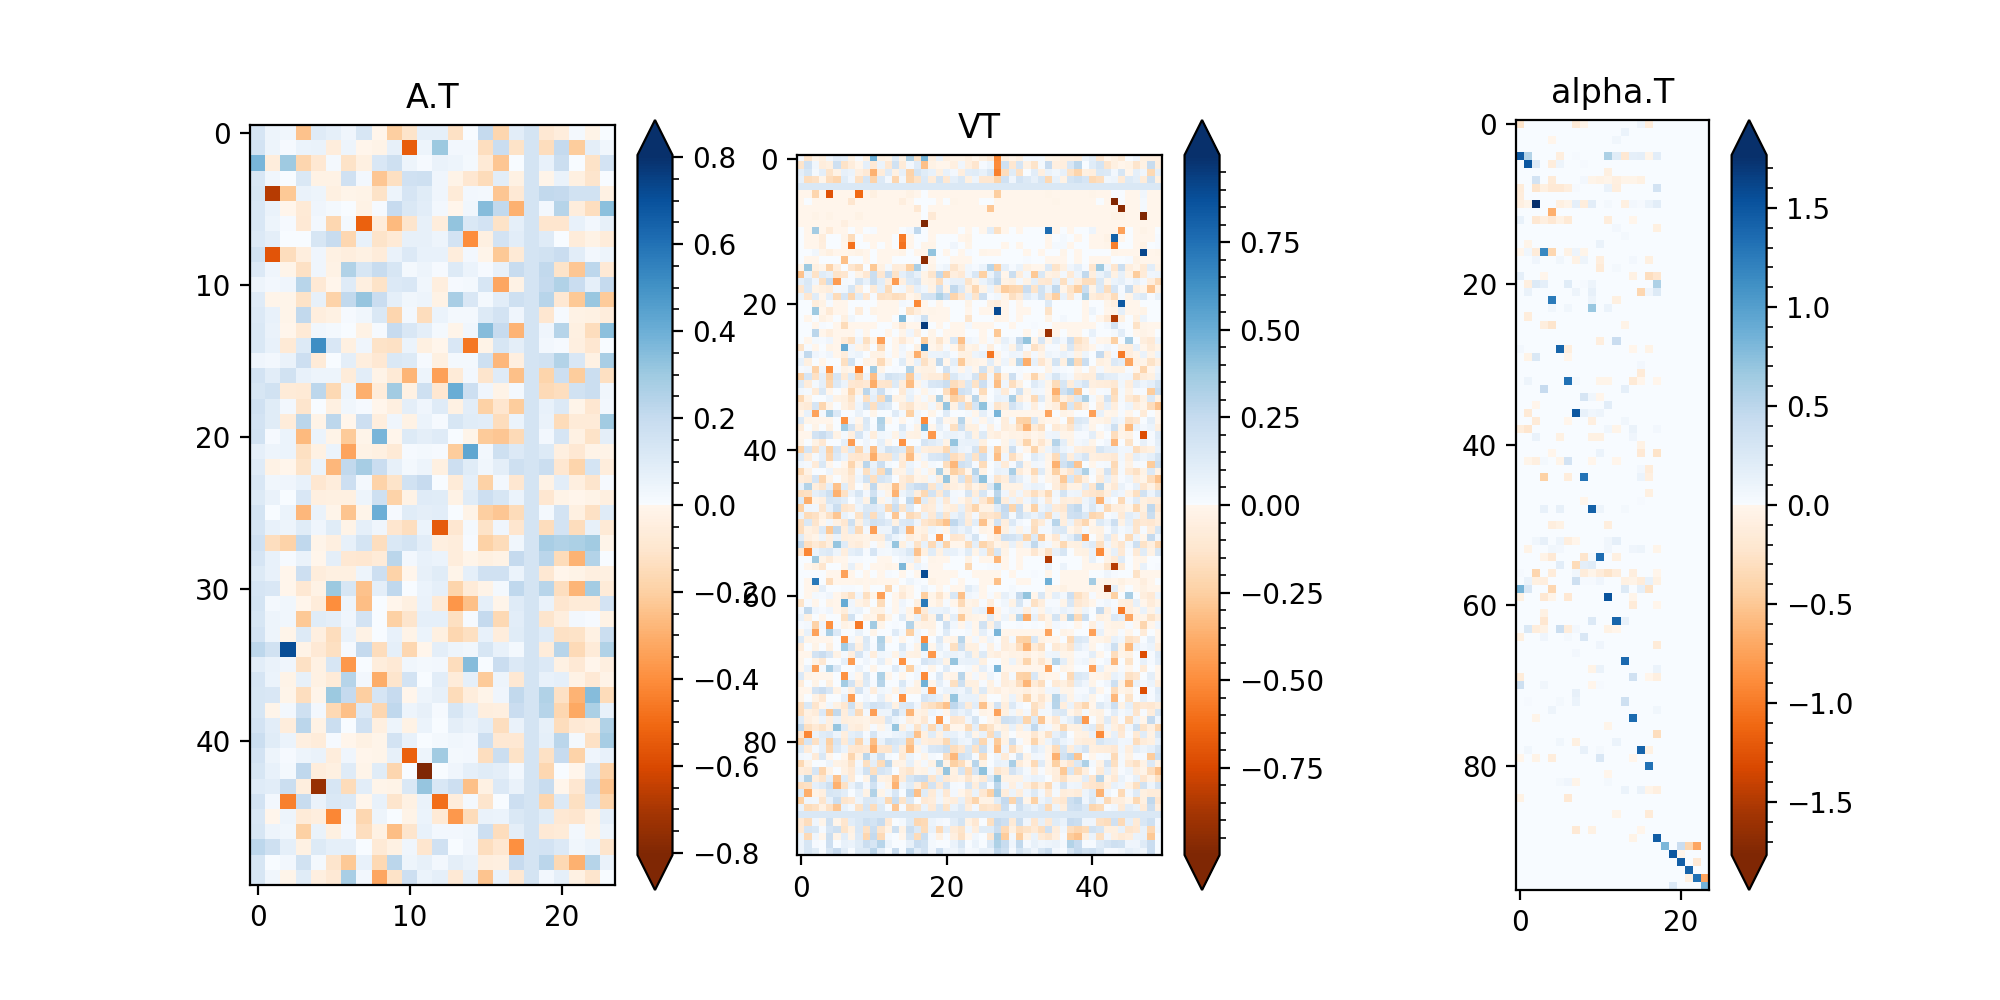

<IPython.core.display.Javascript object>


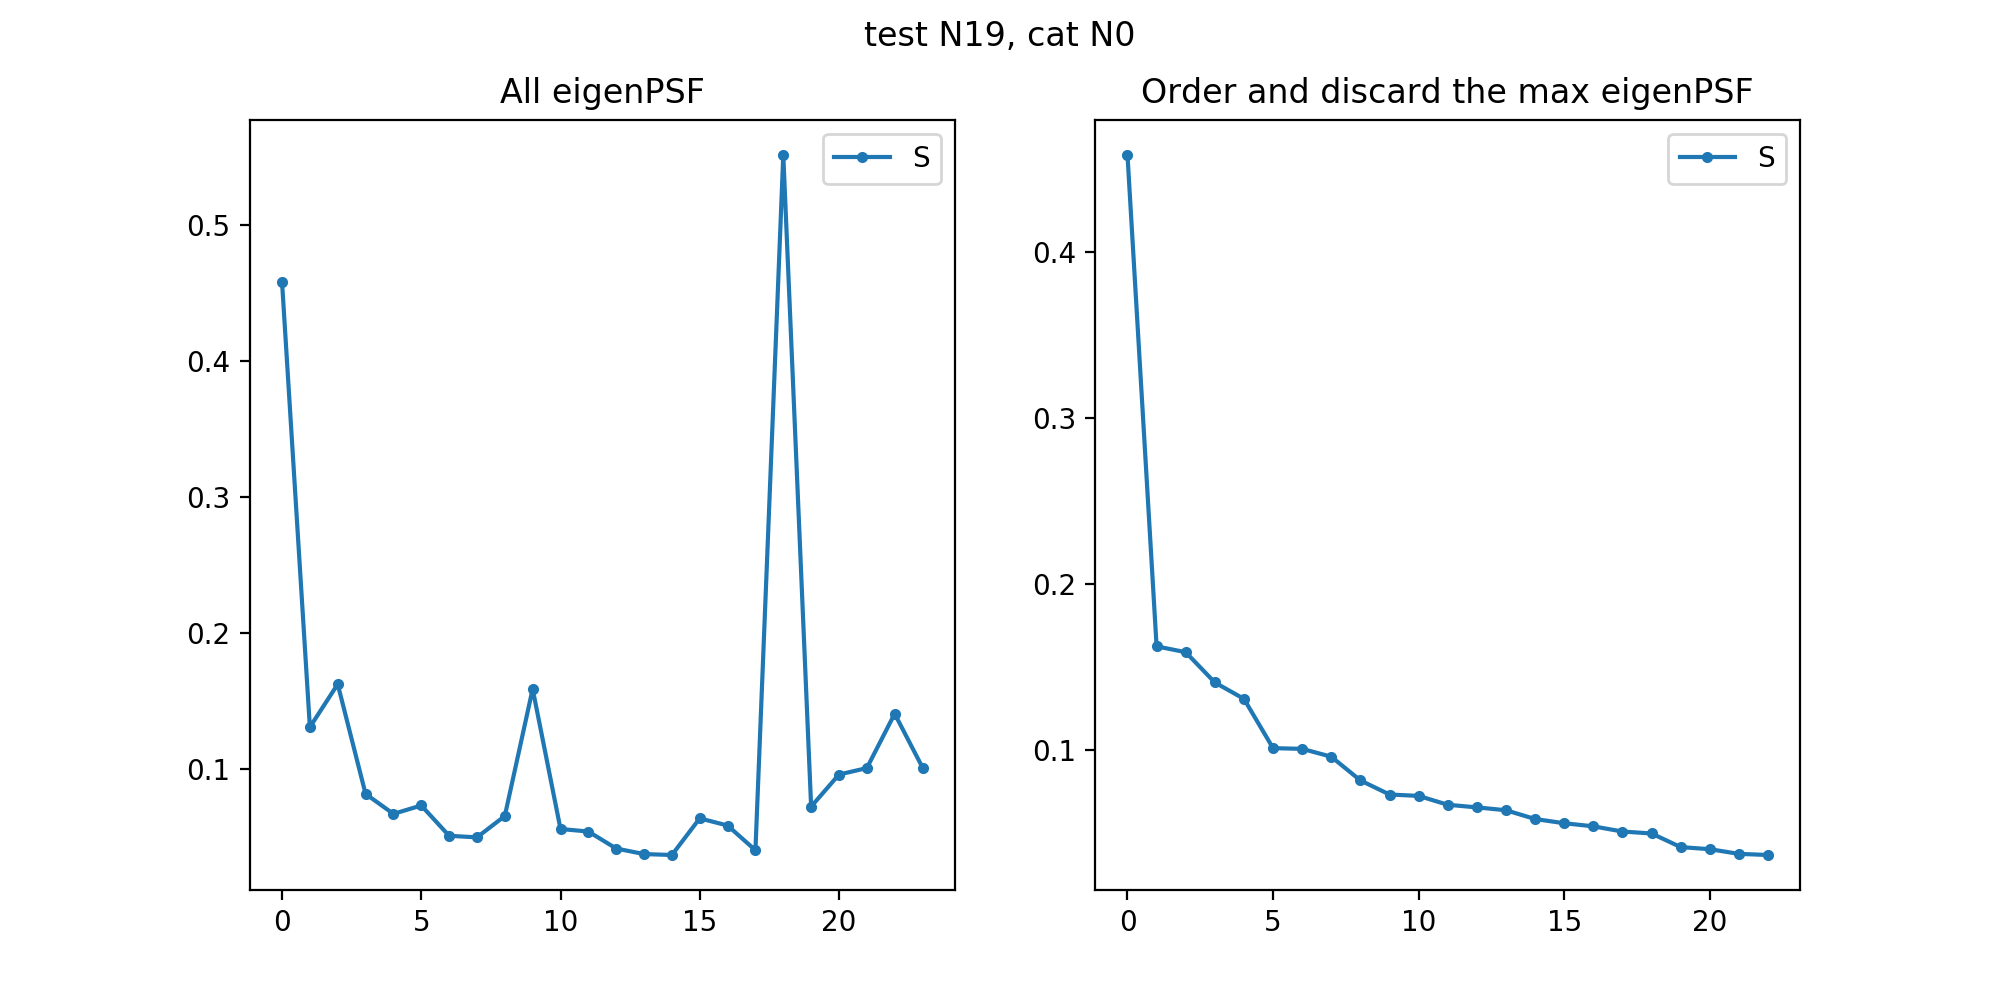

<IPython.core.display.Javascript object>


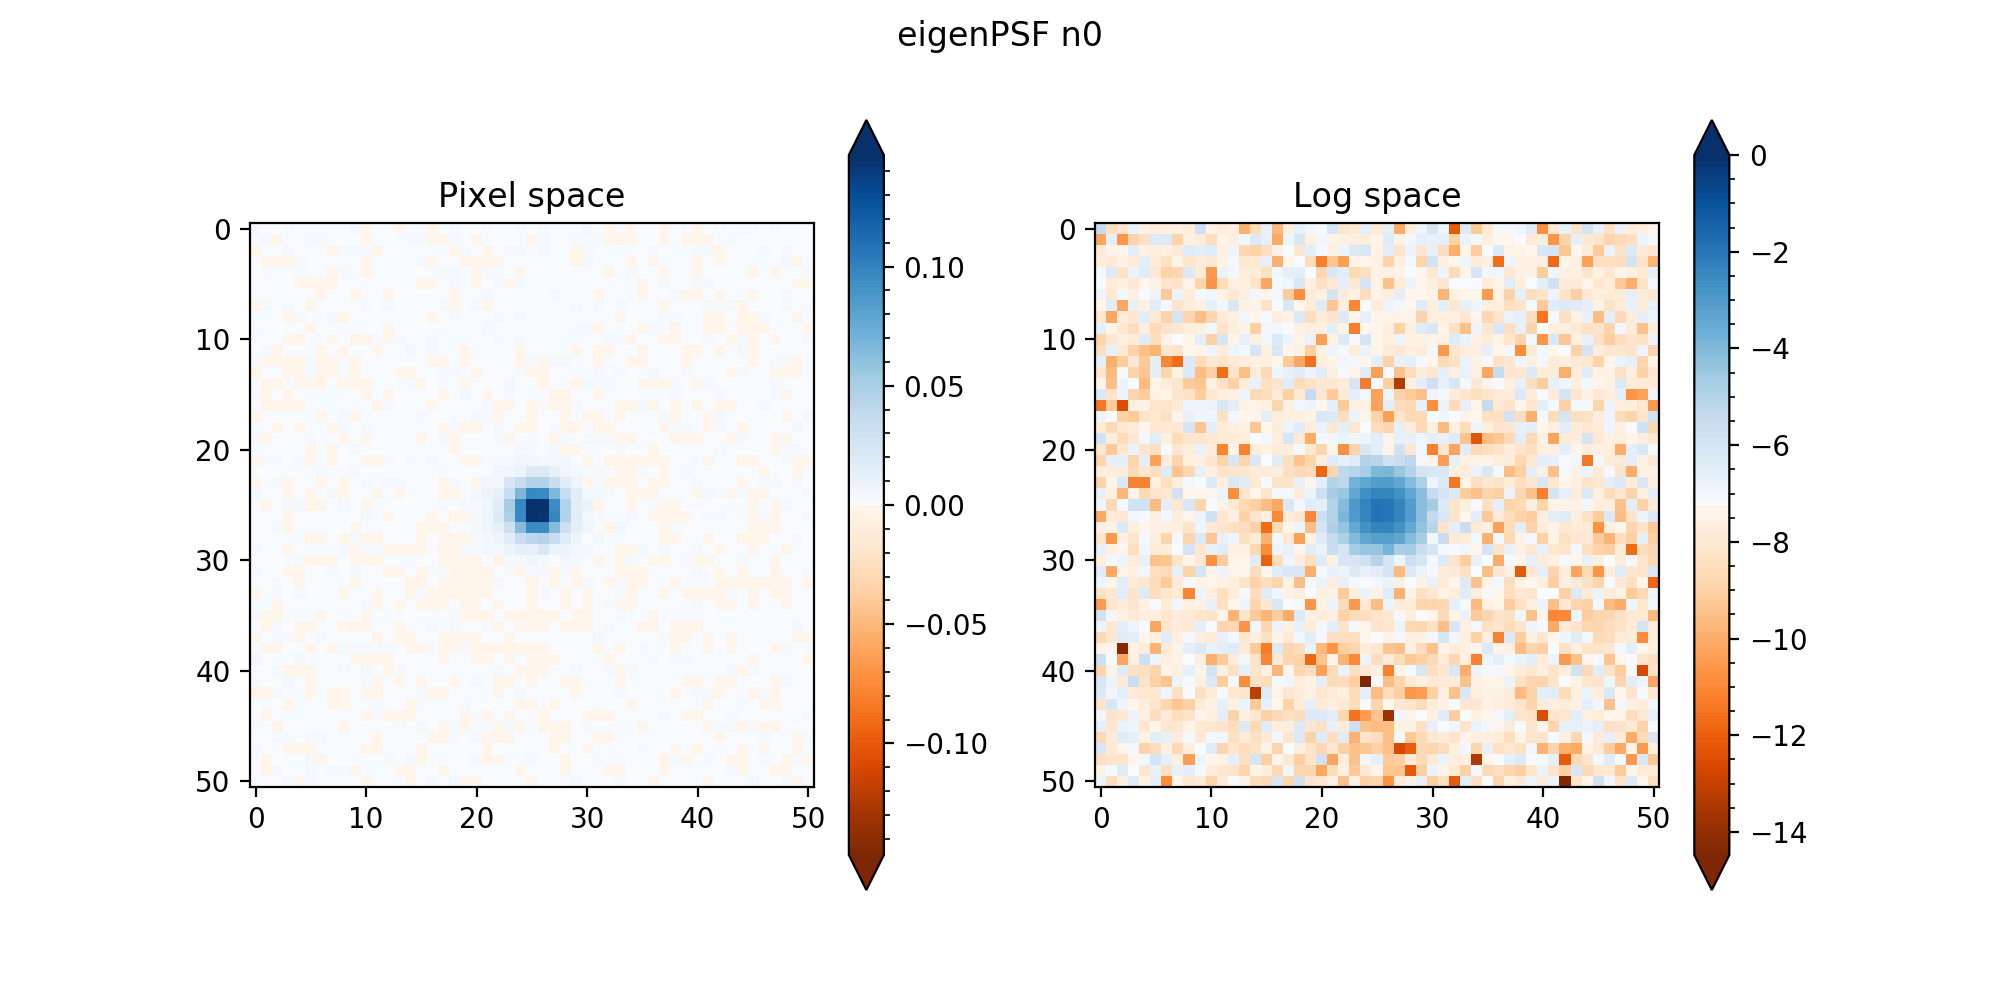

<IPython.core.display.Javascript object>


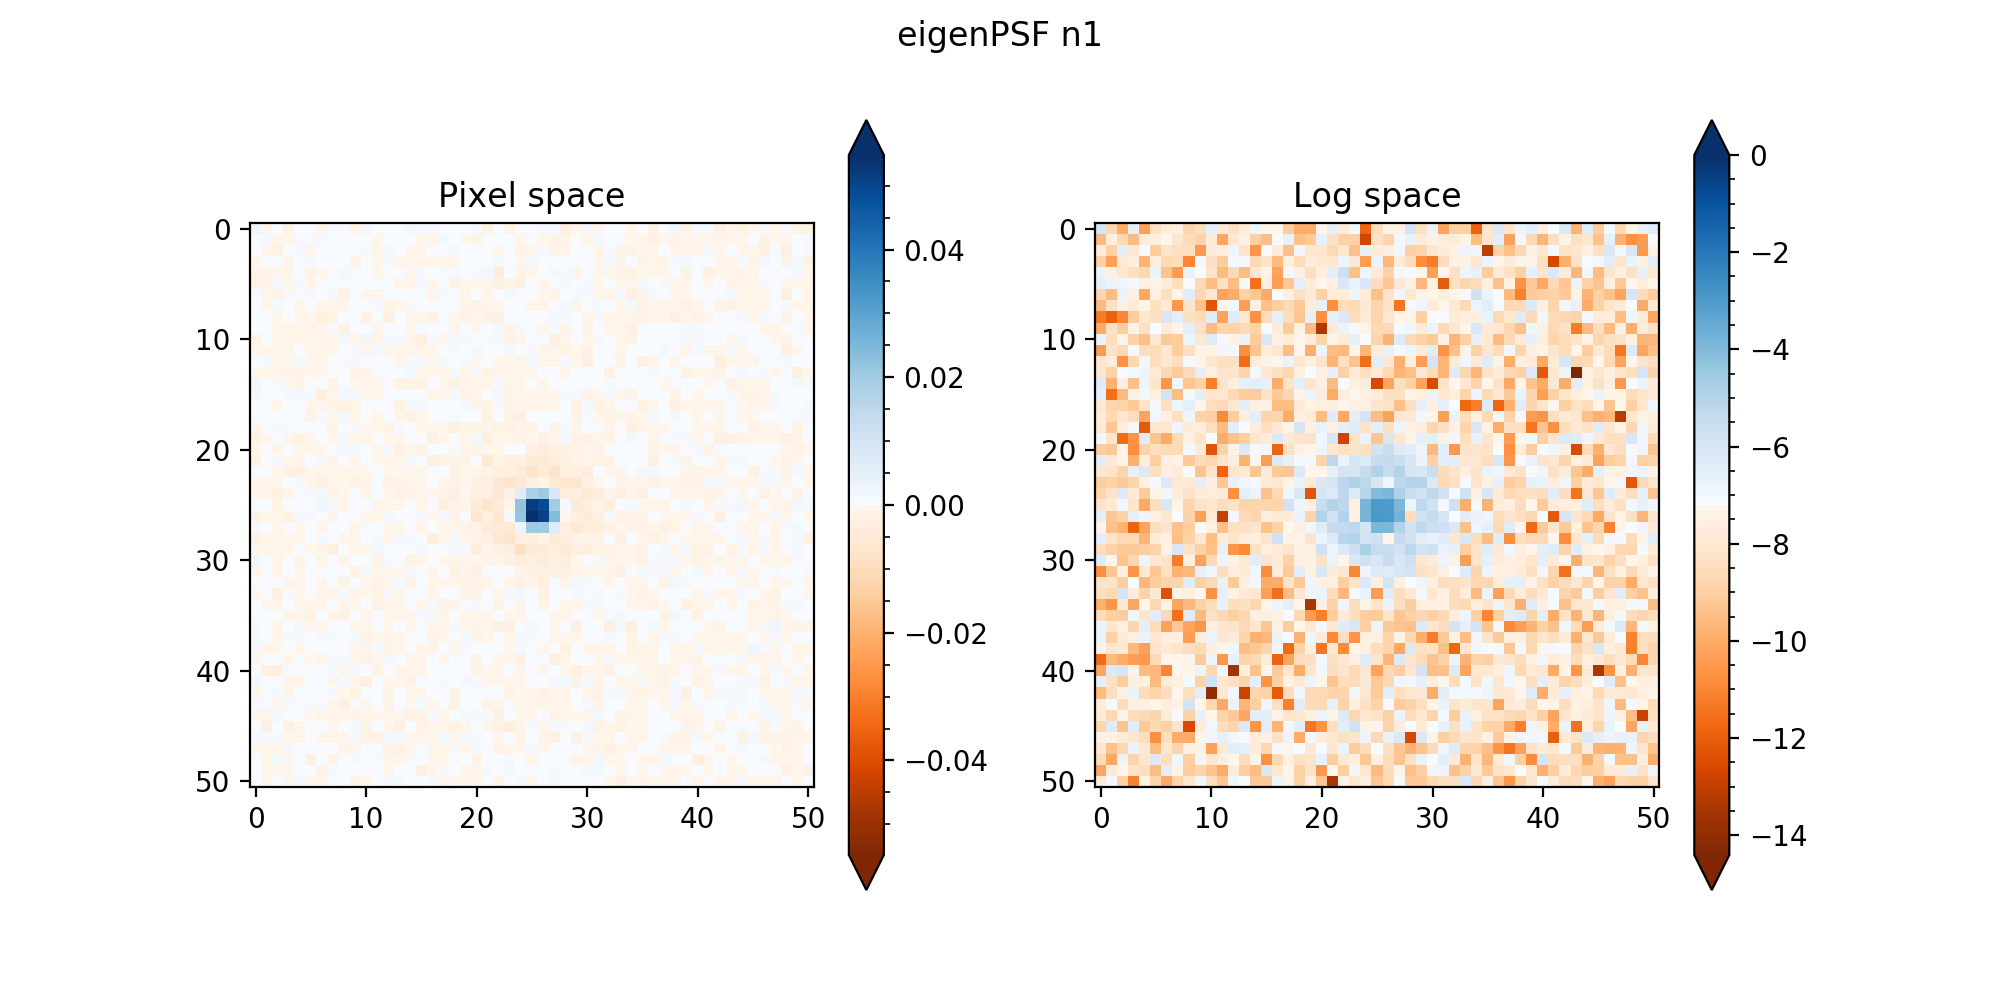

<IPython.core.display.Javascript object>


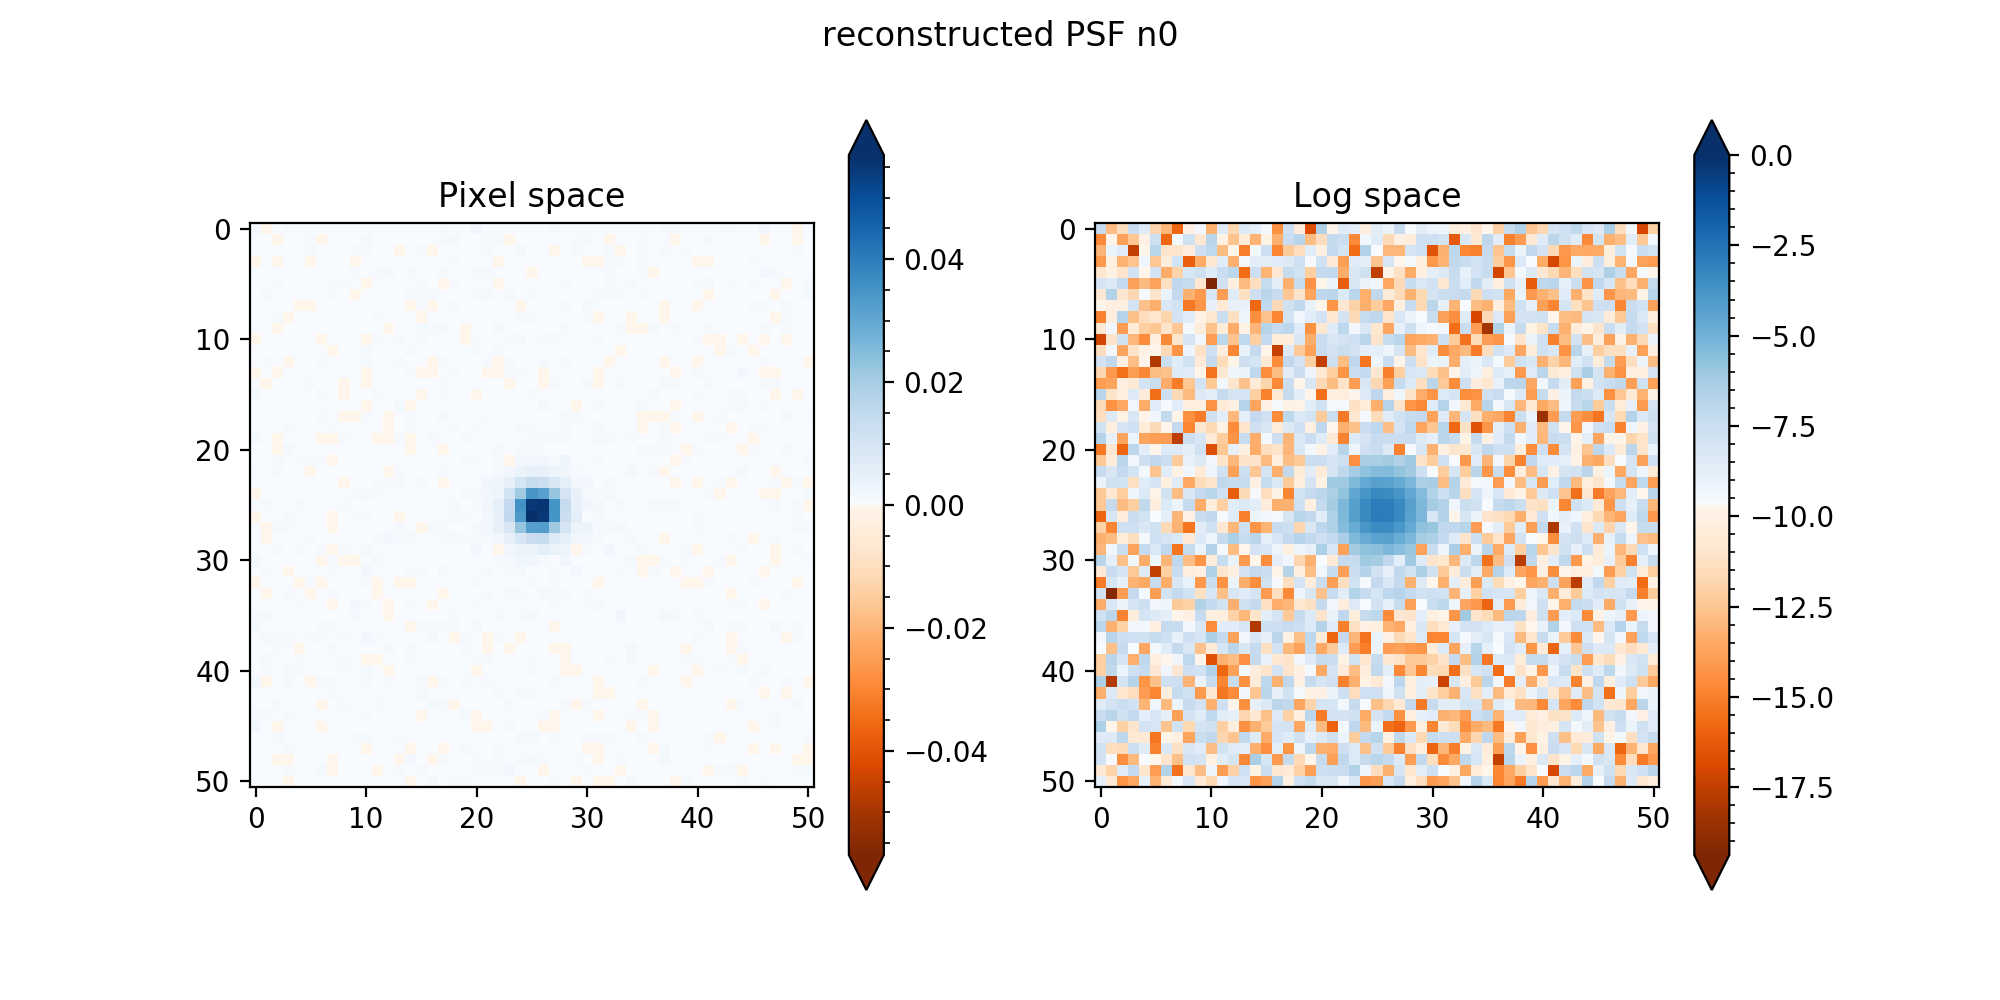

In [123]:
# Plot the A and VT matrices
figs, axs = plt.subplots(1,3,figsize=(10,5))

im_0 = axs[0].imshow(data_A.T, cmap=newcmp, vmin=-vmax1_A, vmax=vmax1_A)
axs[0].set_title('A.T')
#plt.colorbar(im_0, ax = axs[0])
cbar = figs.colorbar(im_0, ax=axs[0], extend='both')
cbar.minorticks_on()

im_1 = axs[1].imshow(data_VT, cmap=newcmp, vmin=-vmax1_VT, vmax=vmax1_VT)
axs[1].set_title('VT')
#plt.colorbar(im_1, ax = axs[1])
cbar = figs.colorbar(im_1, ax=axs[1], extend='both')
cbar.minorticks_on()

im_2 = axs[2].imshow(data_alpha.T, cmap=newcmp, vmin=-vmax1_alpha, vmax=vmax1_alpha)
axs[2].set_title('alpha.T')
#plt.colorbar(im_1, ax = axs[1])
cbar = figs.colorbar(im_2, ax=axs[2], extend='both')
cbar.minorticks_on()
plt.savefig('A_VT_alpha_test%d-cat_%d.png'%(test_n,k))

# Plot the norm of S and H lines
# a_lines = np.array([np.sqrt(np.sum(data_A[k,:]**2)) for k in range(data_A.shape[0])])
s_imgs = np.array([np.sqrt(np.sum(data_S[:,:,k]**2)) for k in range(data_S.shape[2])])
data_H = data_S @ data_A
h_imgs = np.array([np.sqrt(np.sum(data_H[:,:,k]**2)) for k in range(data_H.shape[2])])

sort_idxs = np.flip(np.argsort(s_imgs).astype(int)[:-1]) # Do not include the max eigenPSF

figs2, axs2 = plt.subplots(1,2,figsize=(10,5))
figs2.suptitle('test N%d, cat N%d'%(test_n,k))

axs2[0].plot(s_imgs, marker='o', markersize=3, label='S')
#axs2[0].plot(h_imgs, marker='o', markersize=3, label='H')
axs2[0].set_title('All eigenPSF')
axs2[0].legend()

axs2[1].plot(s_imgs[sort_idxs], marker='o', markersize=3, label='S')
#axs2[1].plot(h_imgs[sort_idxs], marker='o', markersize=3, label='H')
axs2[1].set_title('Order and discard the max eigenPSF')
axs2[1].legend()
plt.show()
plt.savefig('test_%d-cat_%d.png'%(test_n,k))

# Plot two eigen PSF
PSF_n = 0
plot_img(data_S[:,:,PSF_n], title_str = 'eigenPSF n%d'%(PSF_n))
PSF_n = 1
plot_img(data_S[:,:,PSF_n], title_str = 'eigenPSF n%d'%(PSF_n))

# Plot one reconstructed PSF
recPSF_n = 0
plot_img(data_H[:,:,recPSF_n], title_str = 'reconstructed PSF n%d'%(recPSF_n))



## Create the GIF image

<IPython.core.display.Javascript object>


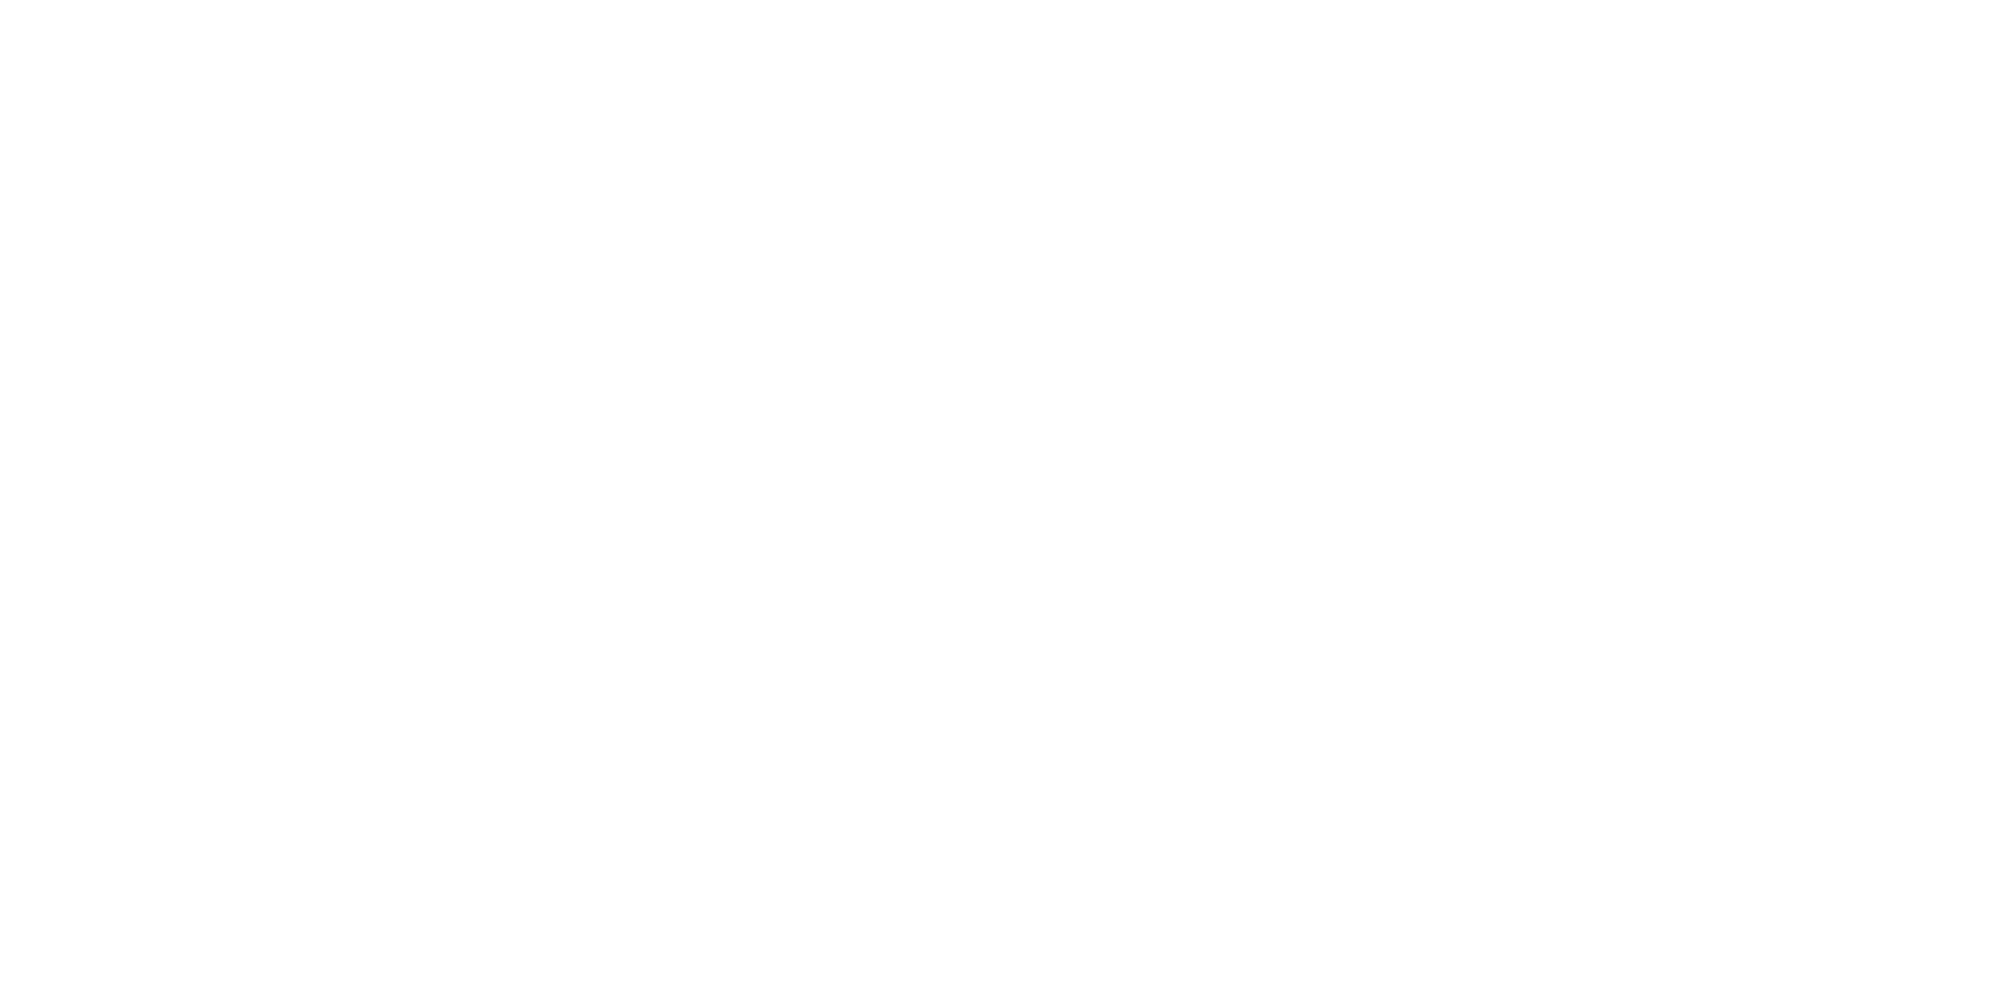

<IPython.core.display.Javascript object>


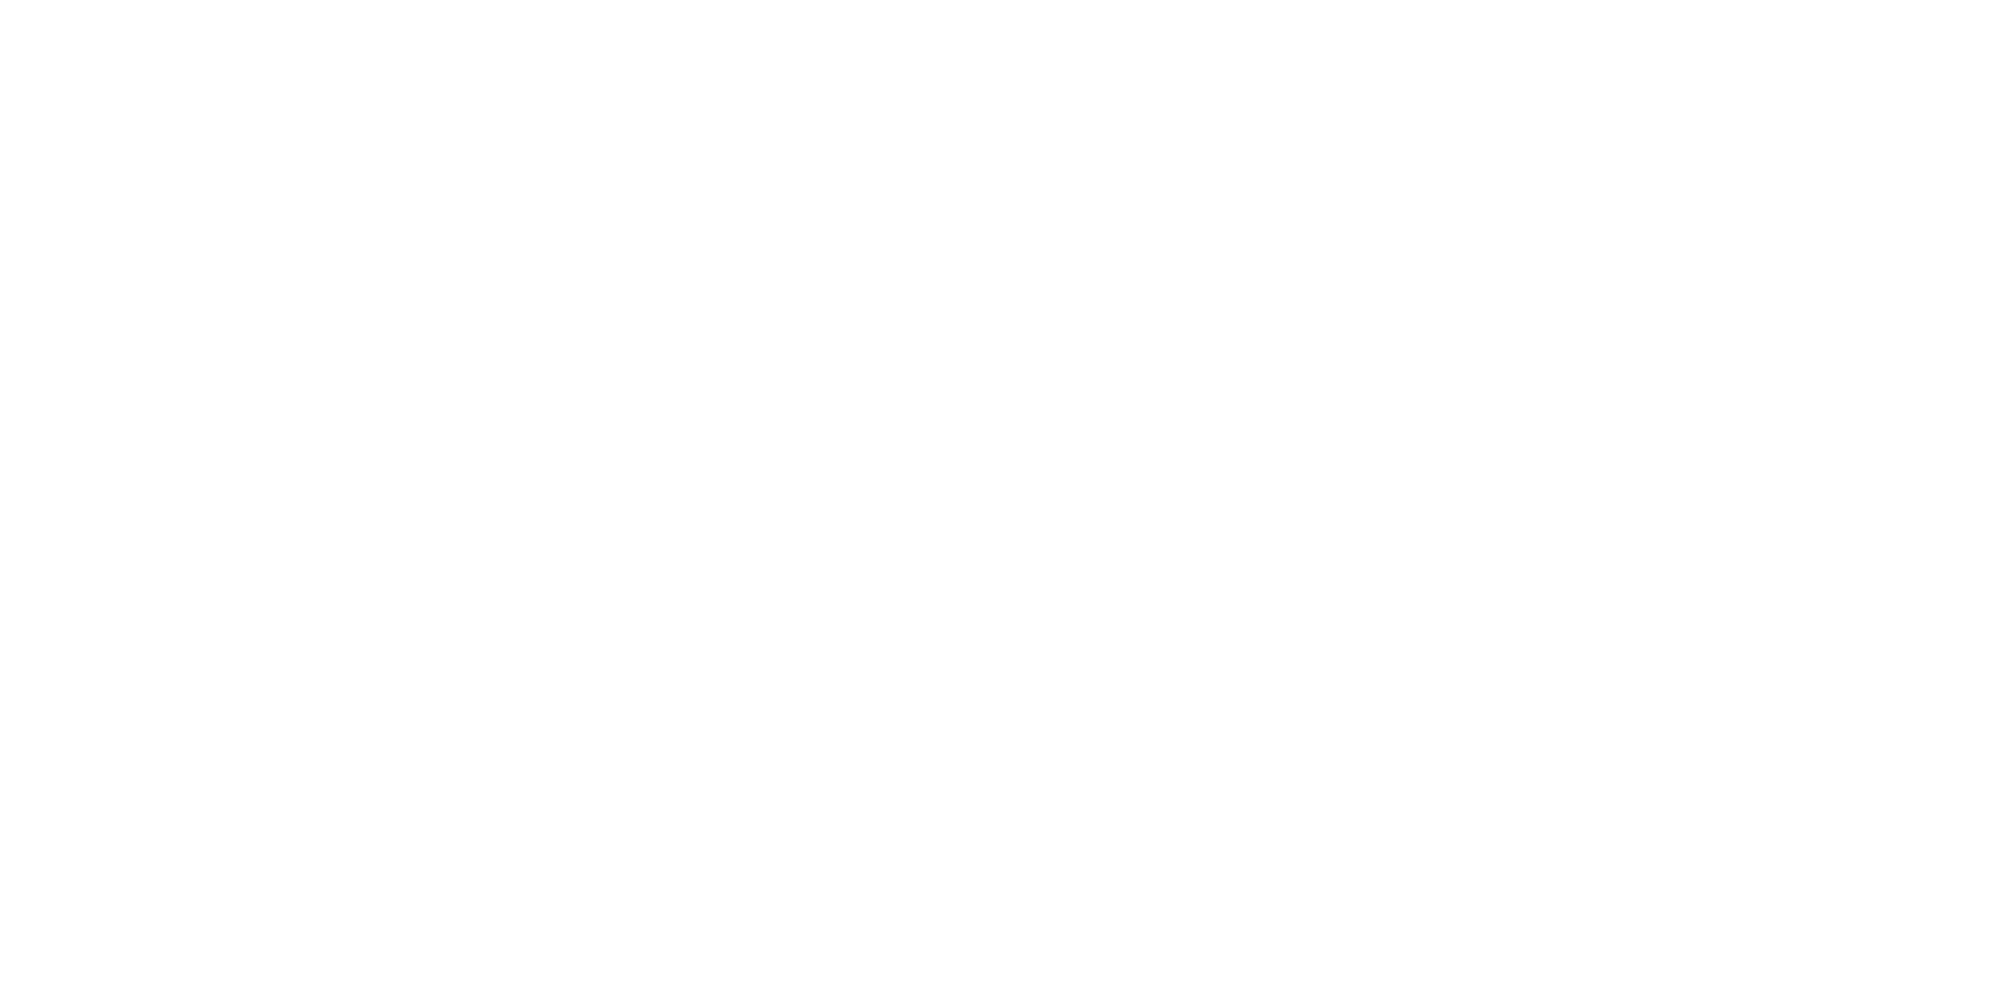

<IPython.core.display.Javascript object>


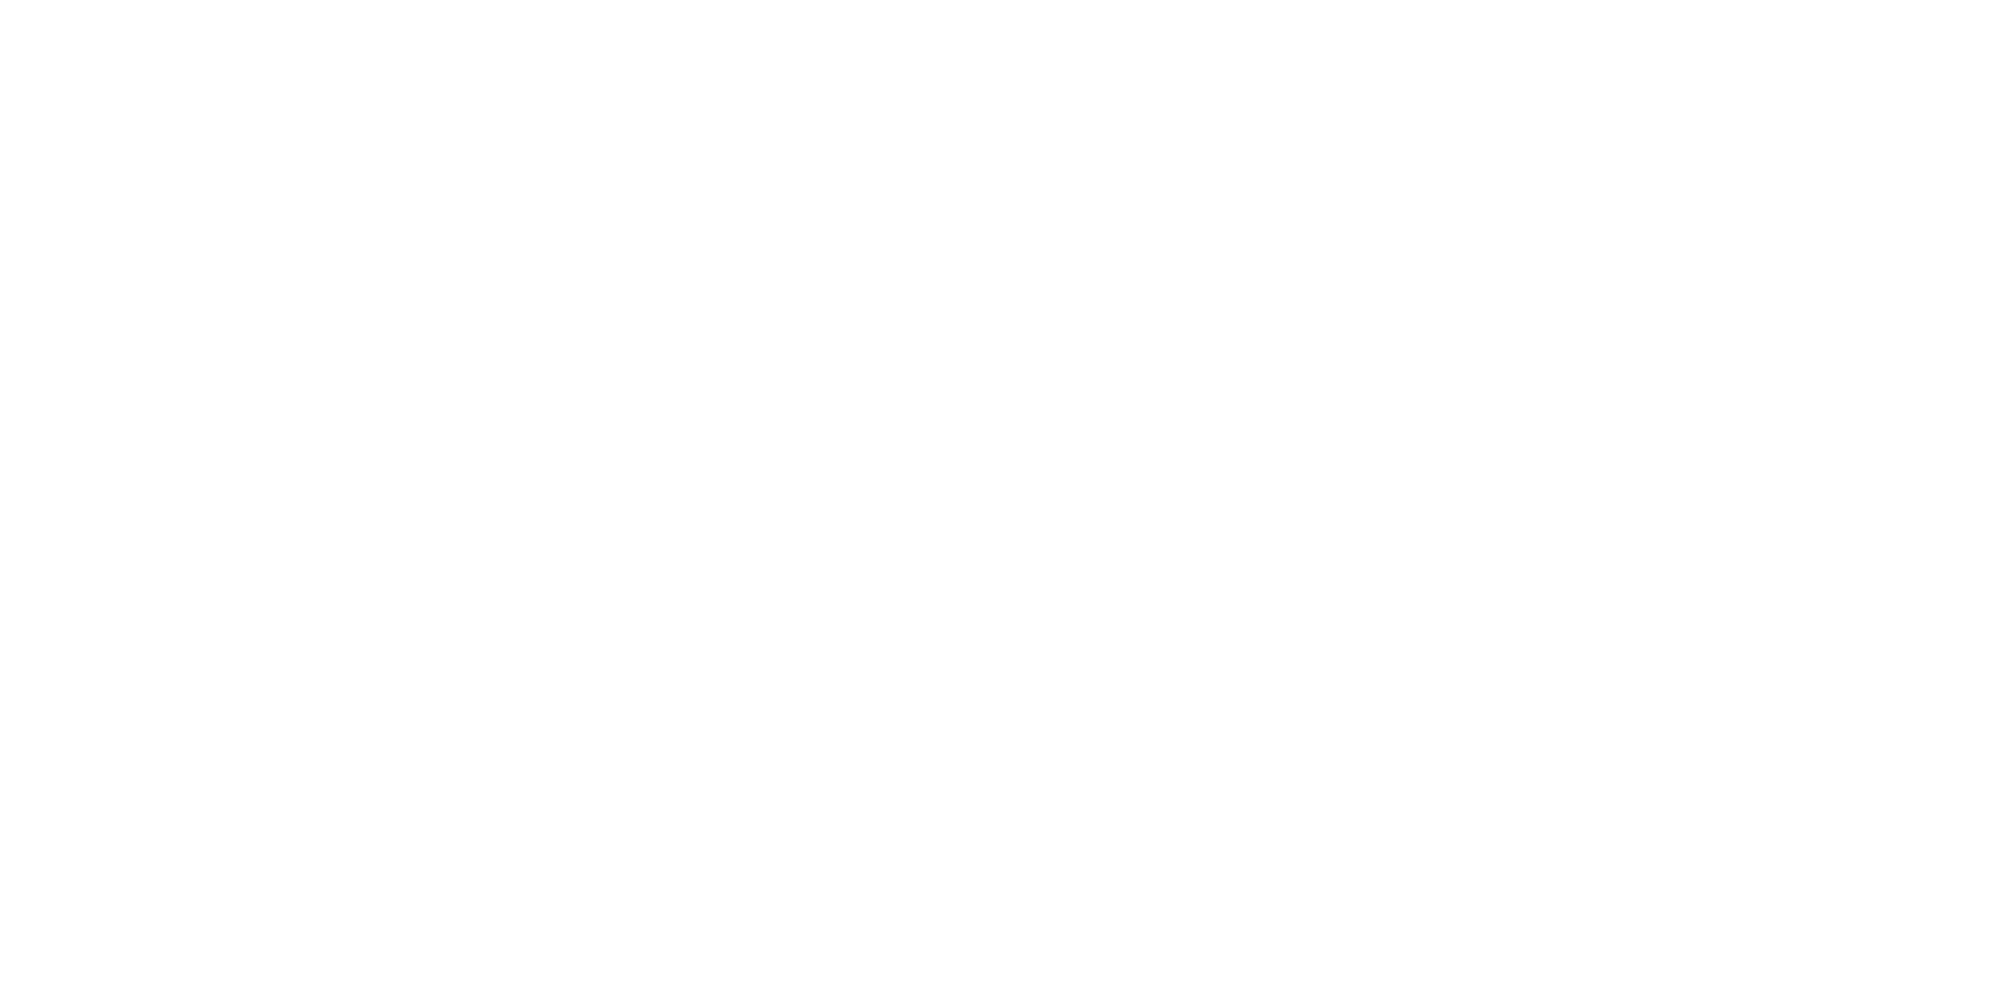

<IPython.core.display.Javascript object>


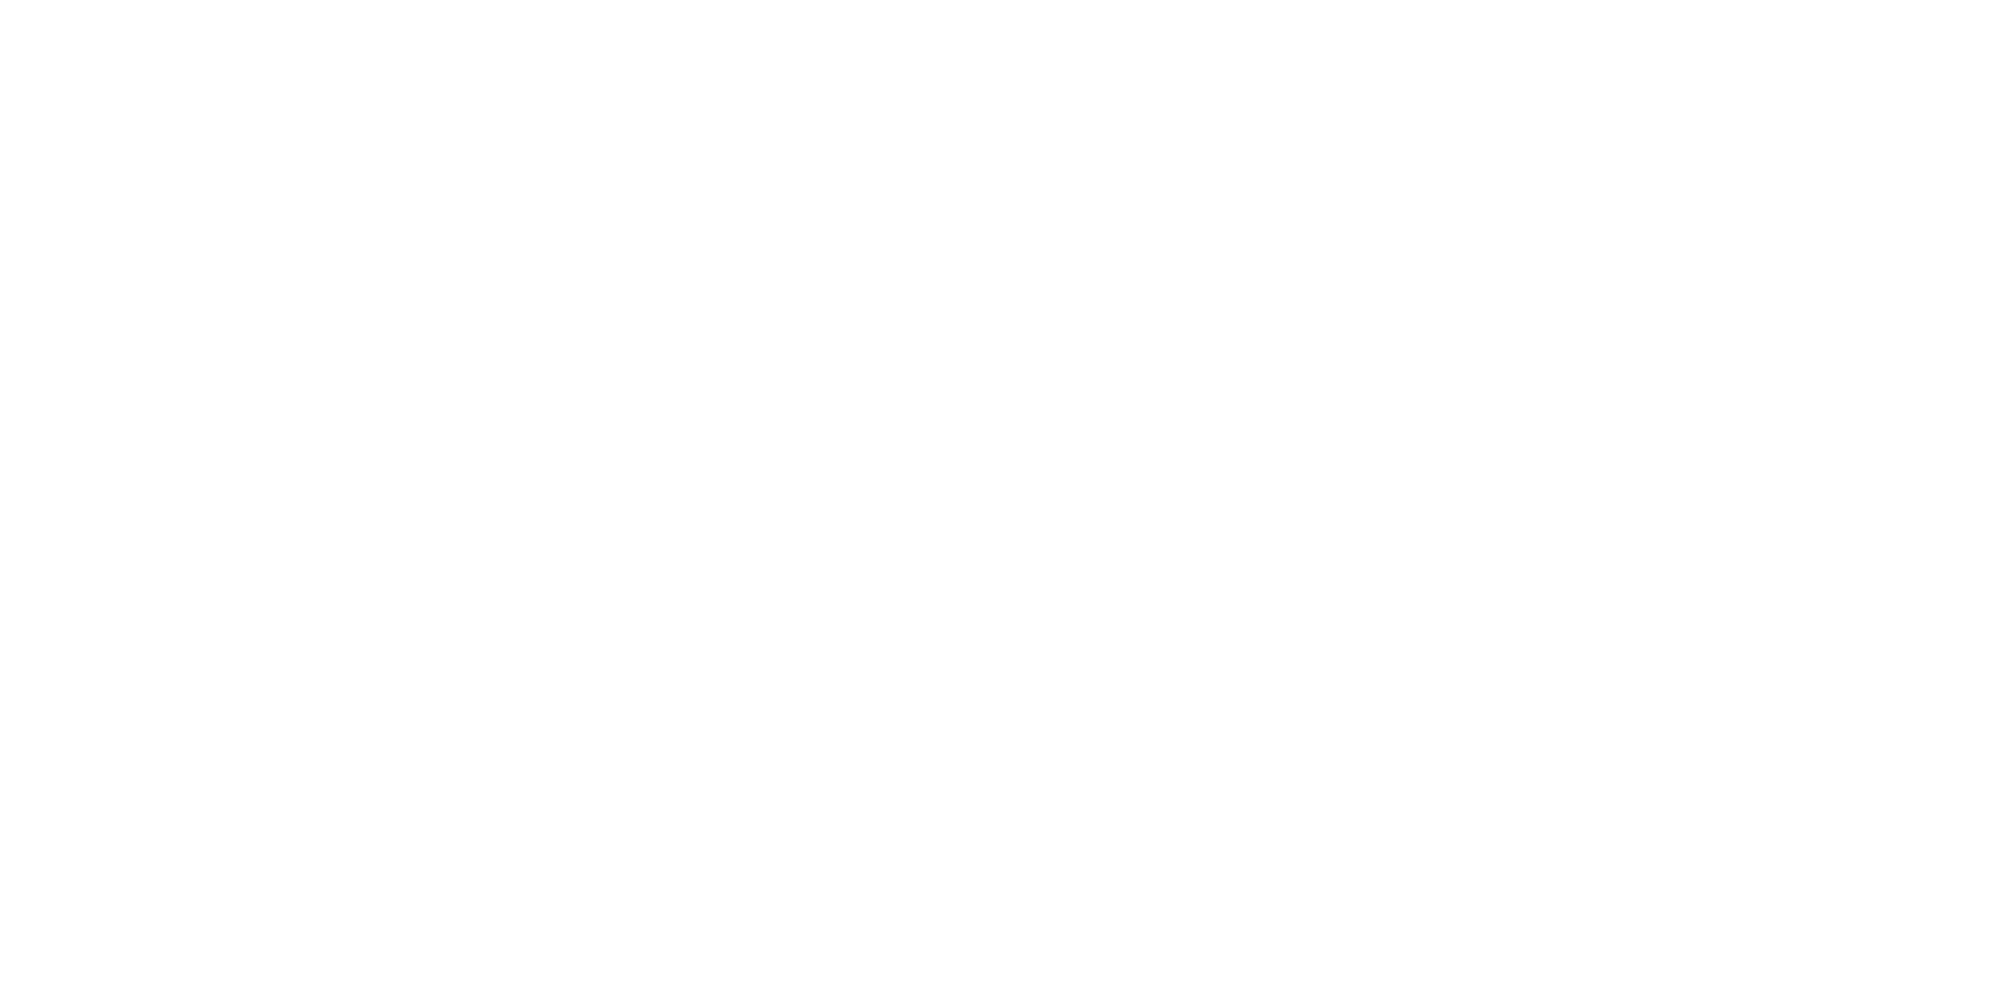

<IPython.core.display.Javascript object>


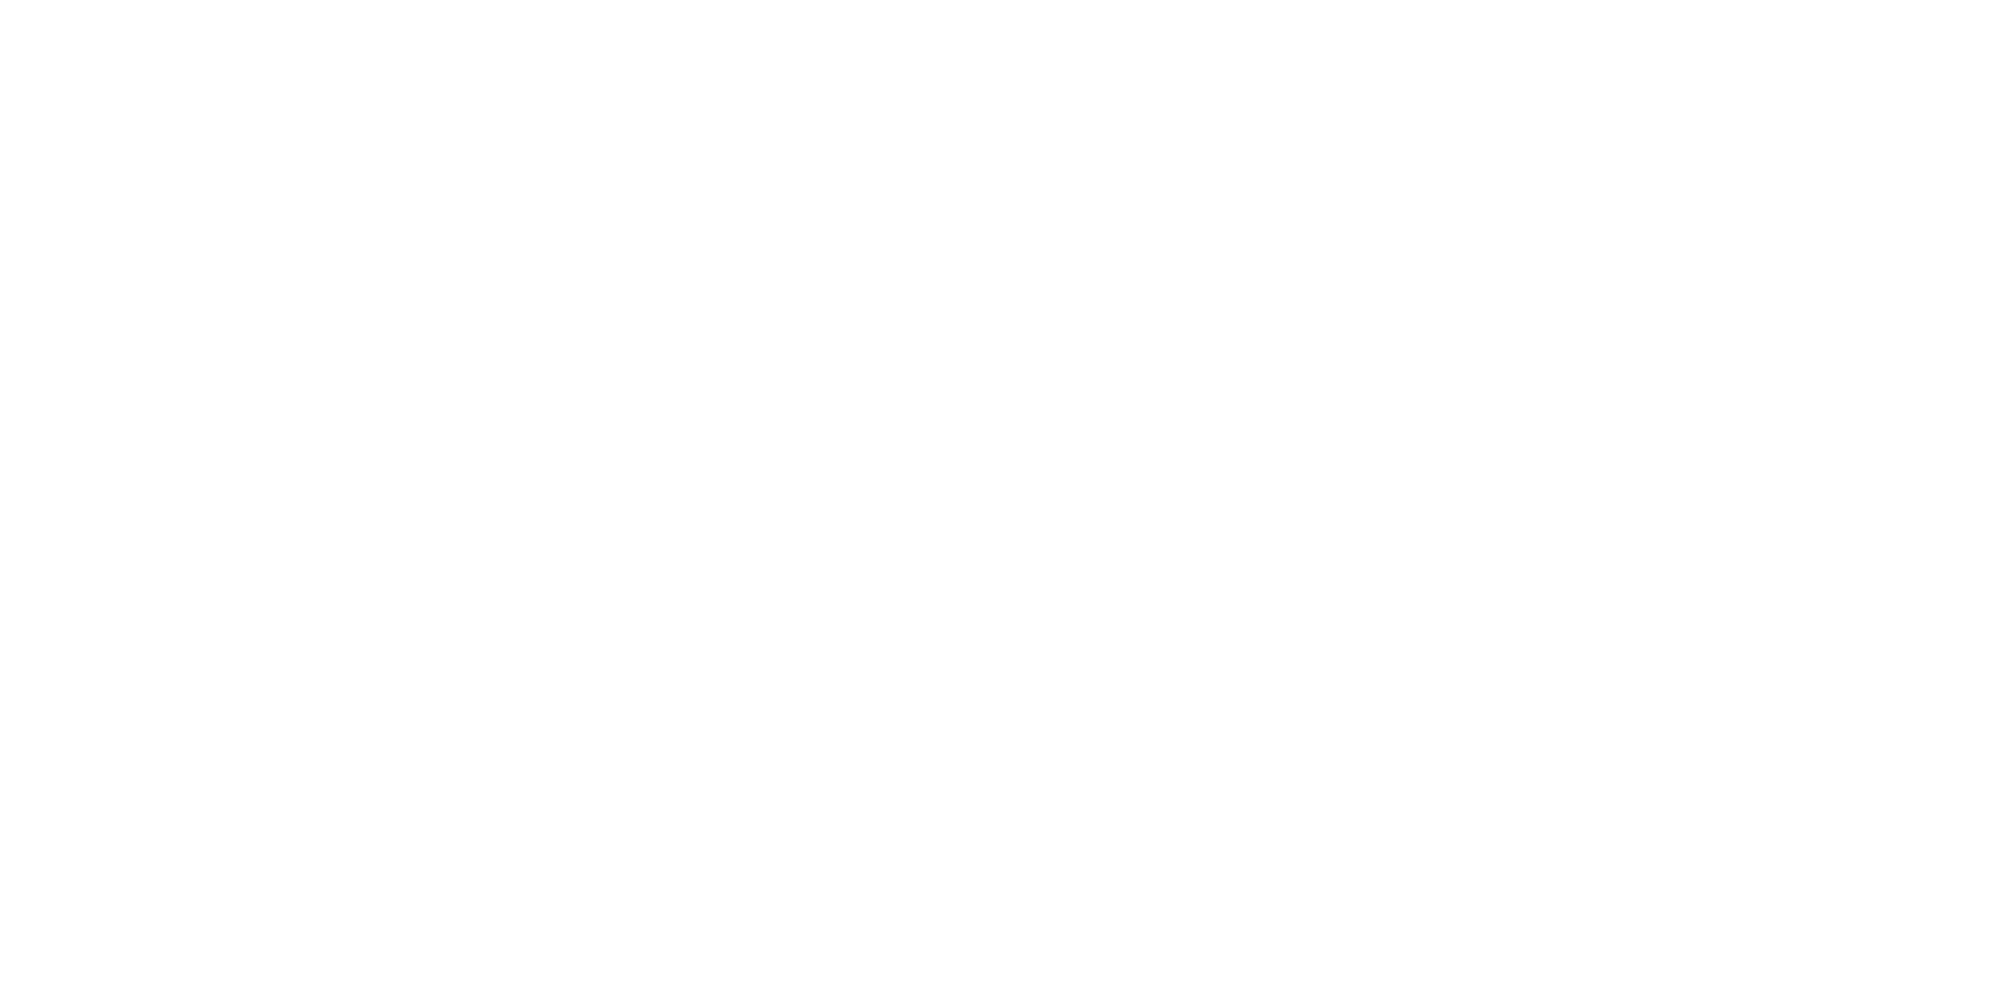

<IPython.core.display.Javascript object>


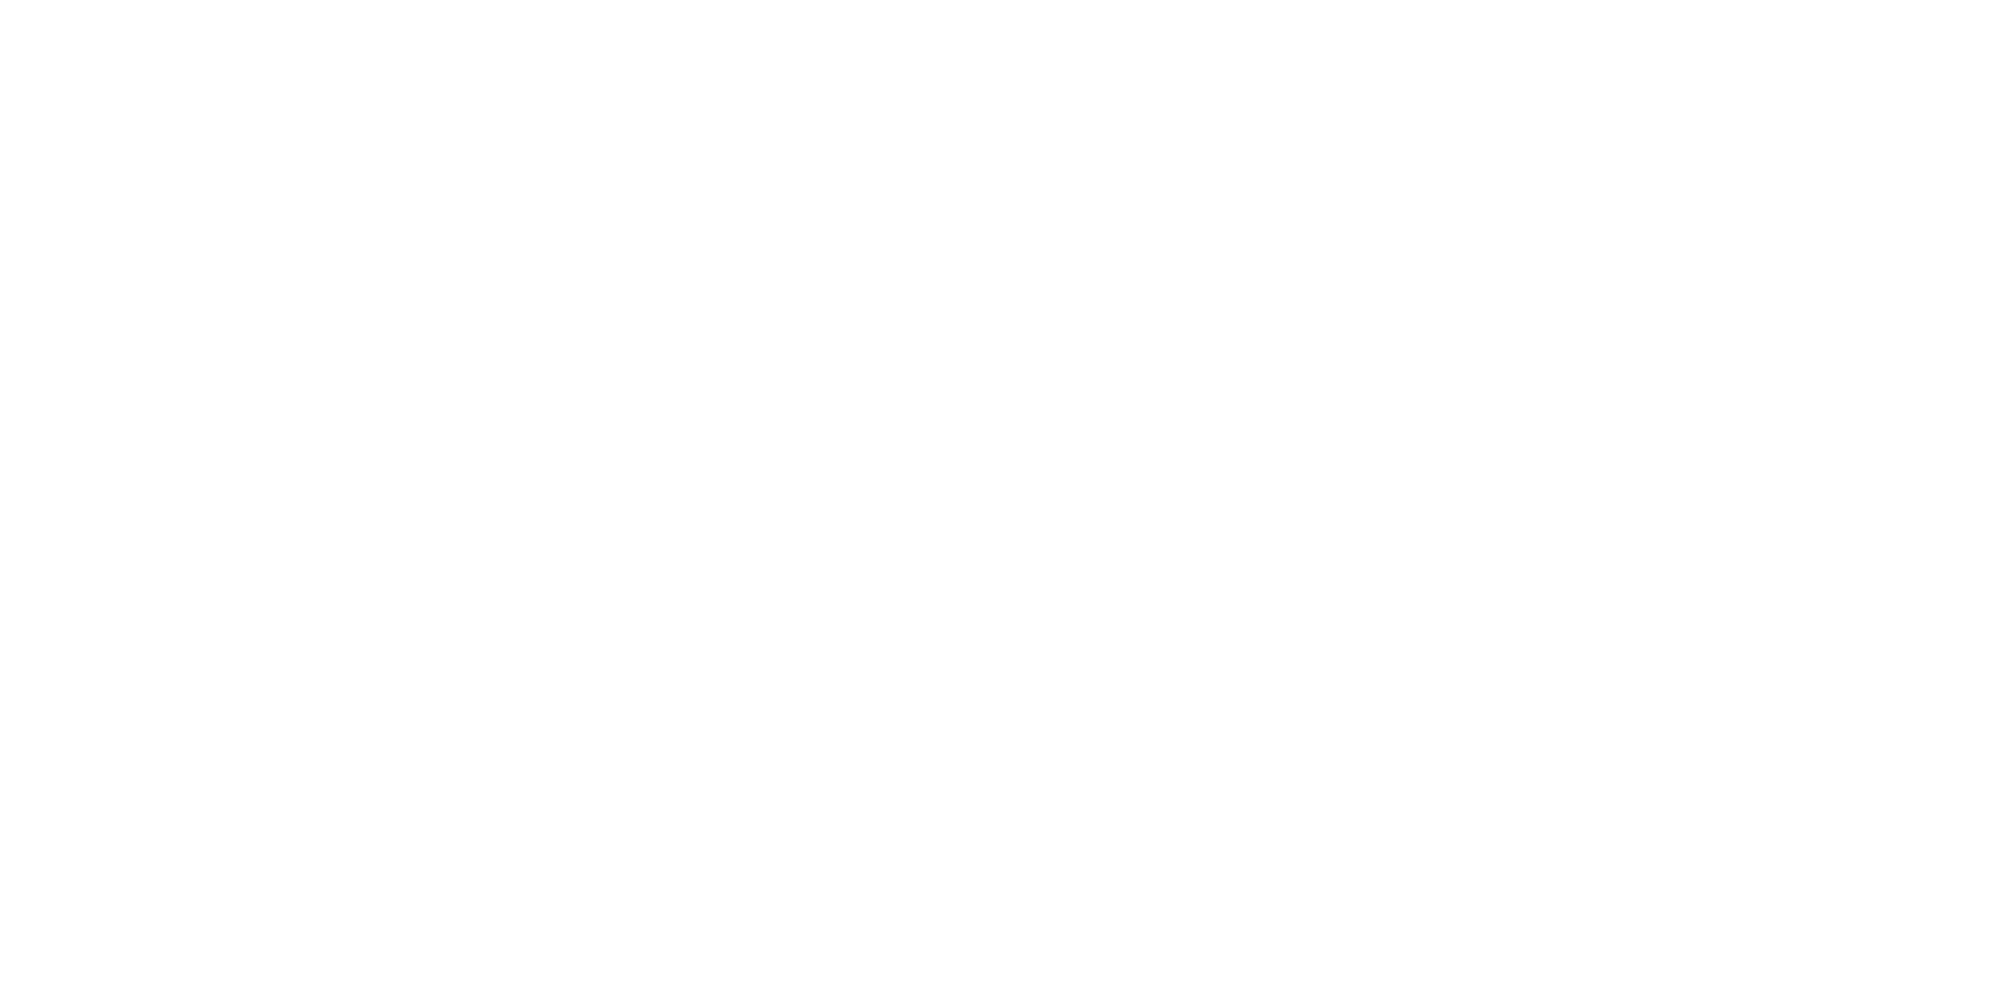

<IPython.core.display.Javascript object>


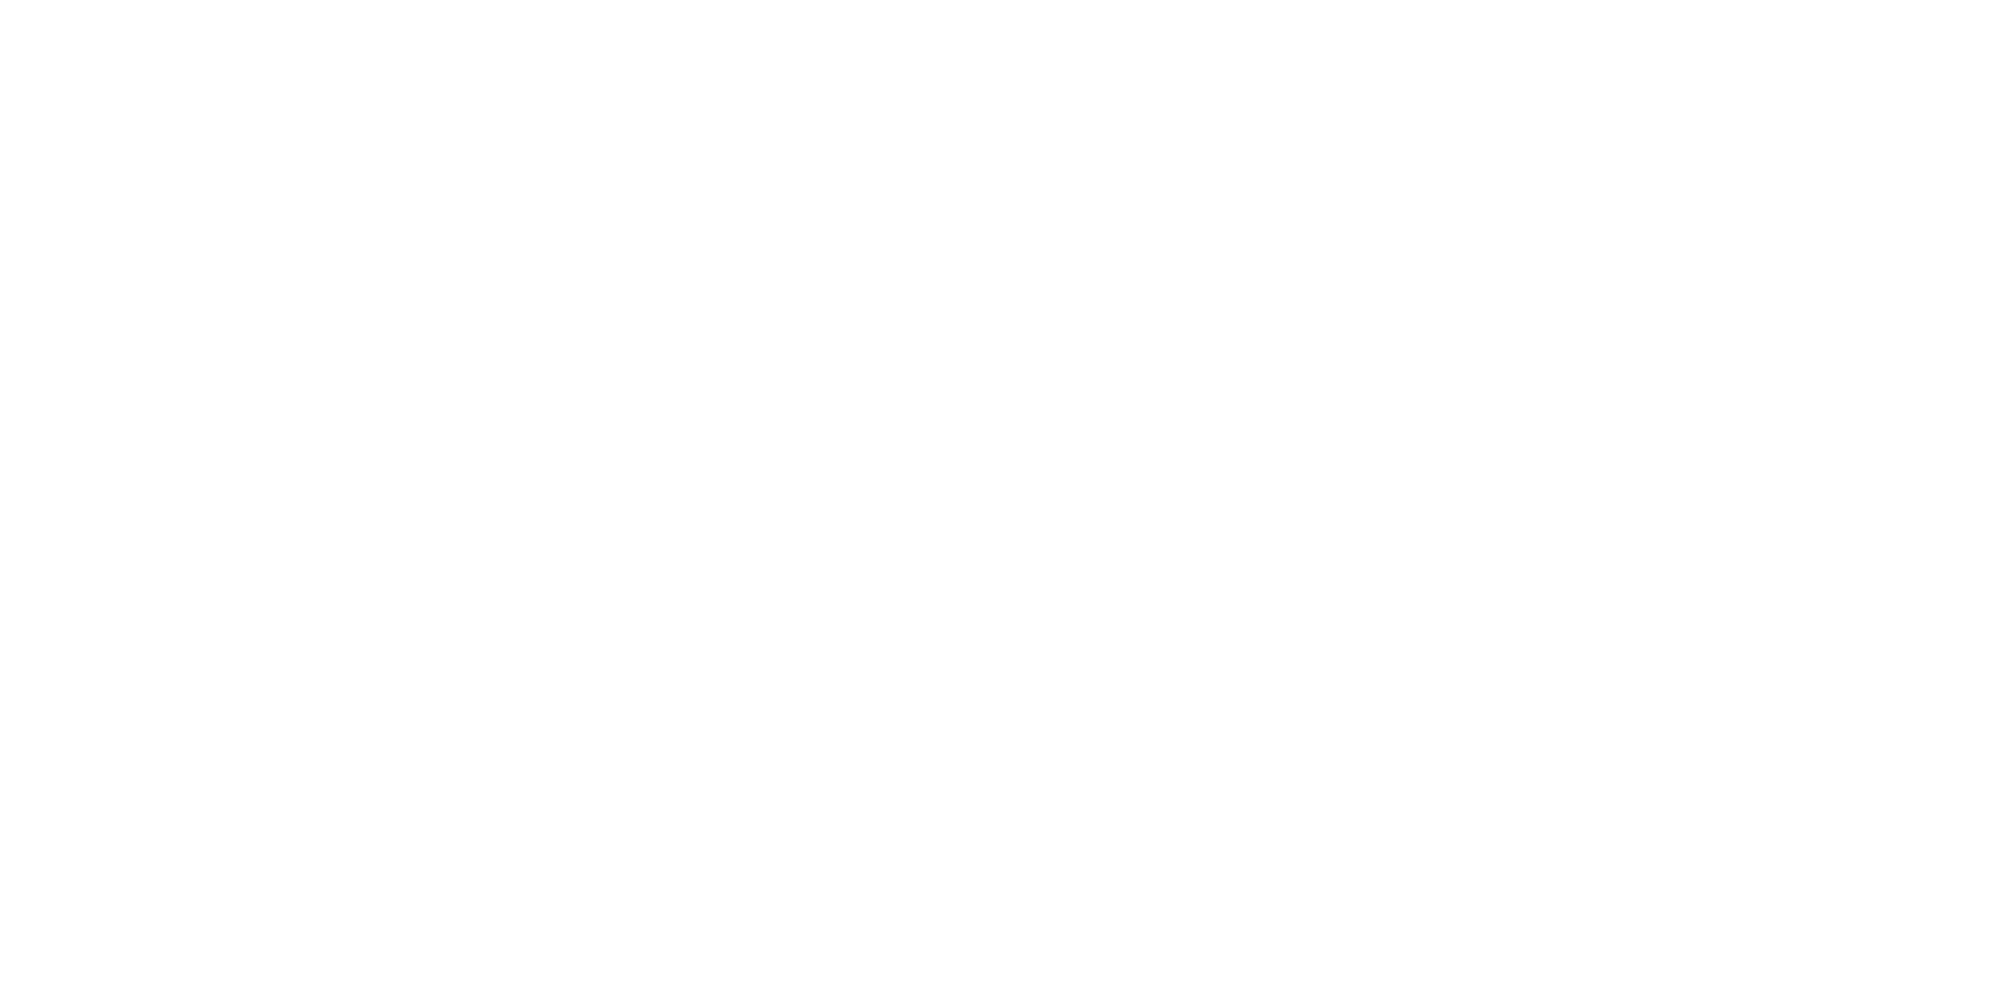

<IPython.core.display.Javascript object>


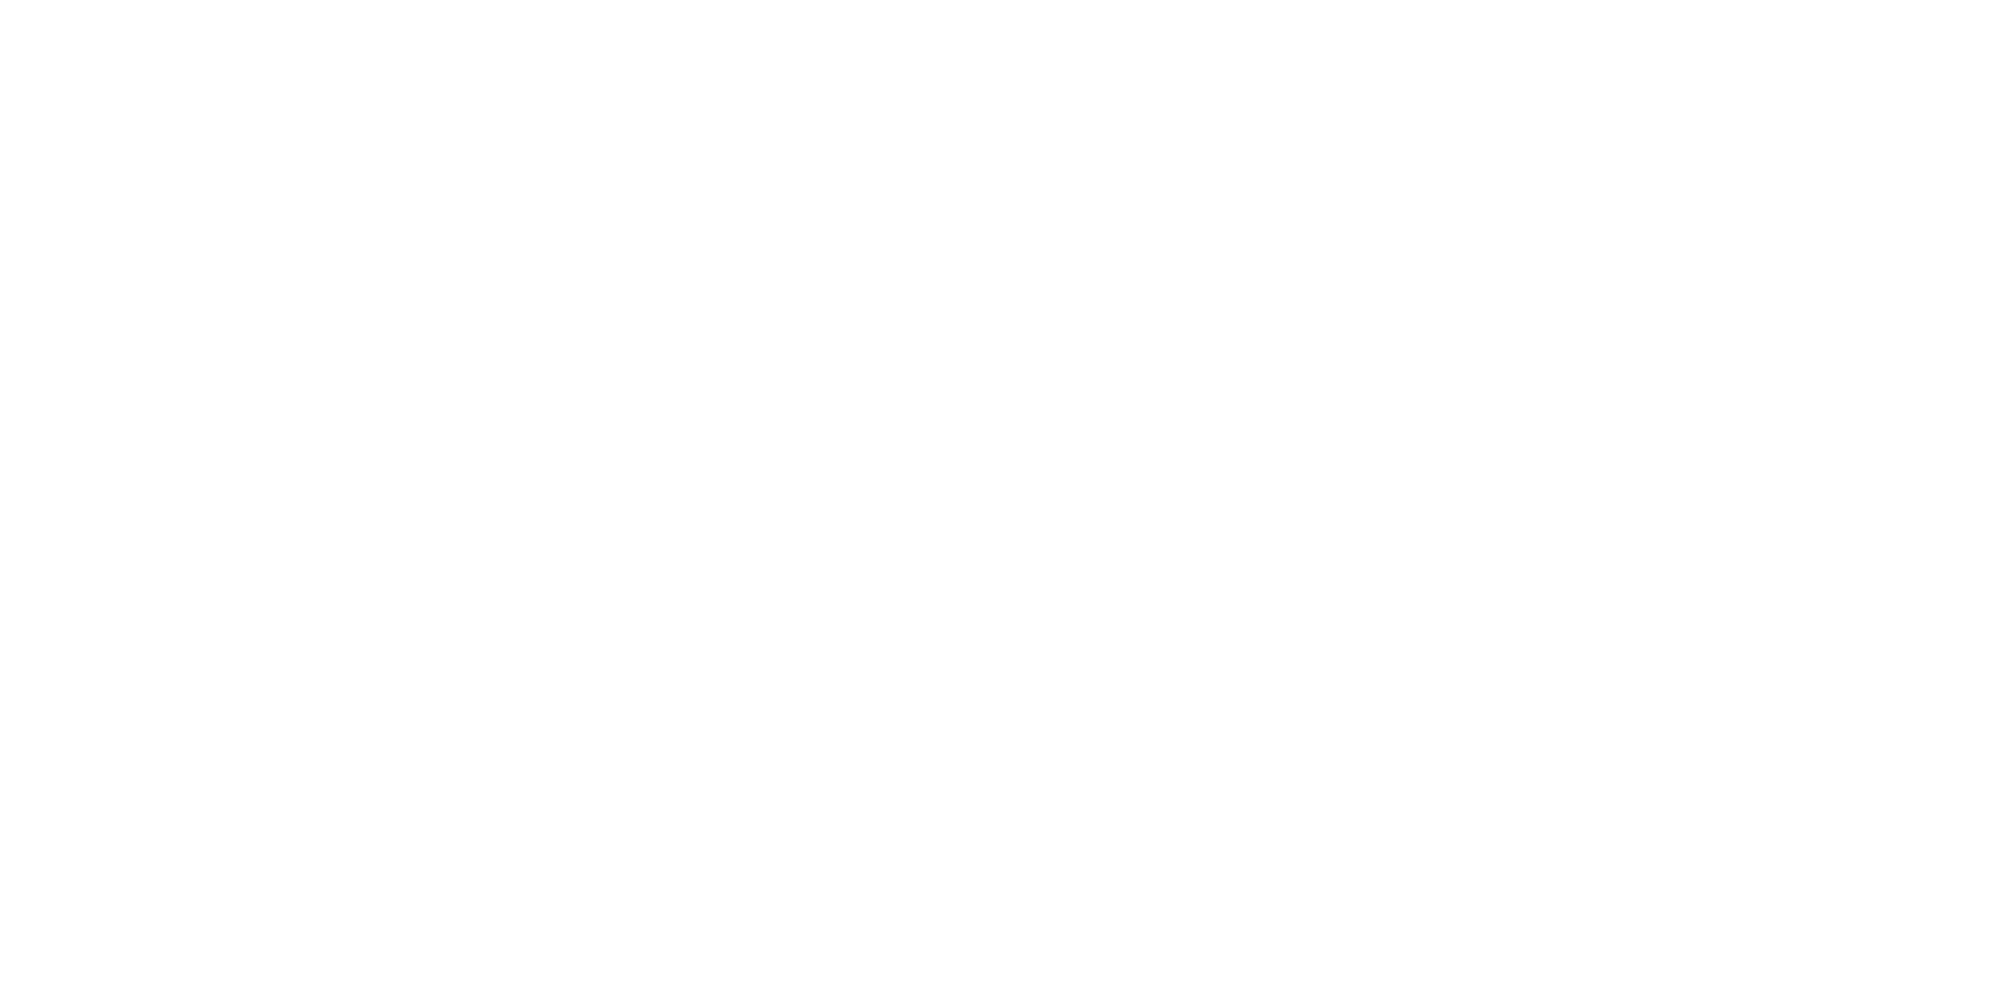

<IPython.core.display.Javascript object>


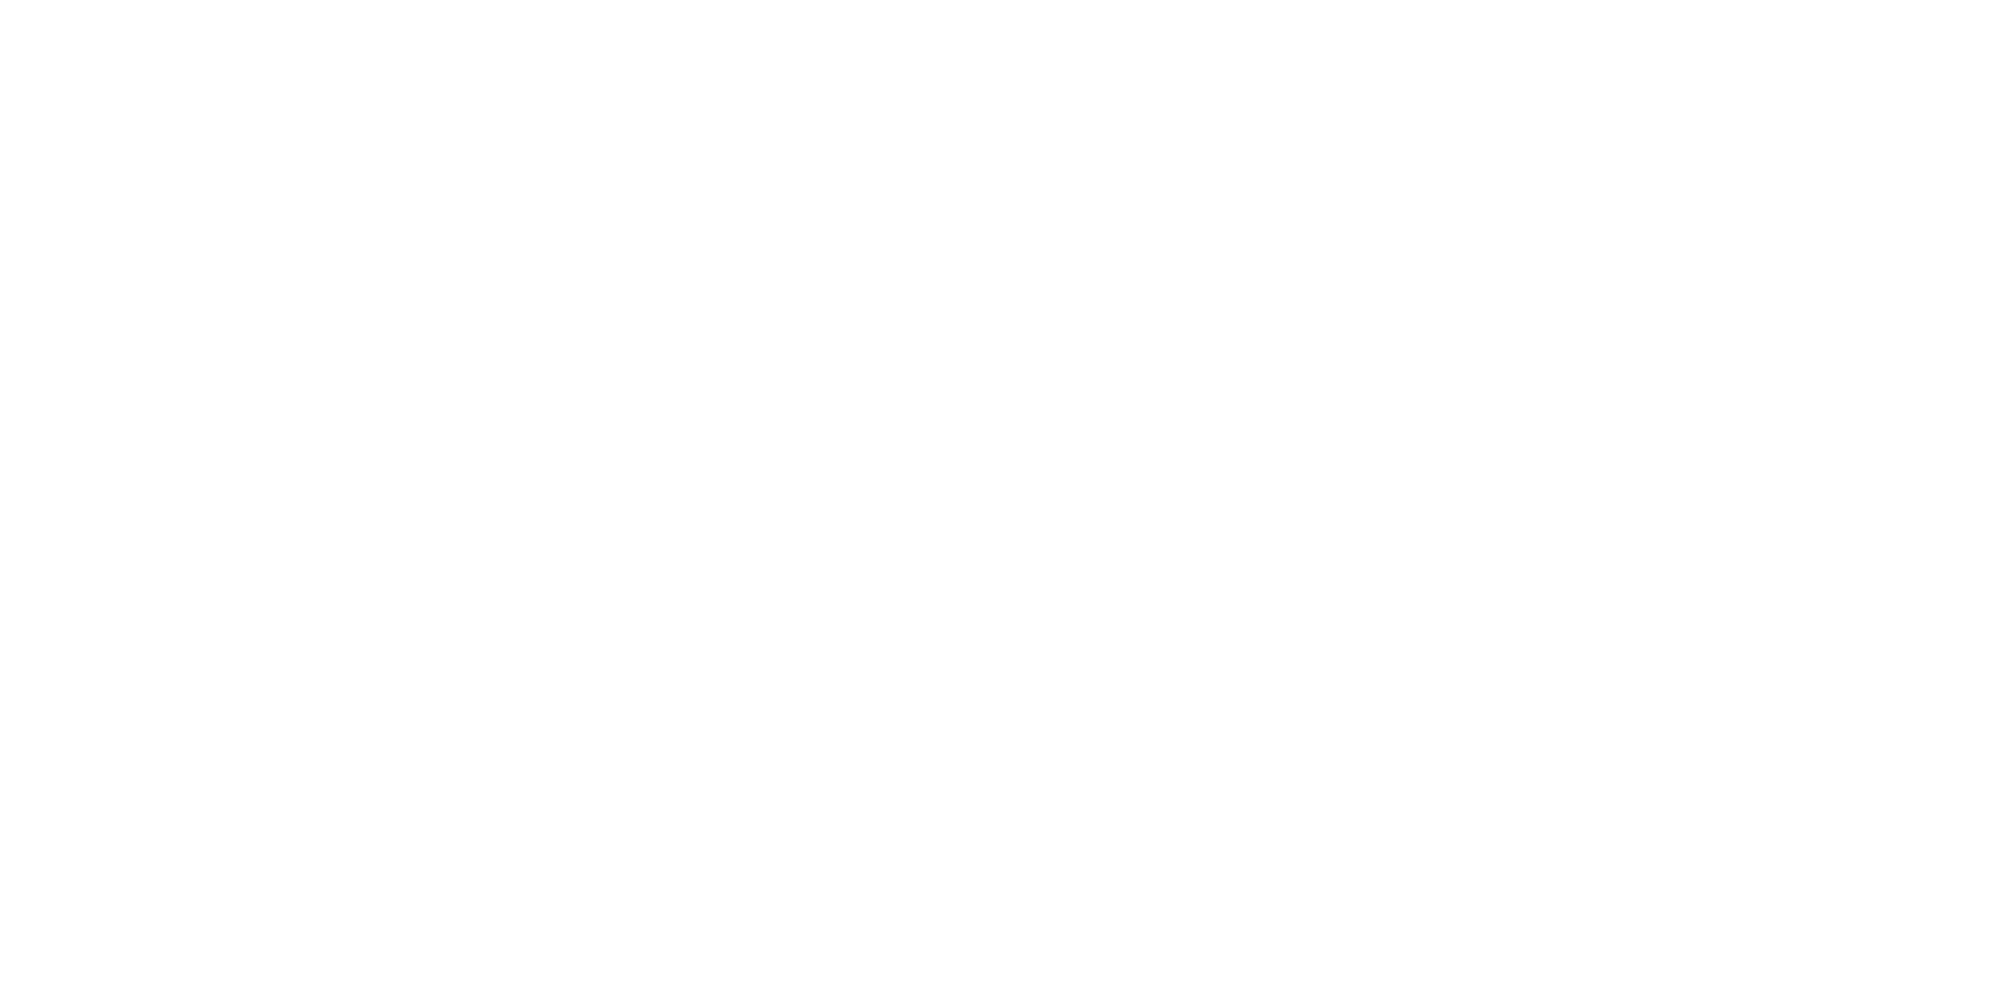

<IPython.core.display.Javascript object>


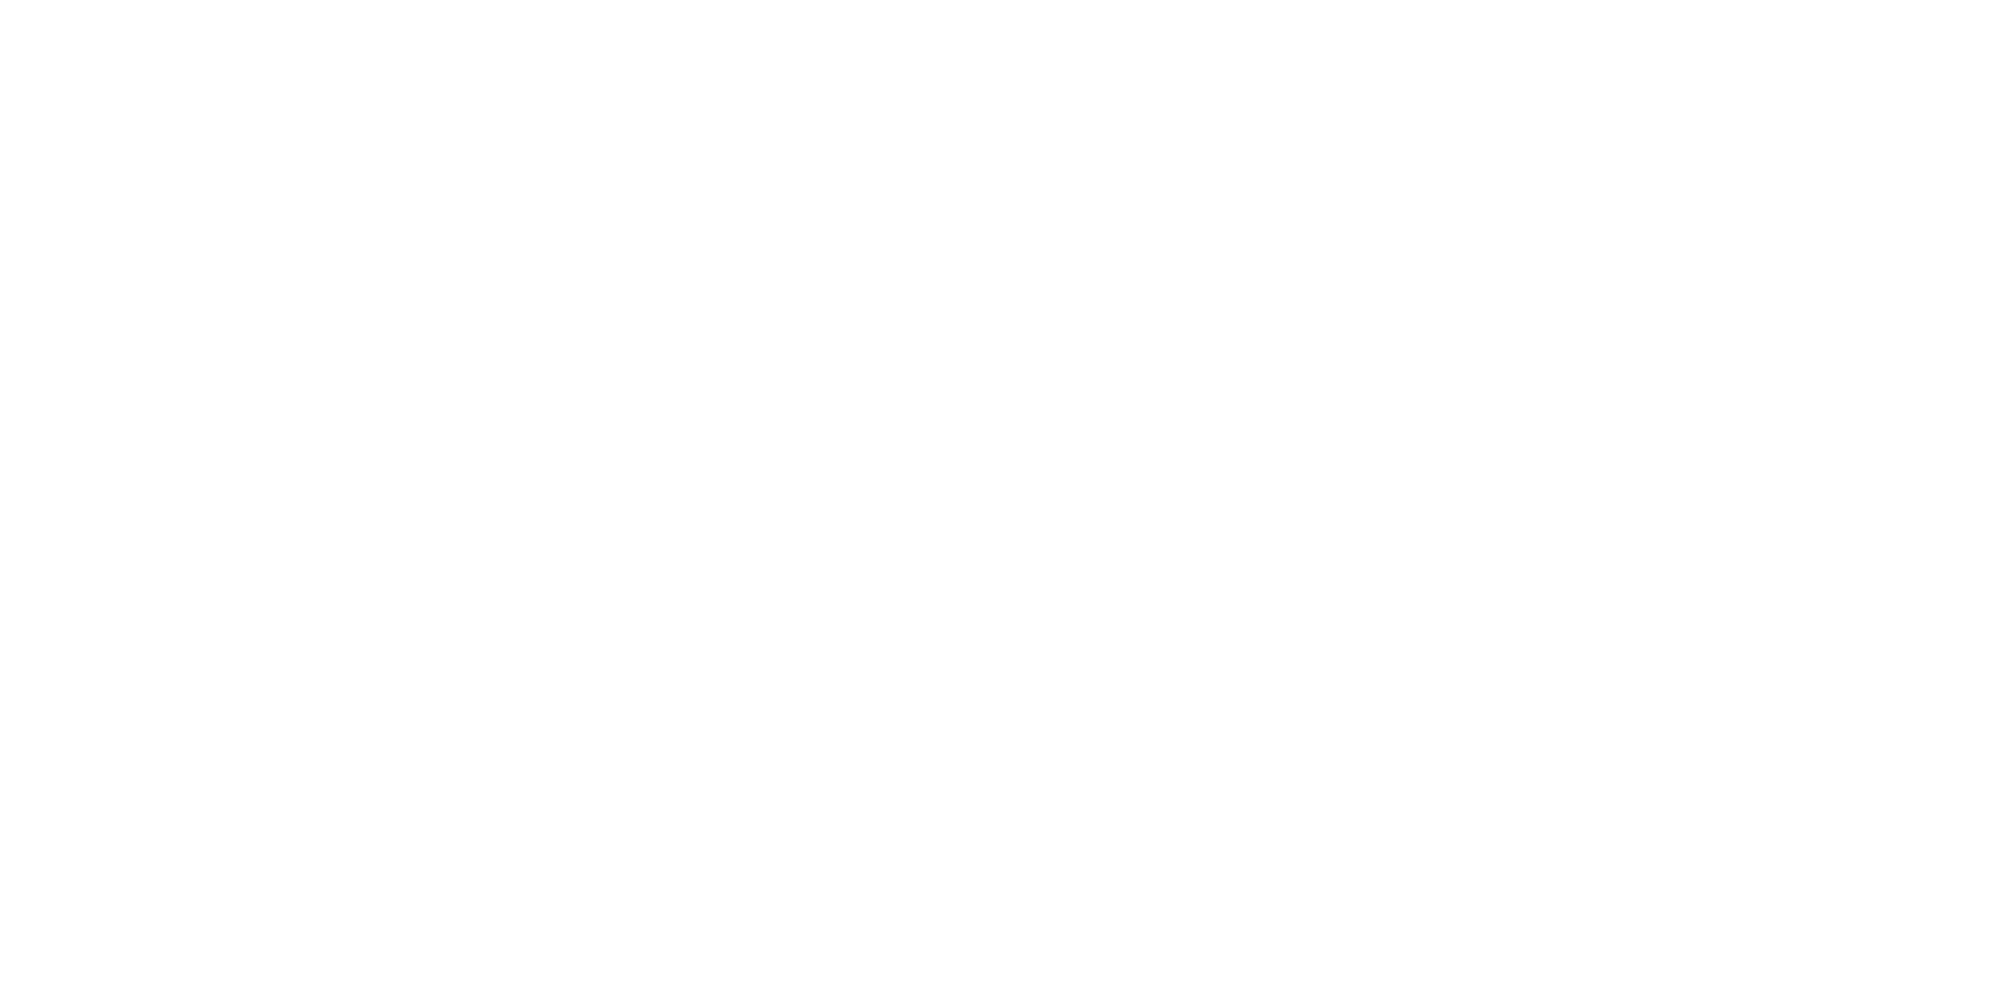

<IPython.core.display.Javascript object>


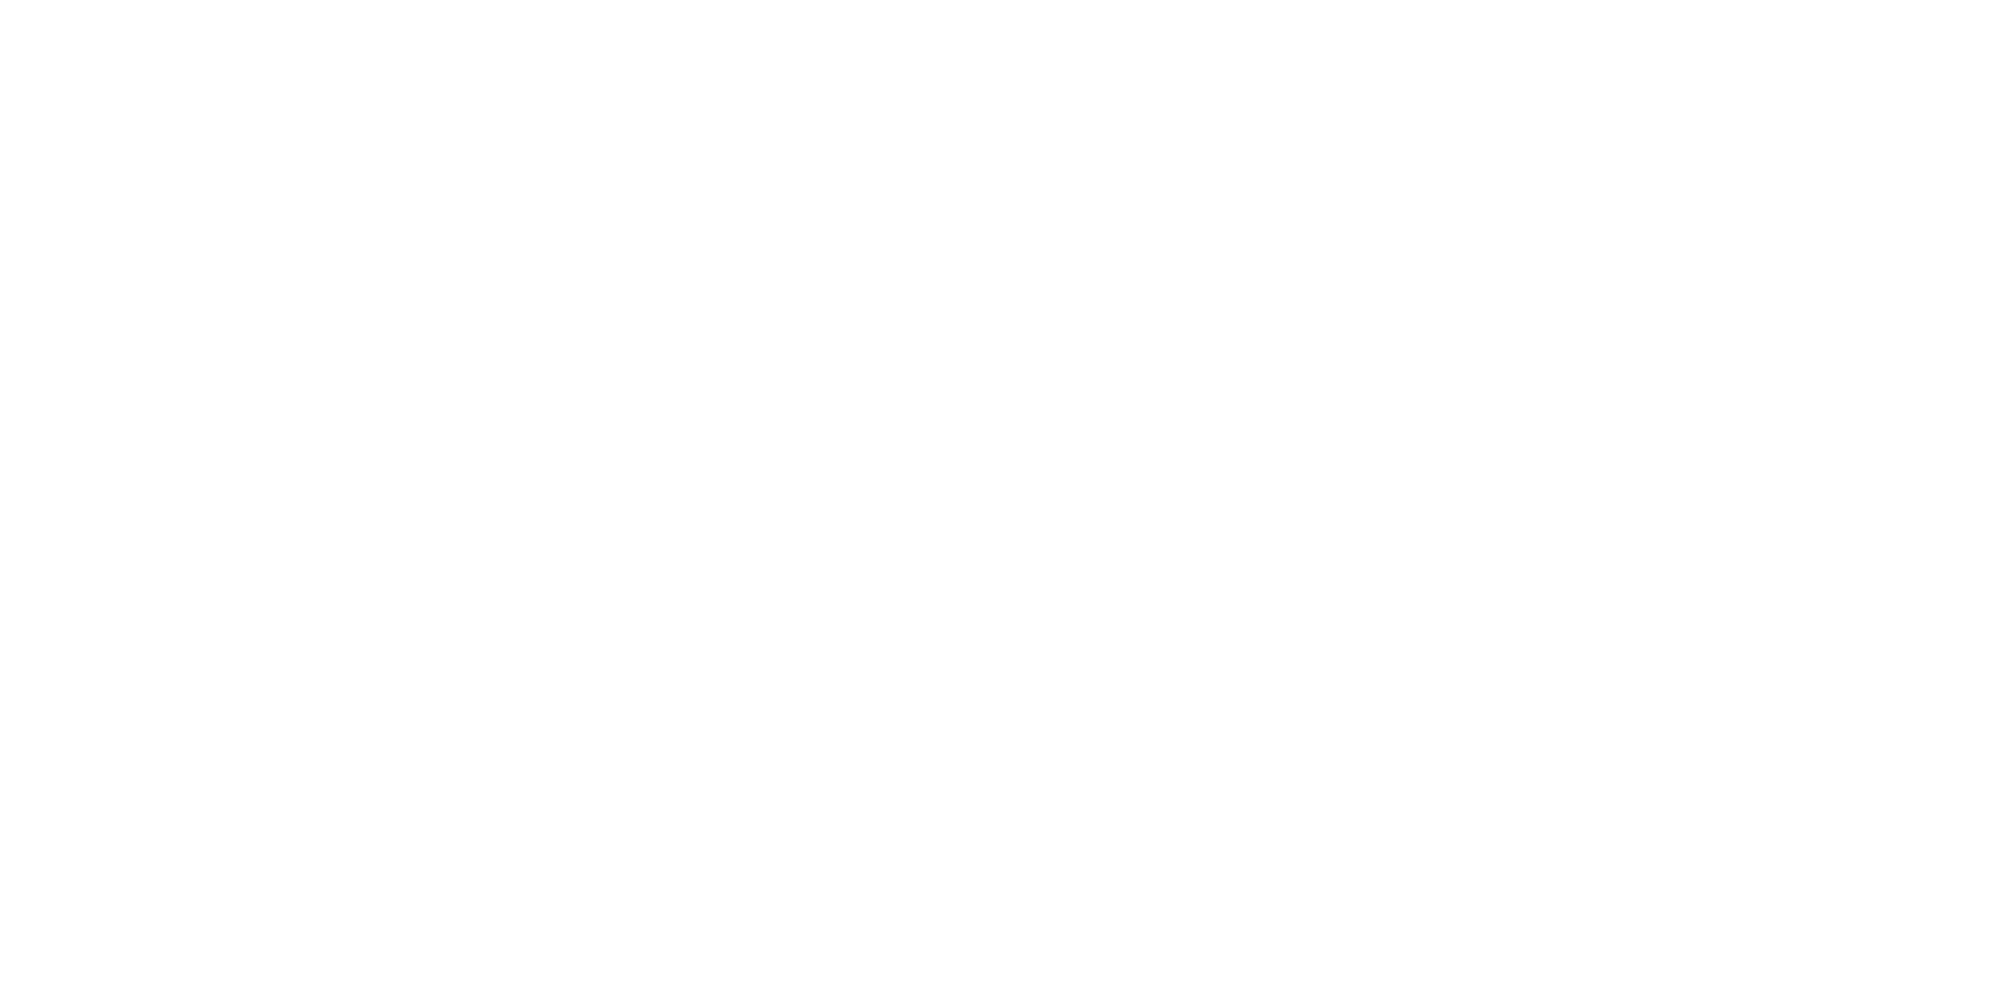

<IPython.core.display.Javascript object>


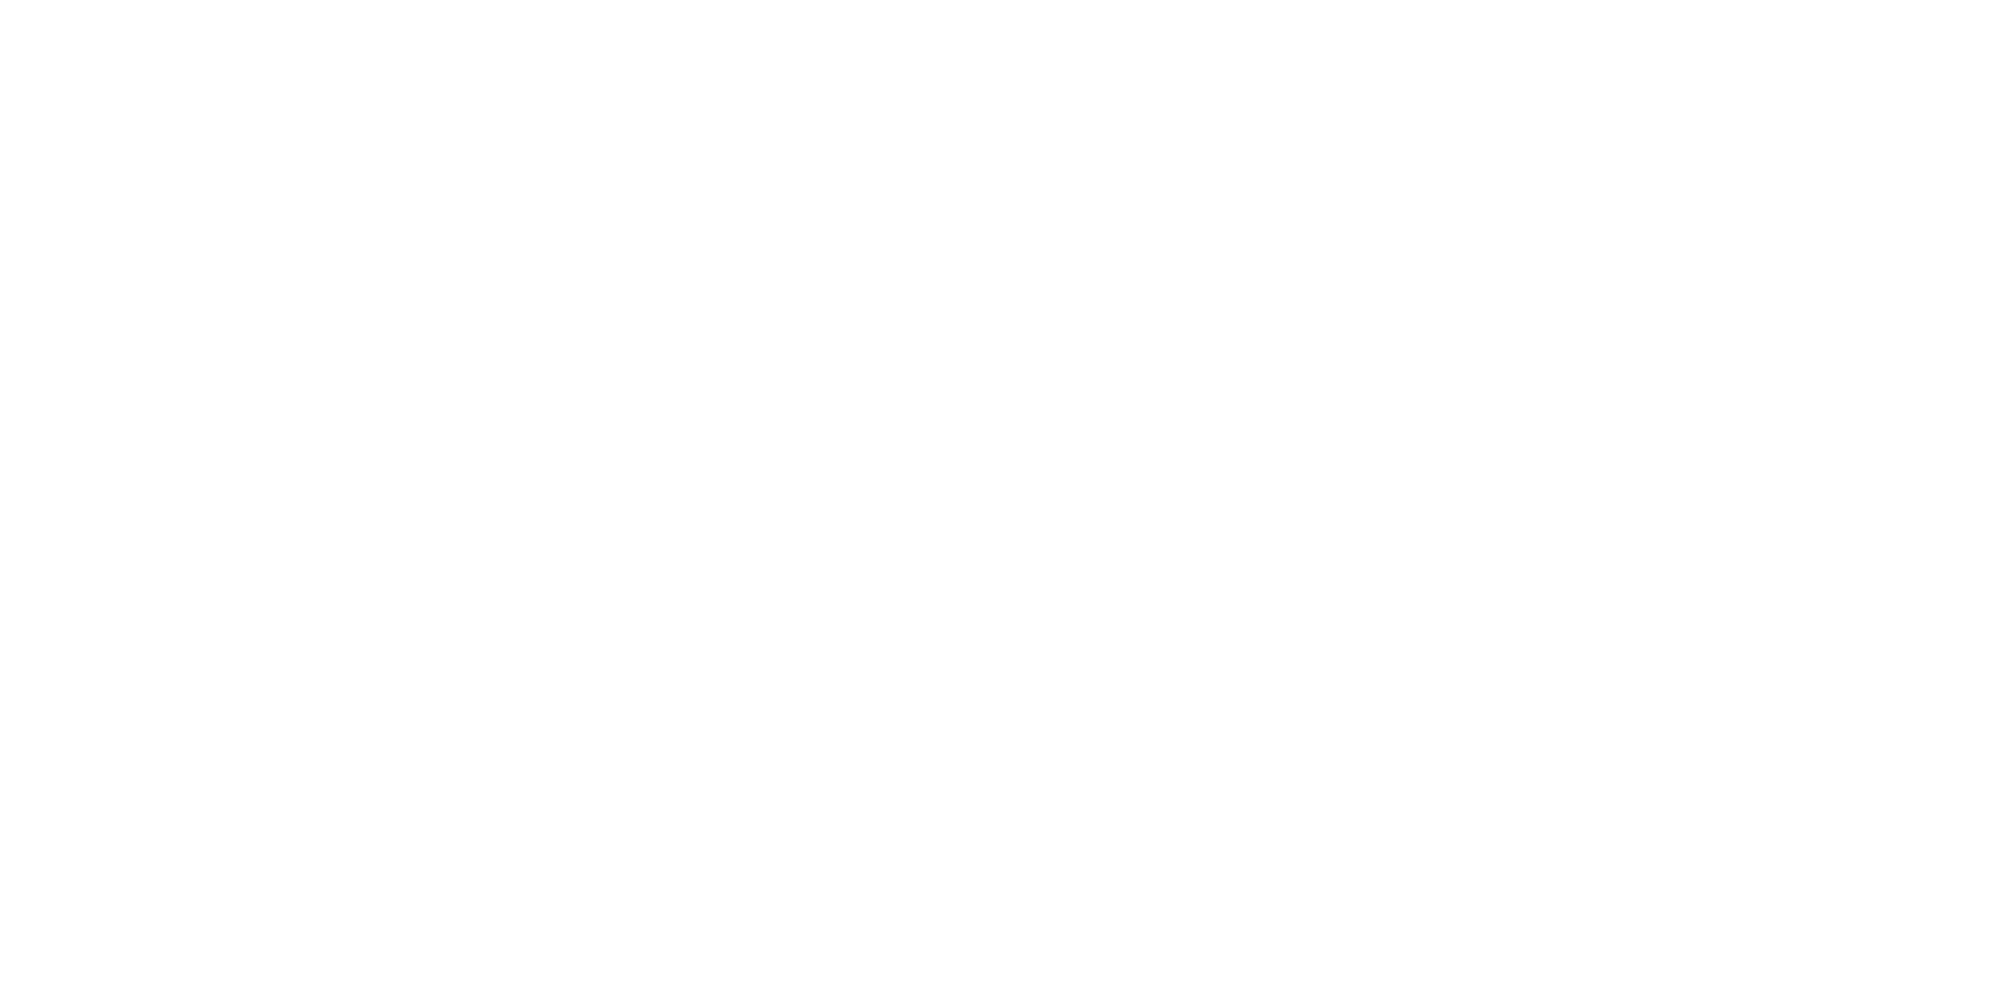

<IPython.core.display.Javascript object>


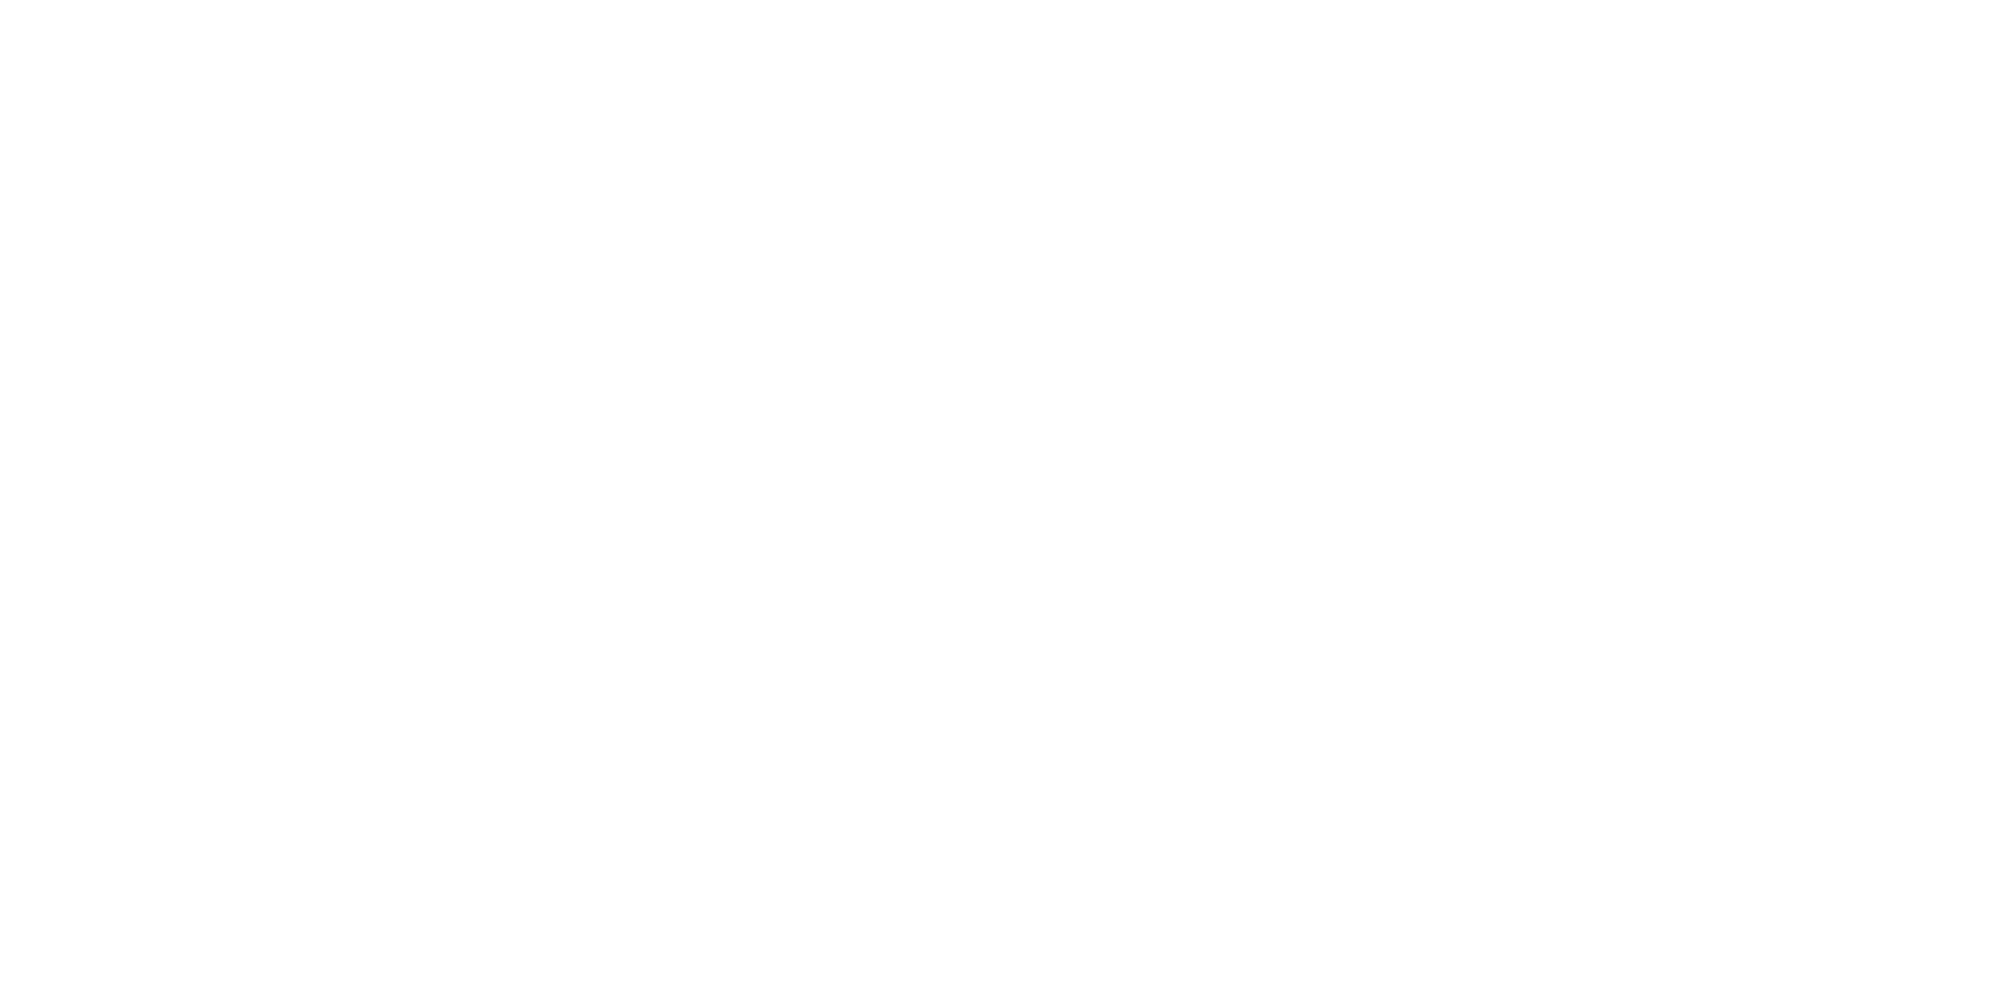

<IPython.core.display.Javascript object>


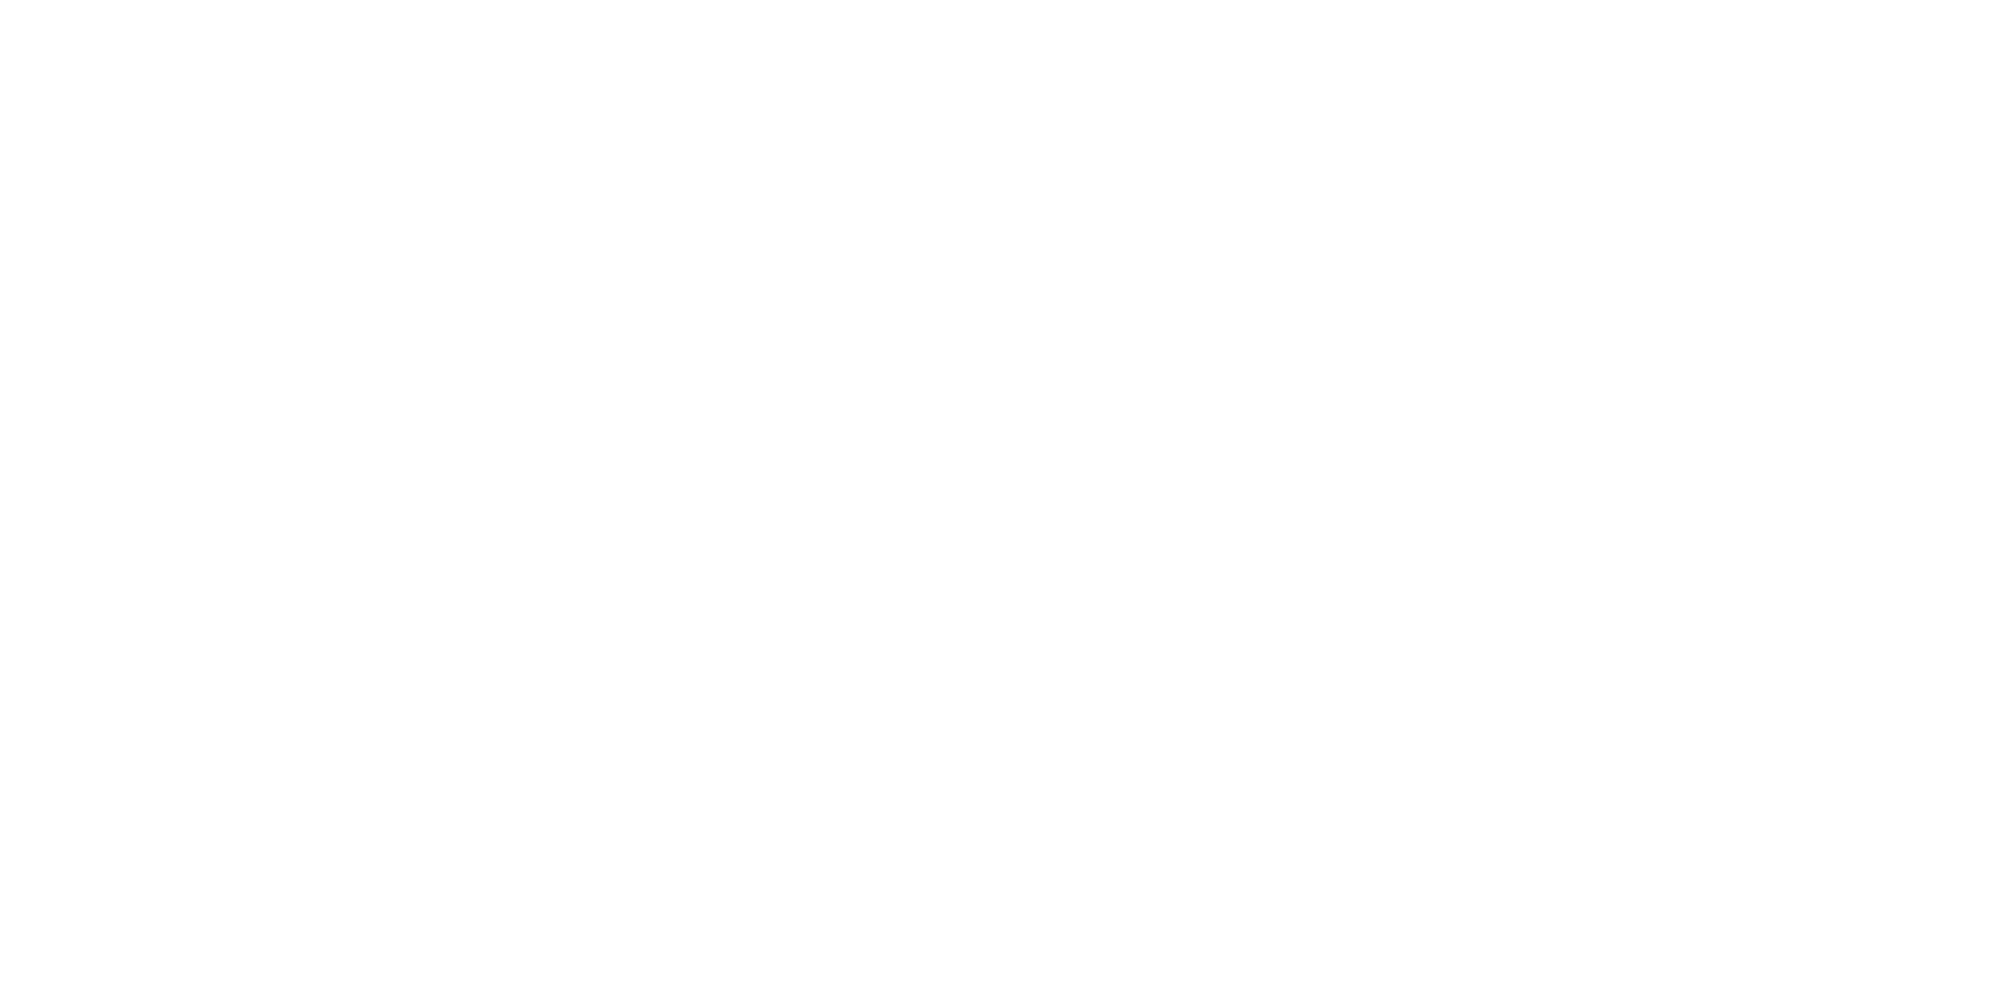

<IPython.core.display.Javascript object>


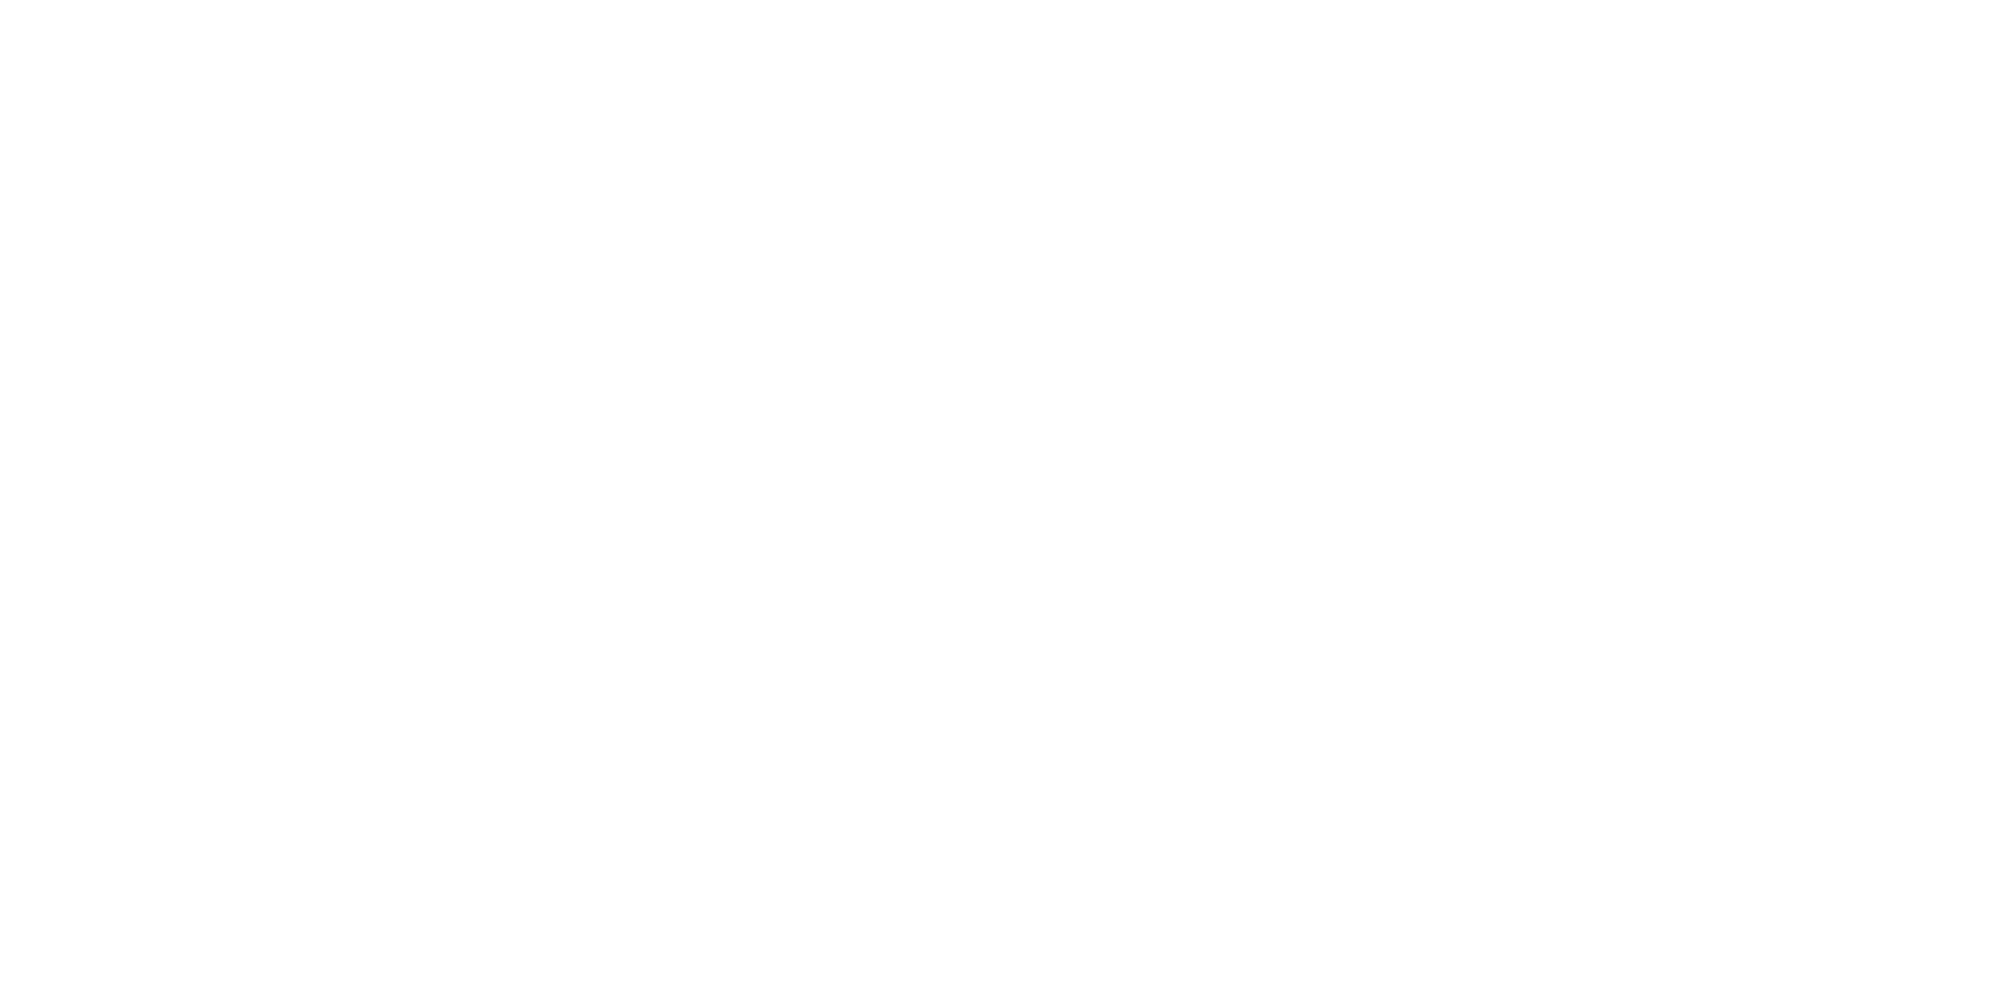

<IPython.core.display.Javascript object>


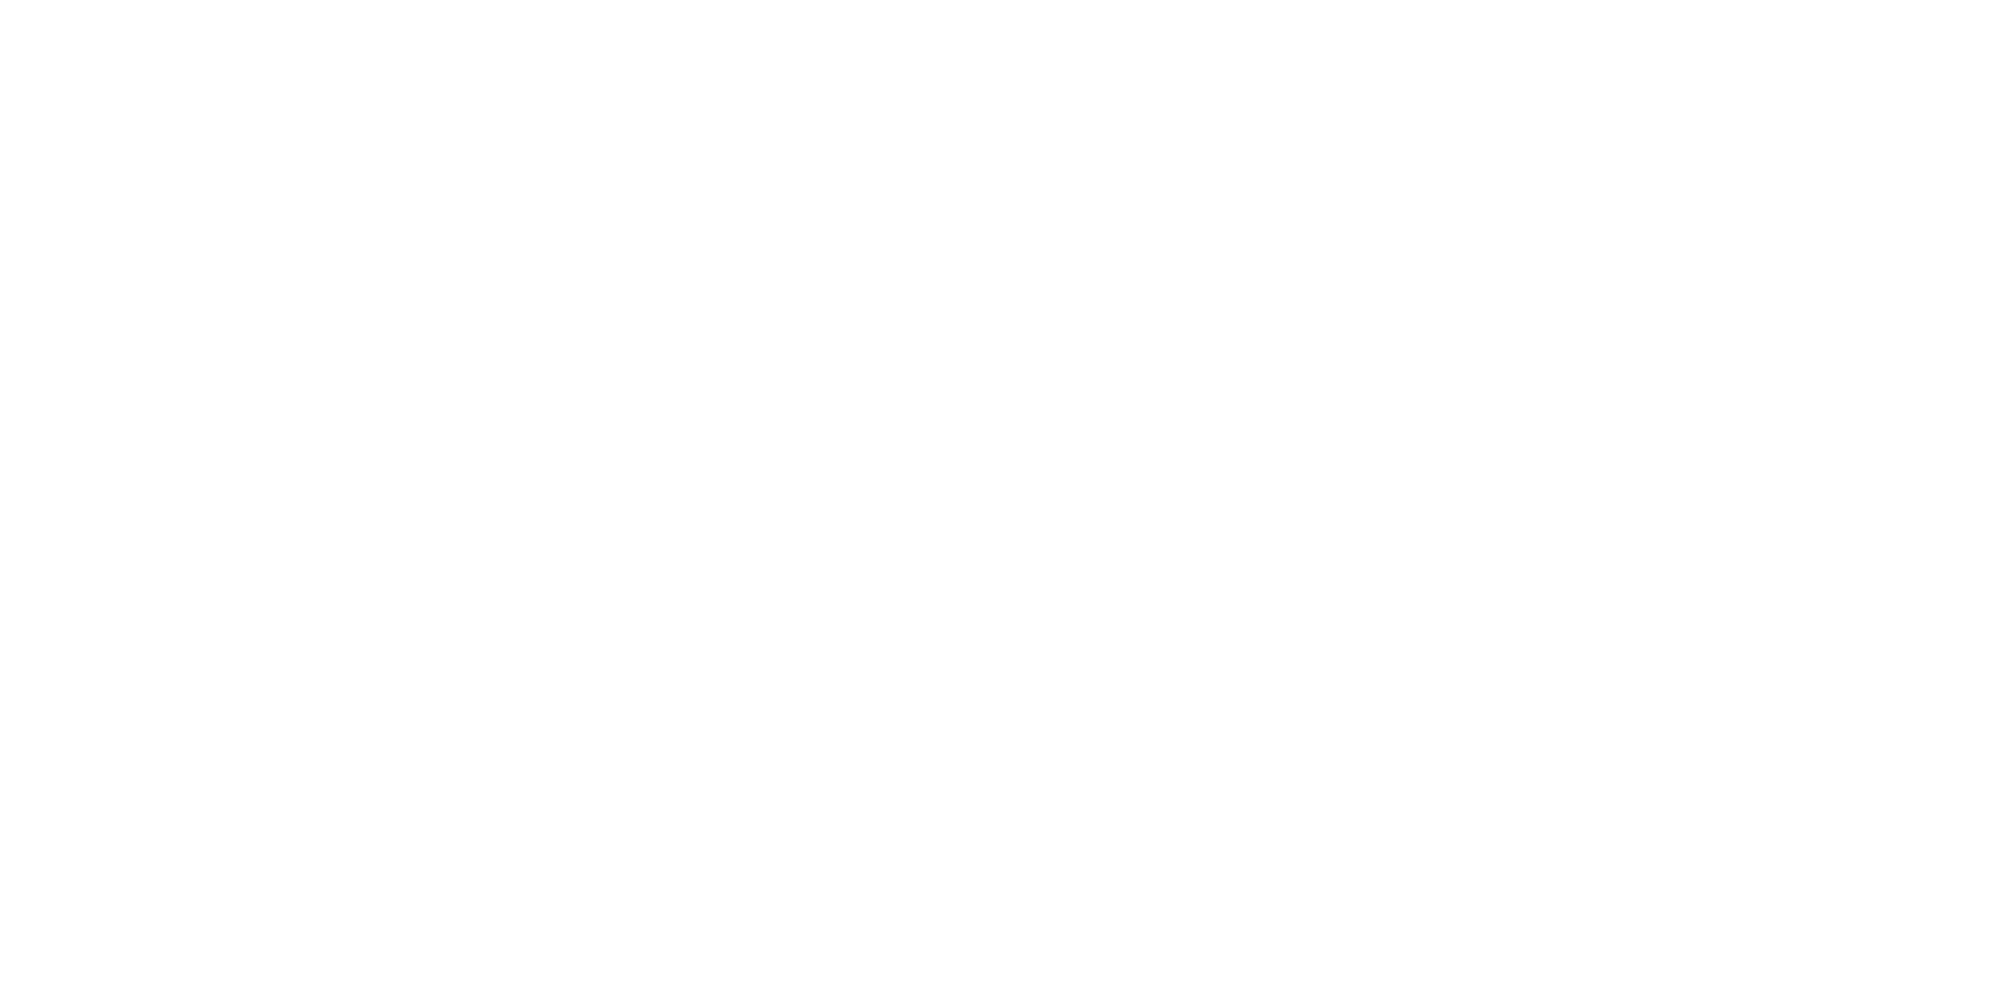

<IPython.core.display.Javascript object>


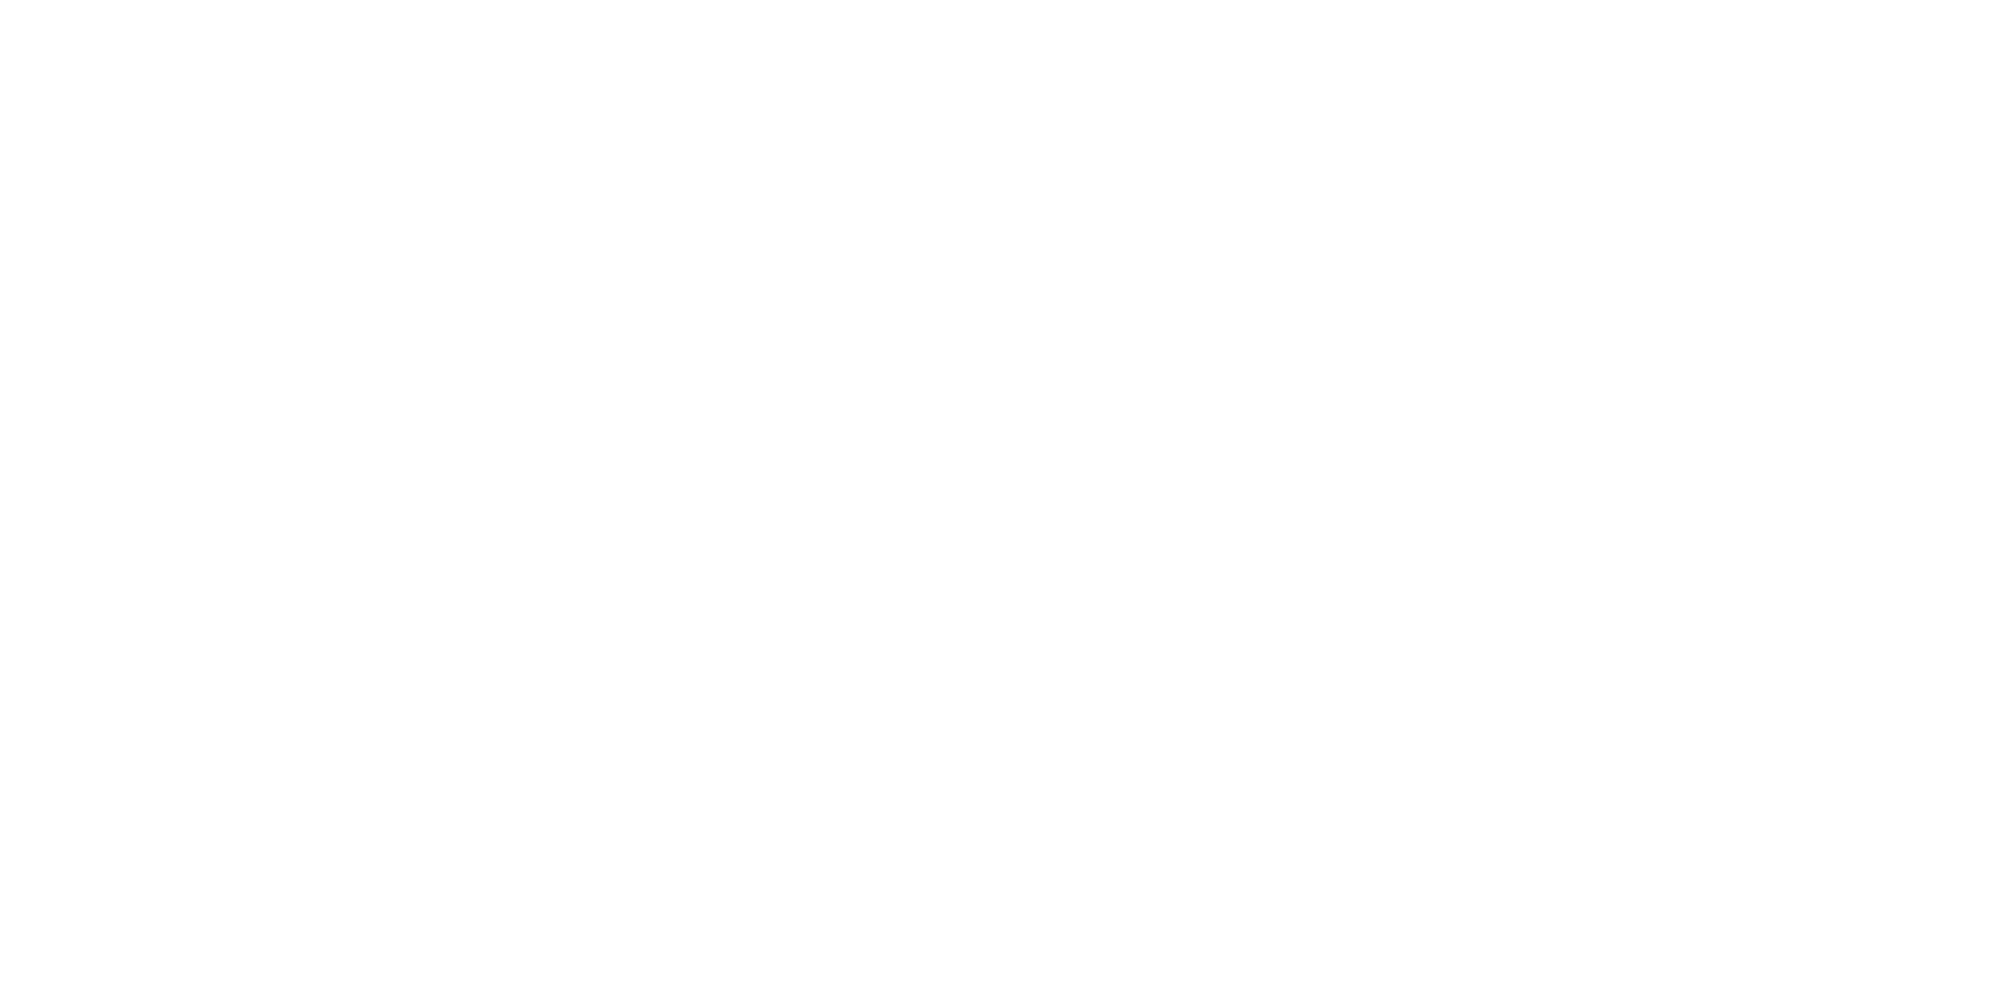

<IPython.core.display.Javascript object>


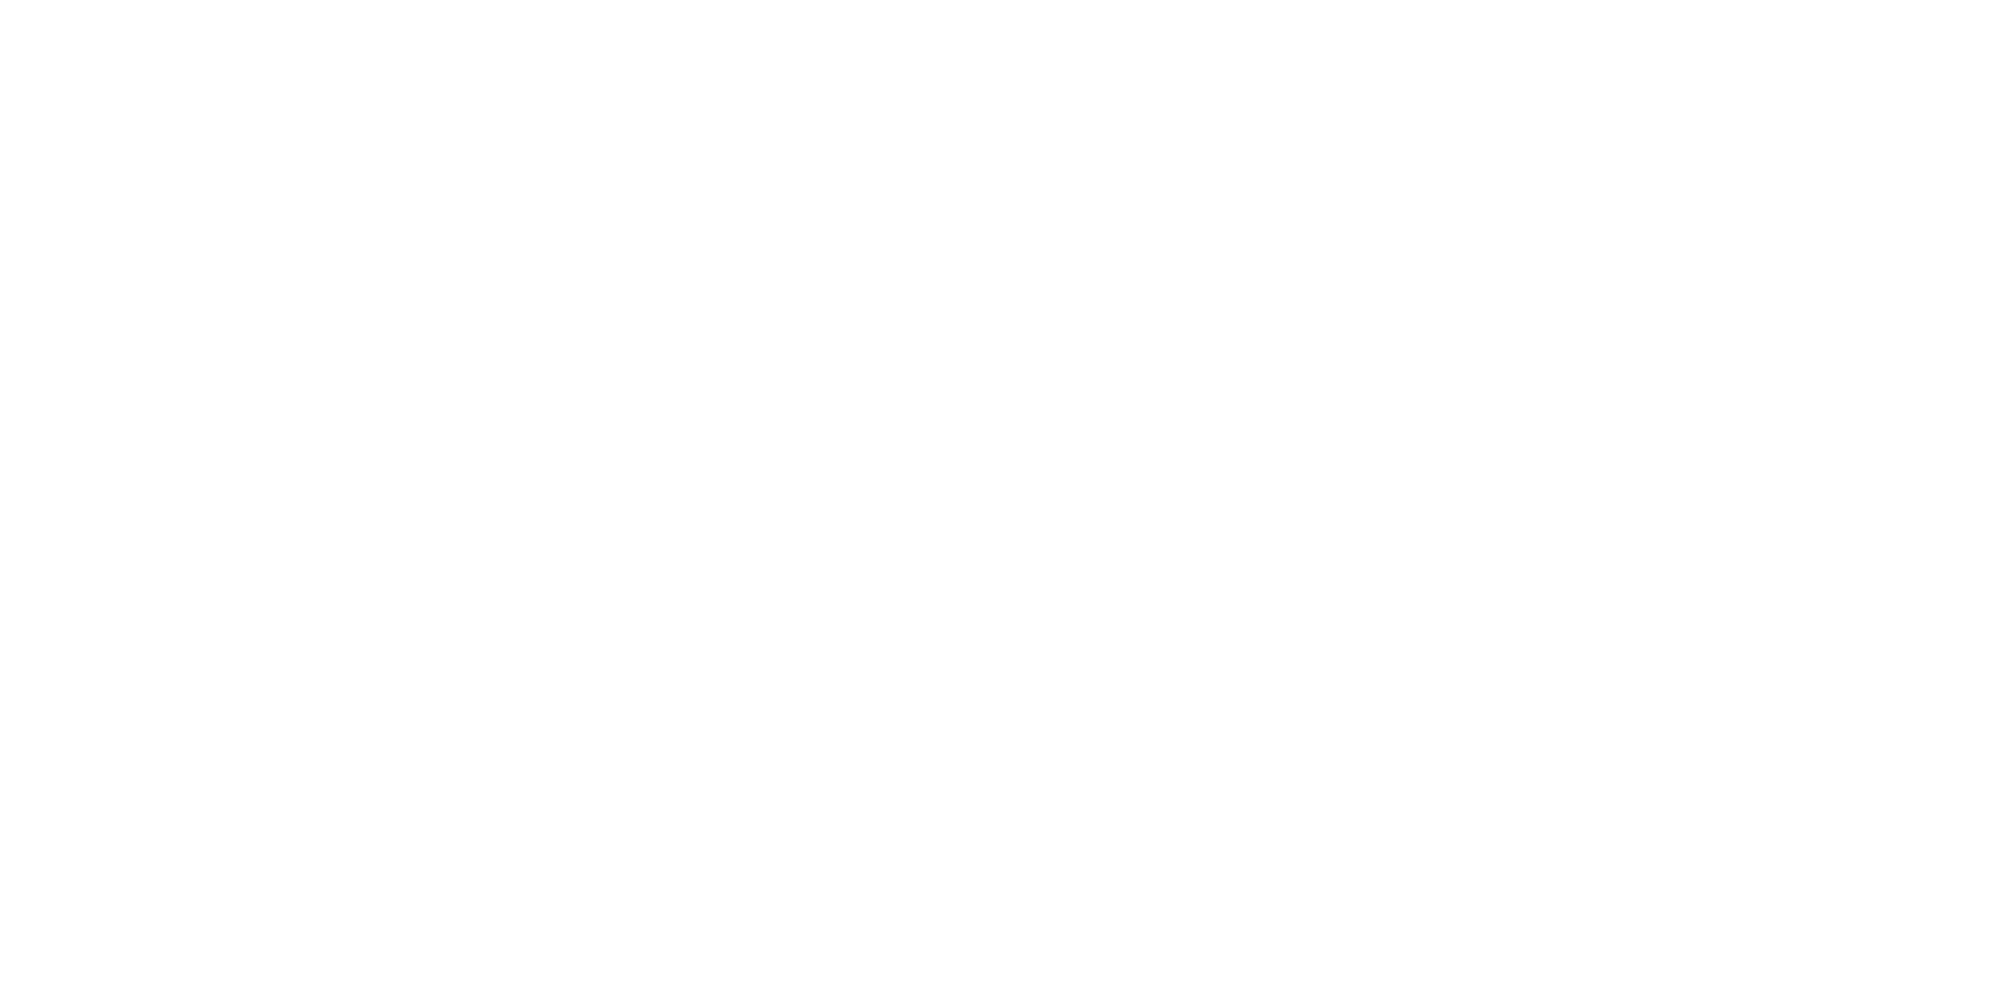

<IPython.core.display.Javascript object>


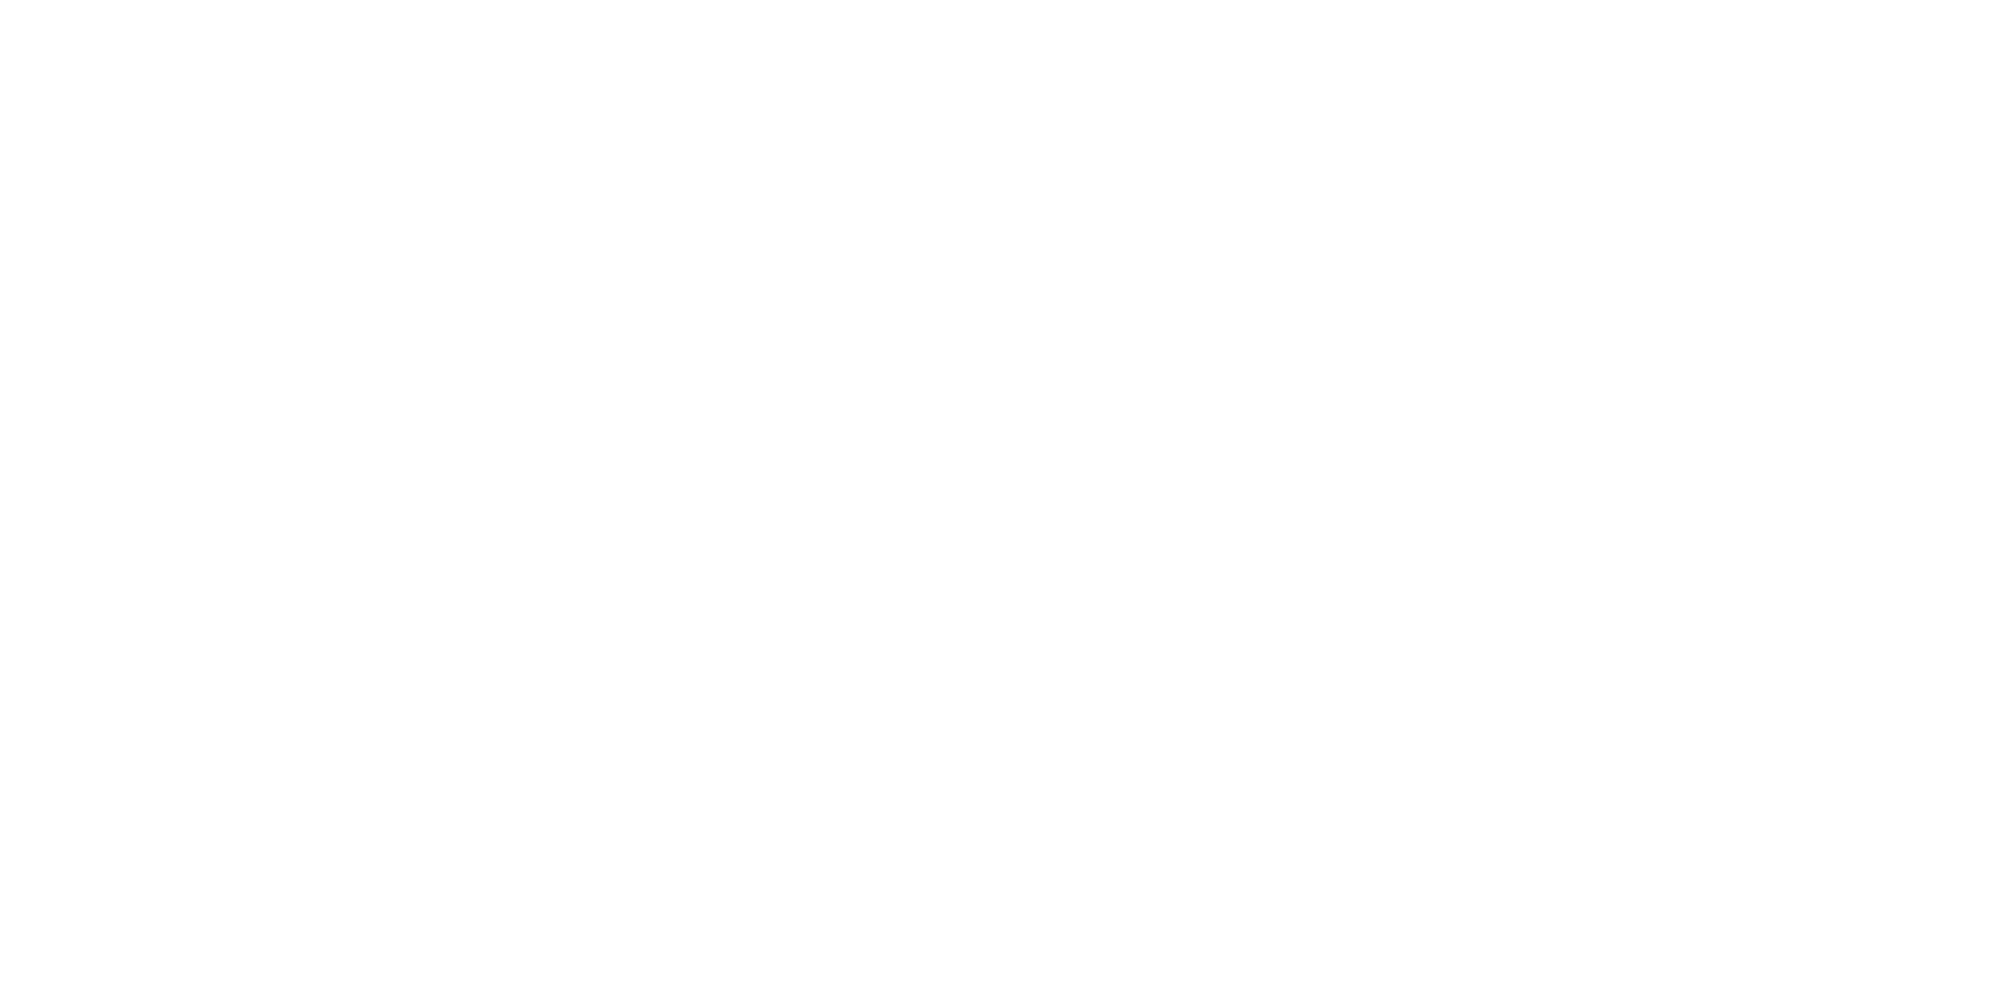

<IPython.core.display.Javascript object>


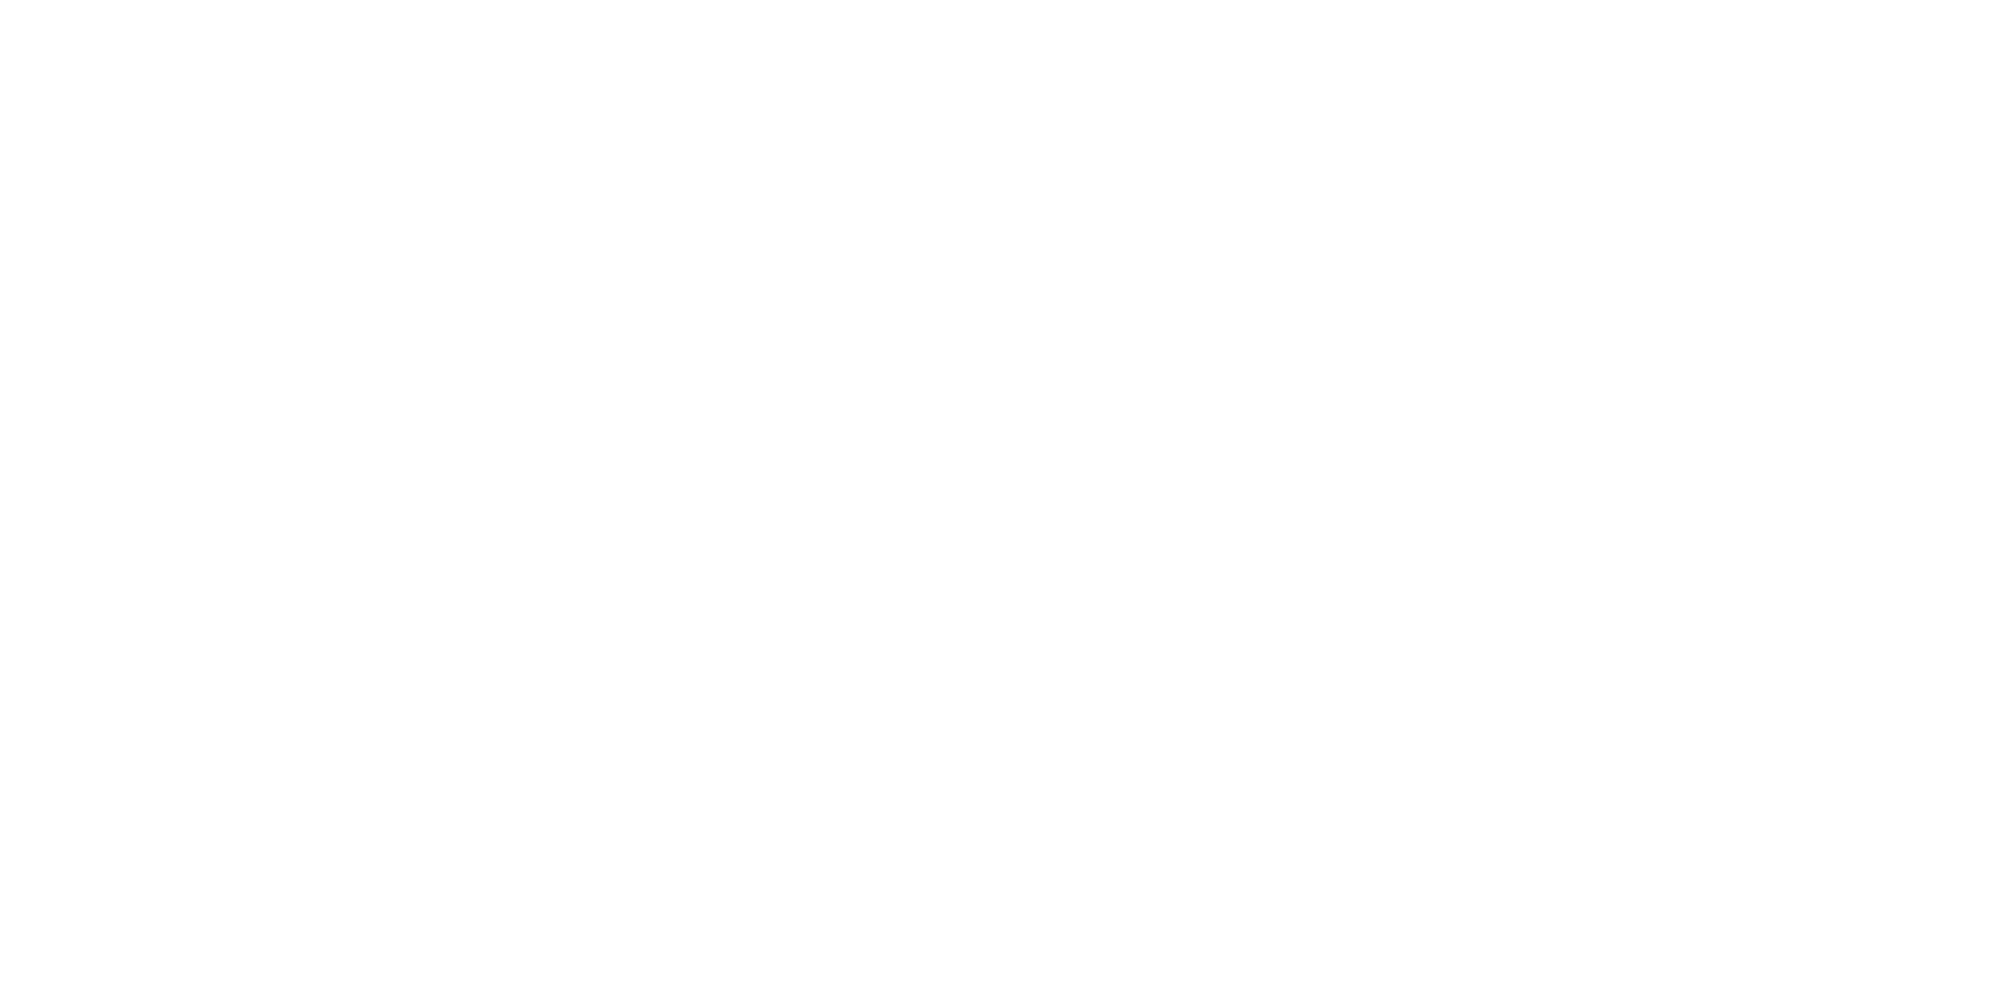

<IPython.core.display.Javascript object>


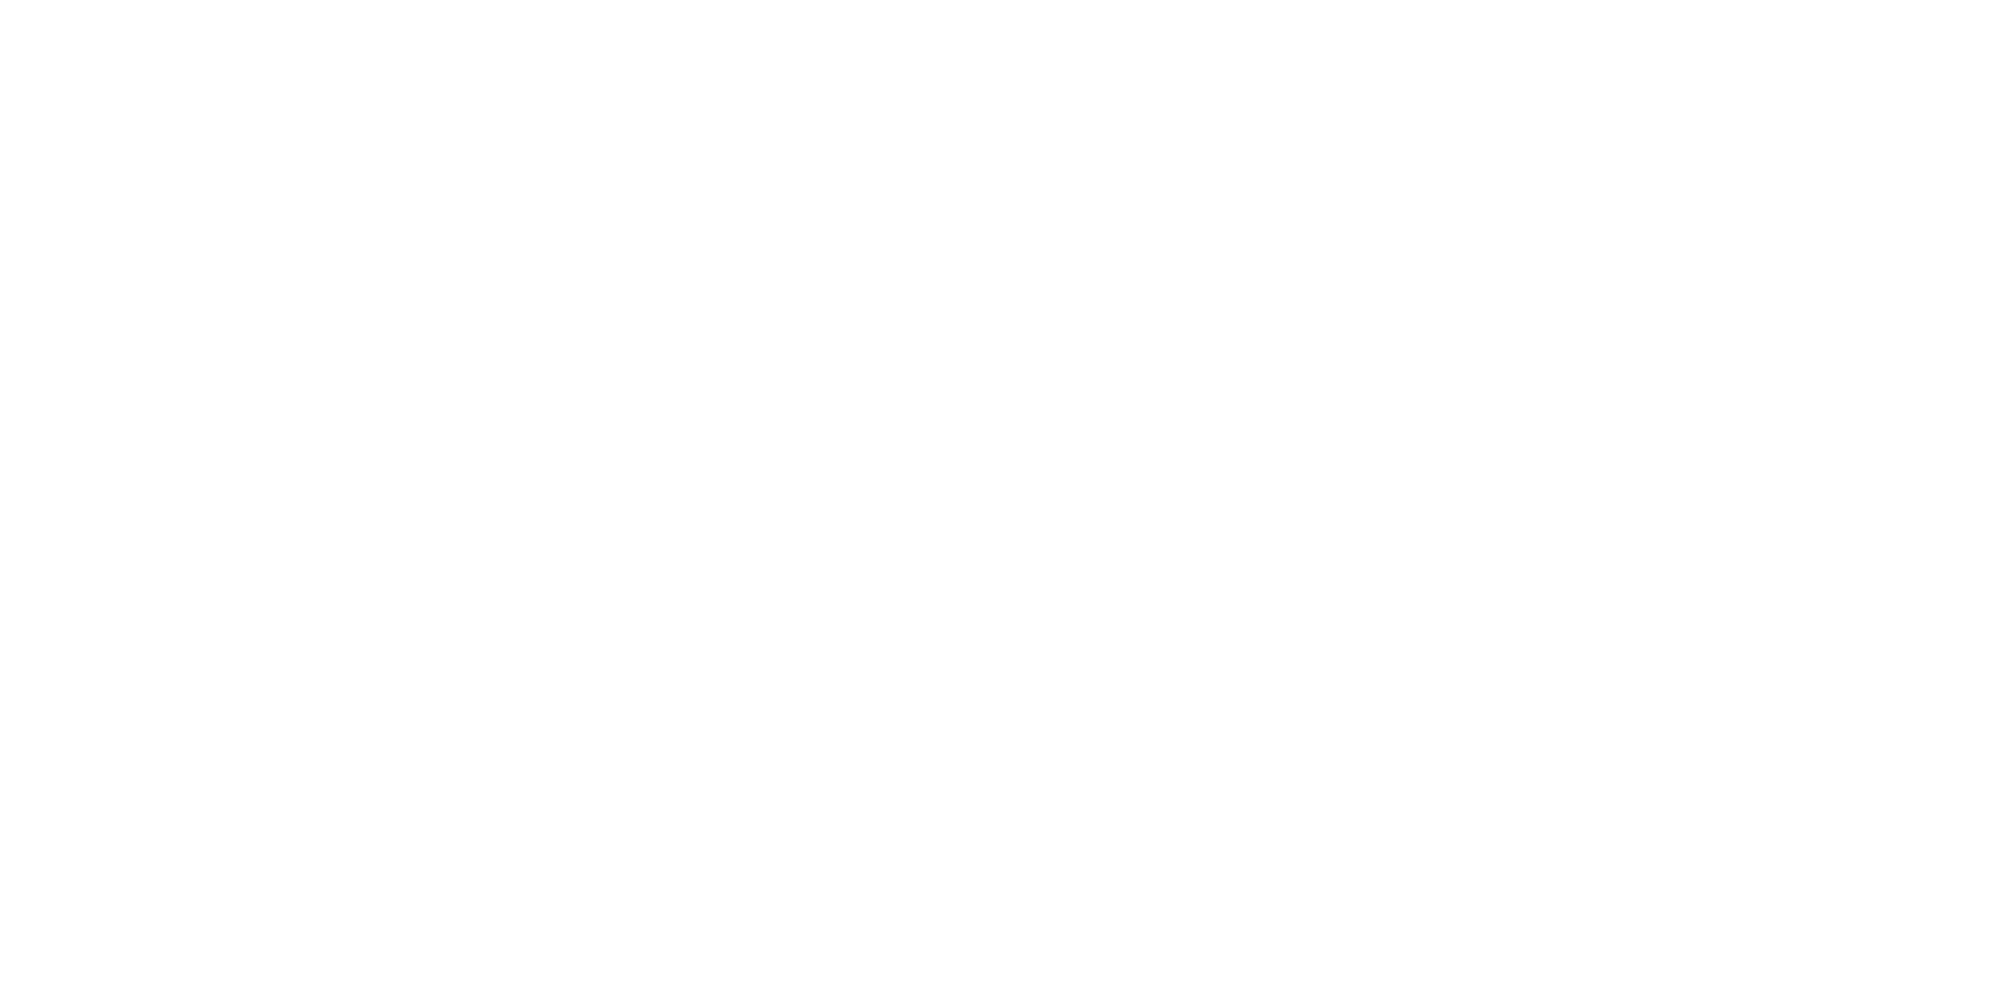

<IPython.core.display.Javascript object>


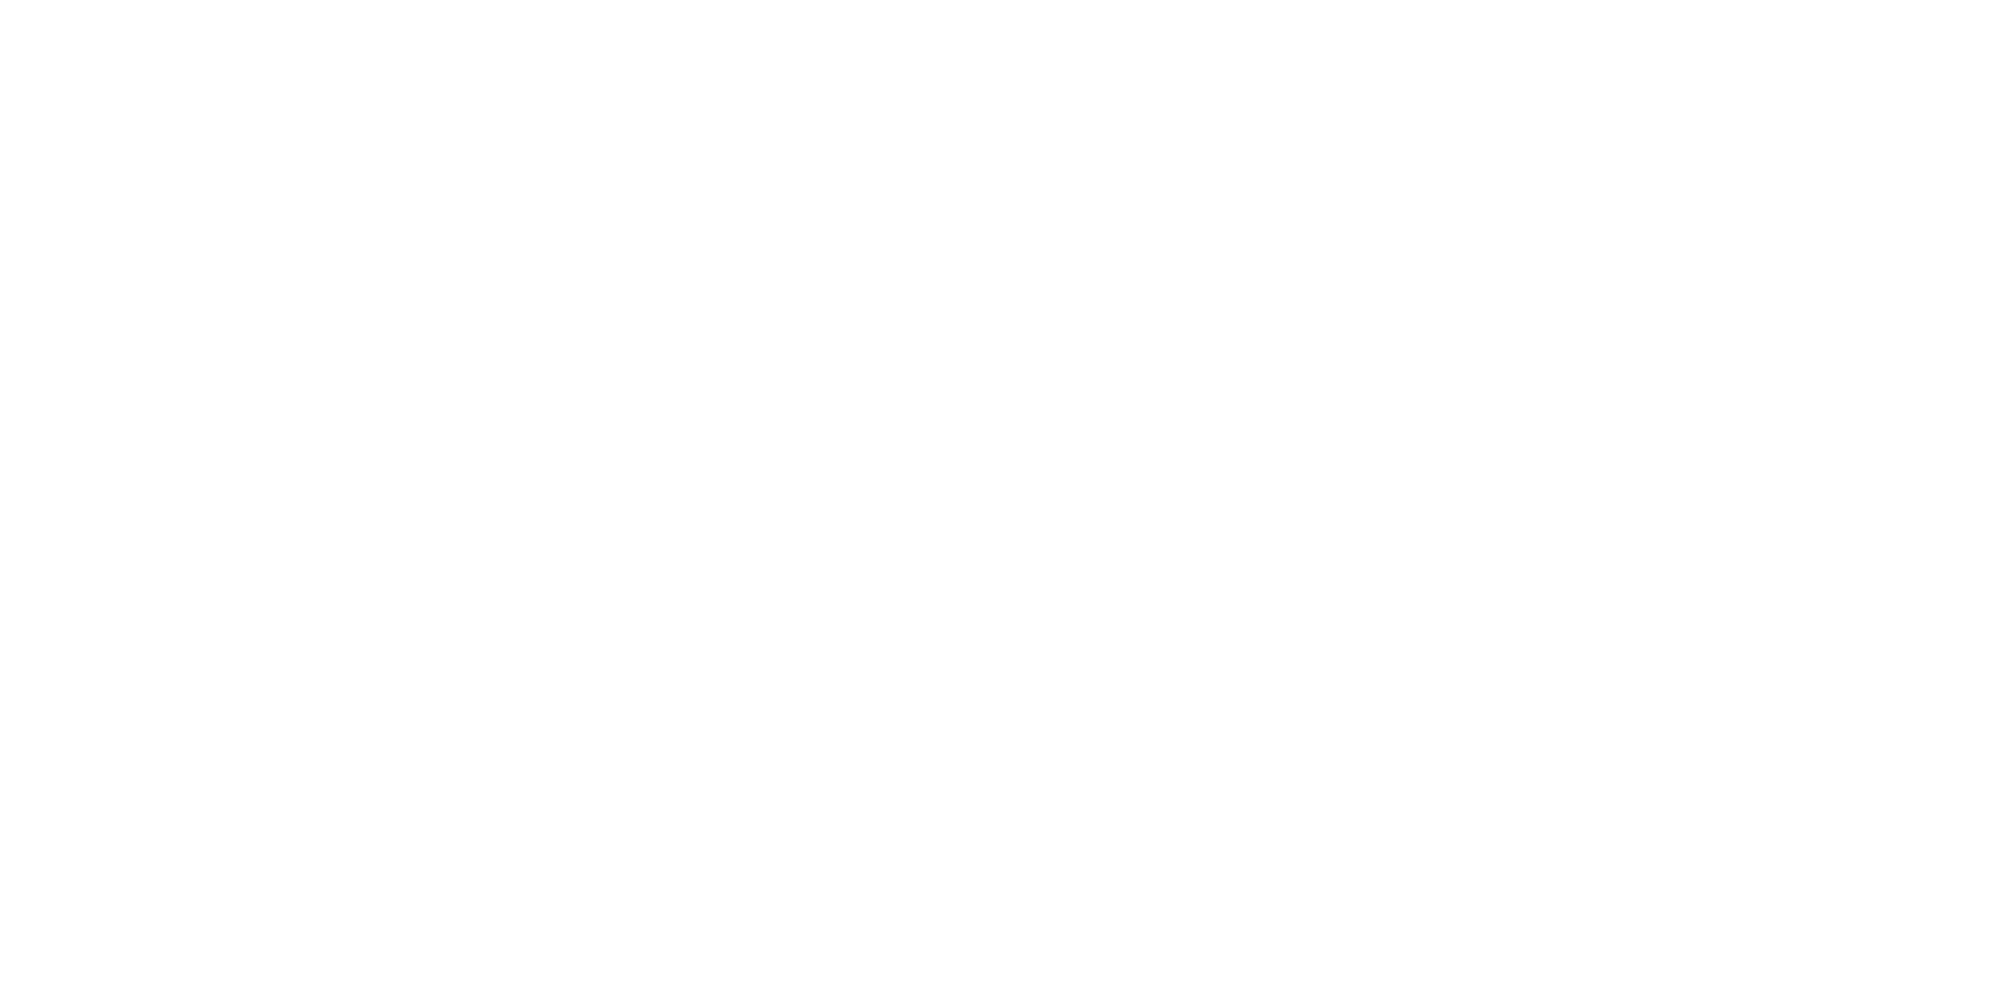

<IPython.core.display.Javascript object>


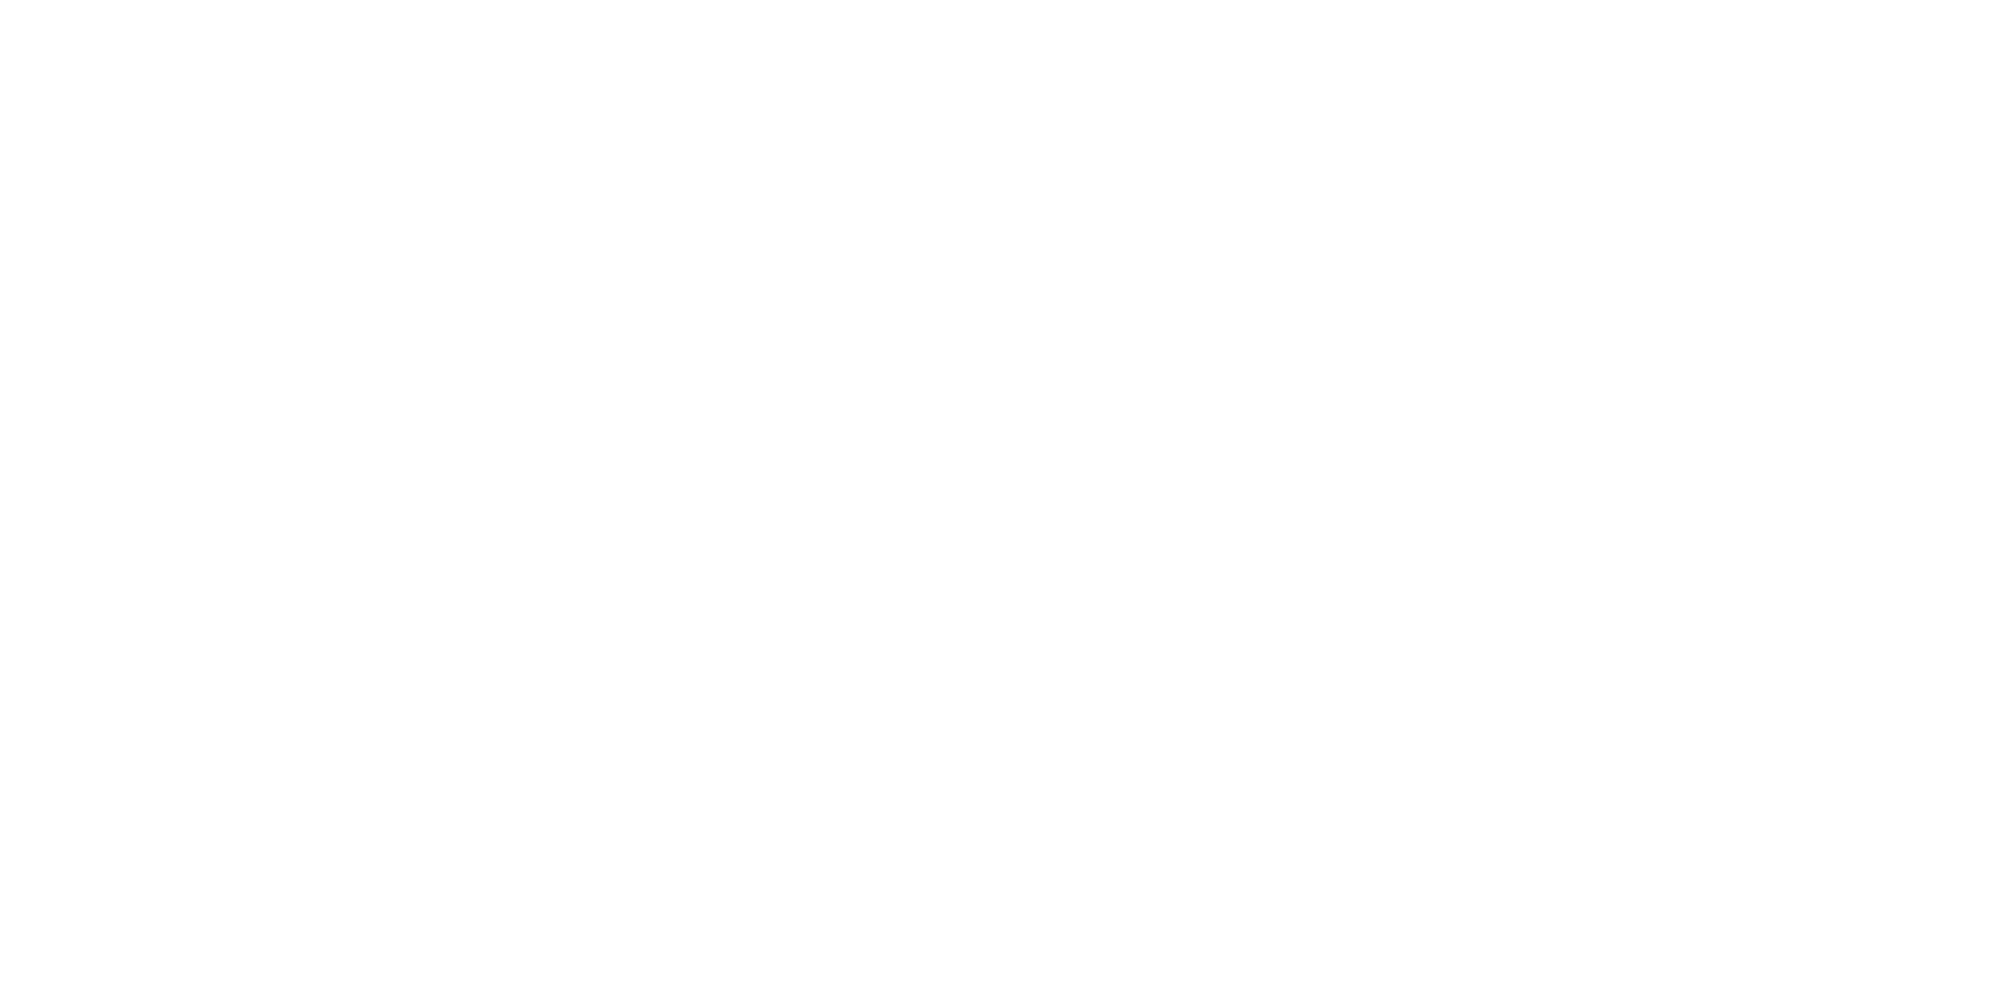

<IPython.core.display.Javascript object>


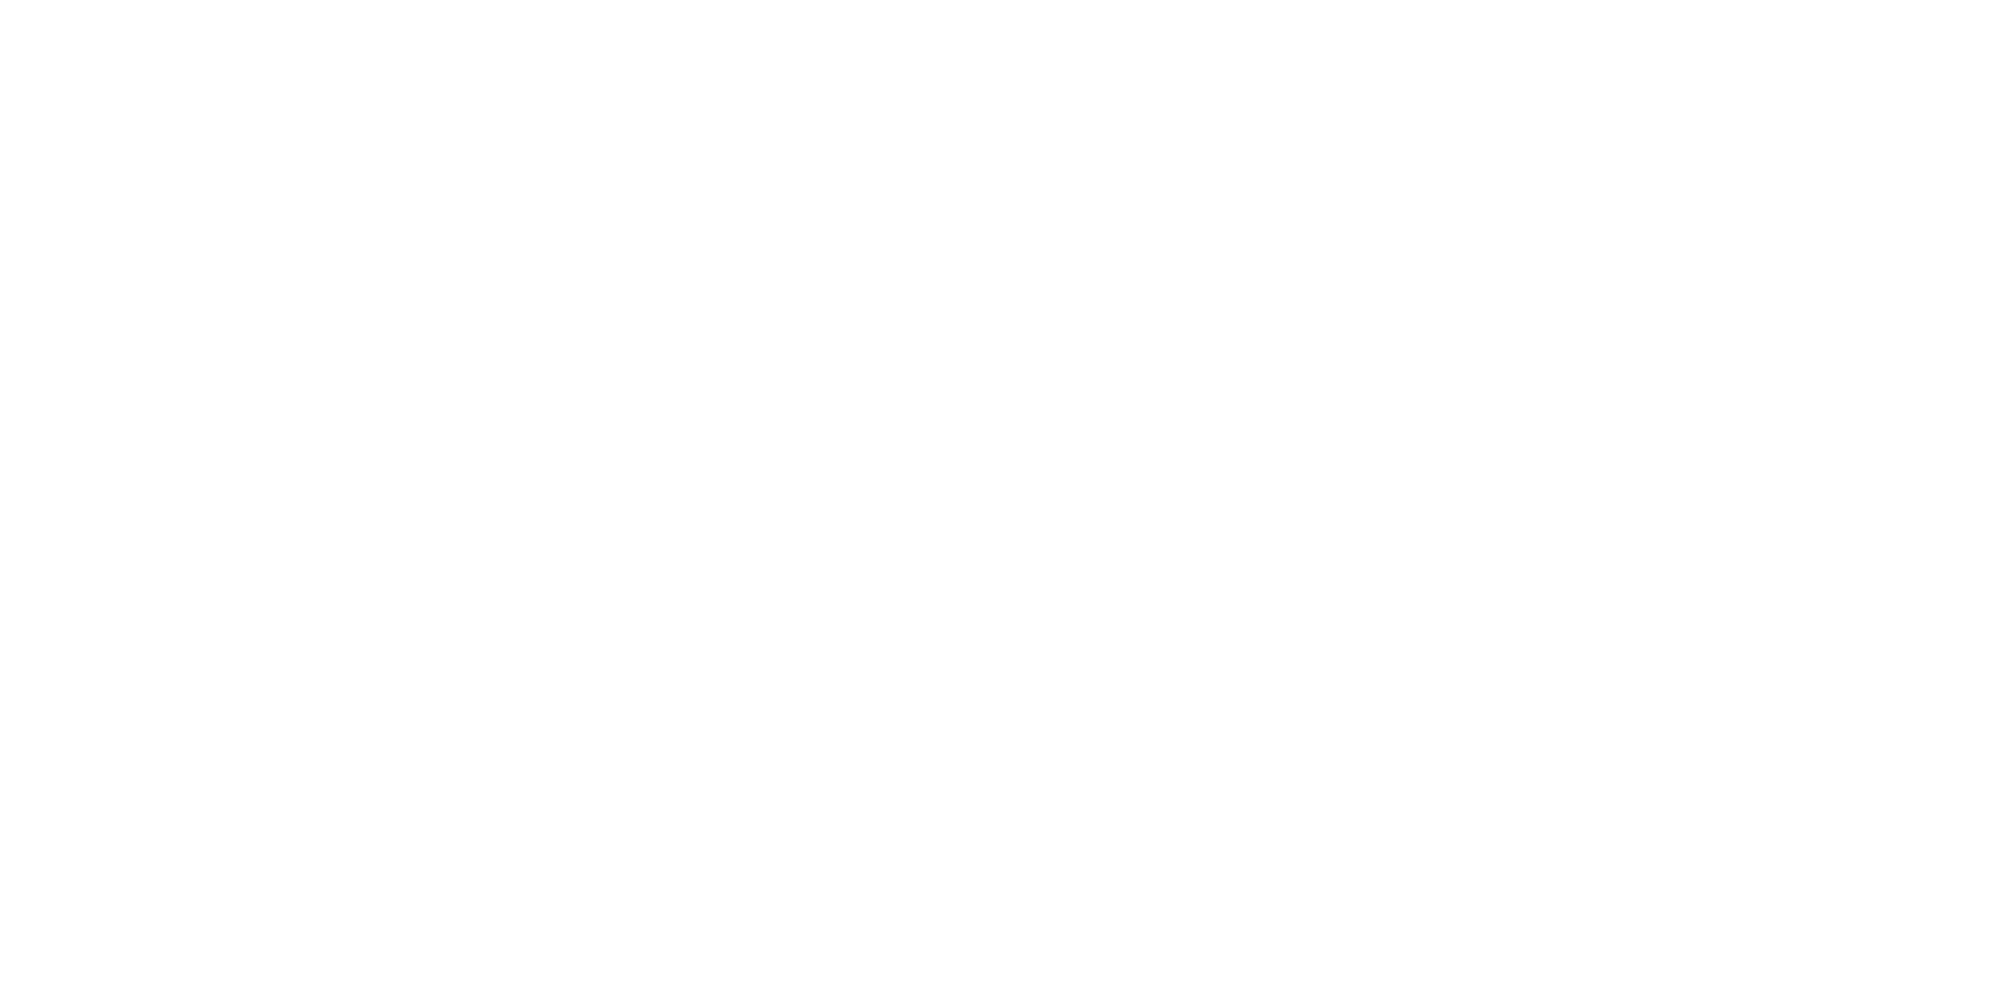

In [124]:
s_imgs = np.array([np.sqrt(np.sum(data_S[:,:,k]**2)) for k in range(data_S.shape[2])])
order_vec = np.flip(np.argsort(s_imgs).astype(int))

#my_gif_name = 'gif_test12.gif'
#create_gif(data_A, dataset, order_vec, my_gif_name)

my_supergif_name = 'superGIF_test19.gif'
create_superGIF(data_A, s_imgs, dataset, order_vec, my_supergif_name)

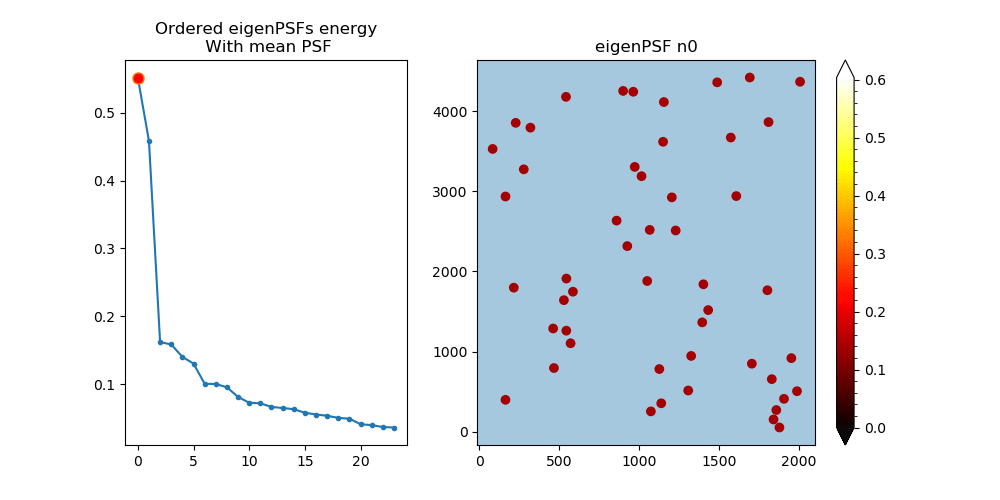

In [125]:
#show_gif(my_gif_name)
show_gif(my_supergif_name)

# Test gif with proximity metric

<IPython.core.display.Javascript object>


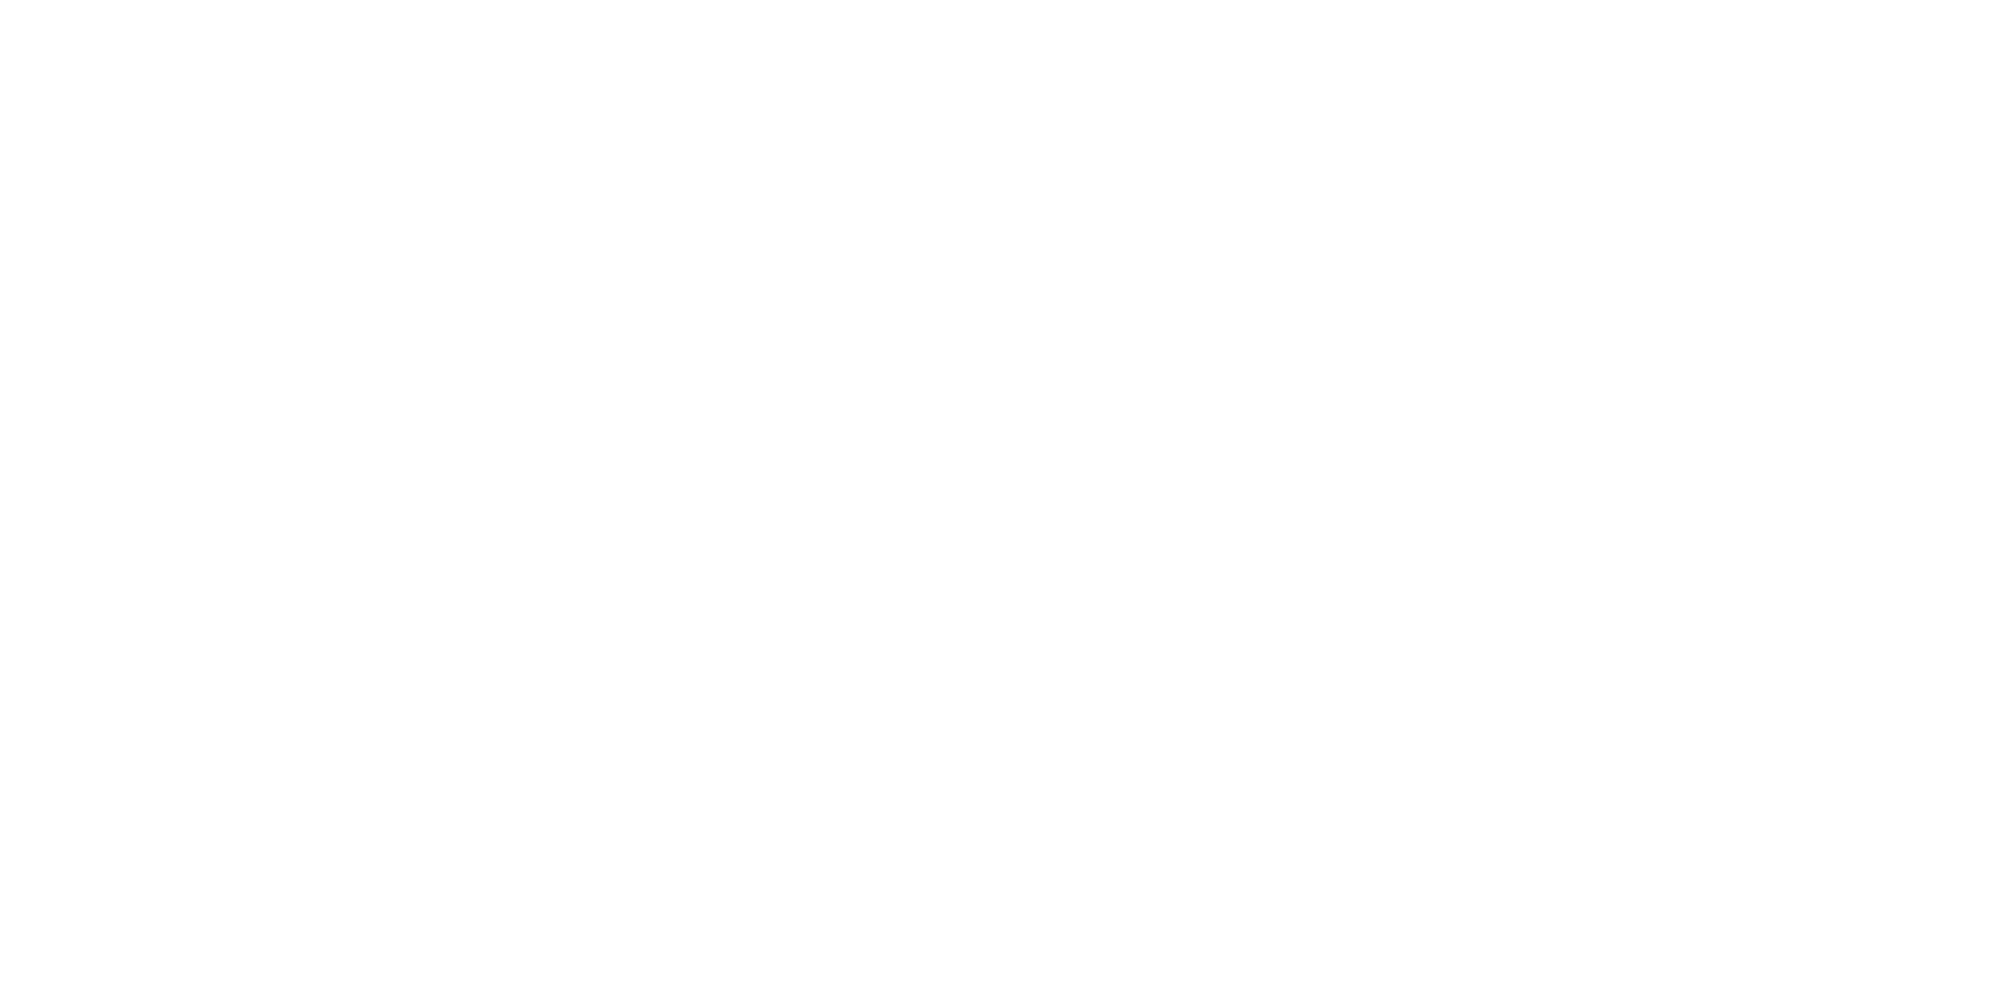

<IPython.core.display.Javascript object>


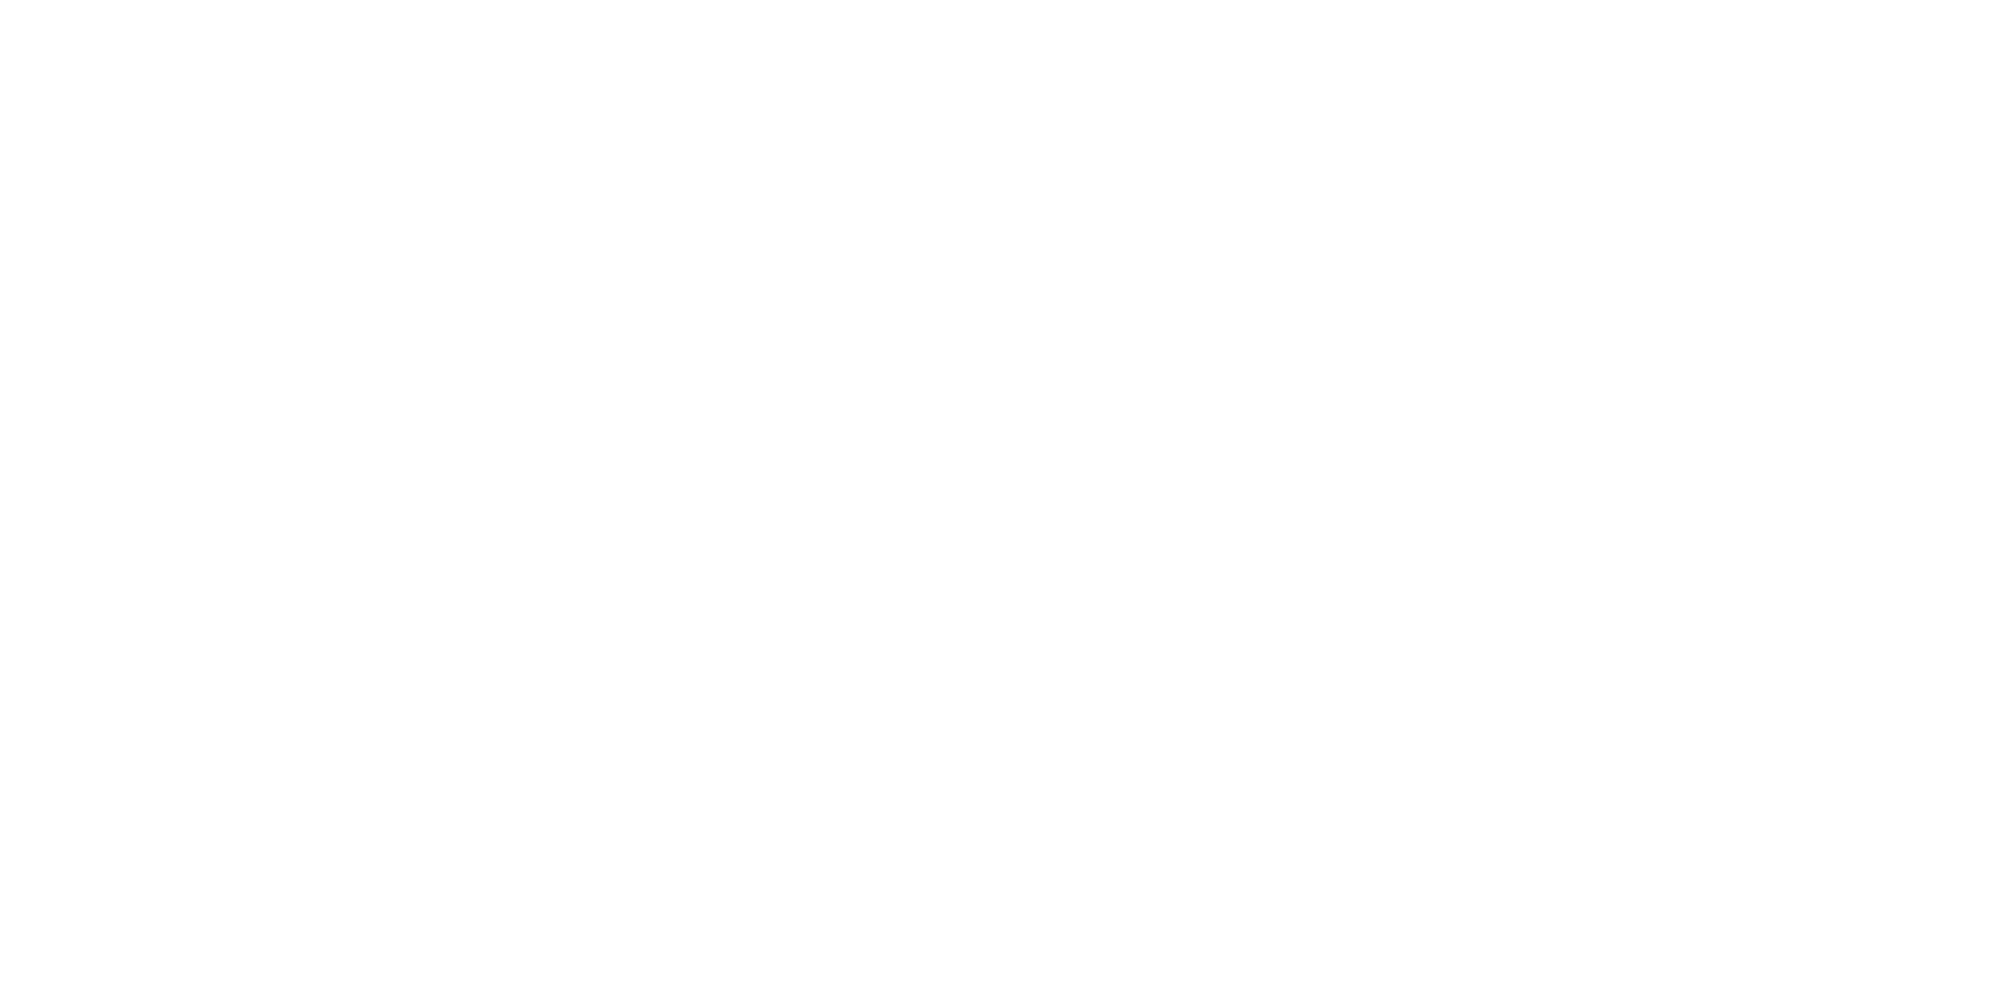

<IPython.core.display.Javascript object>


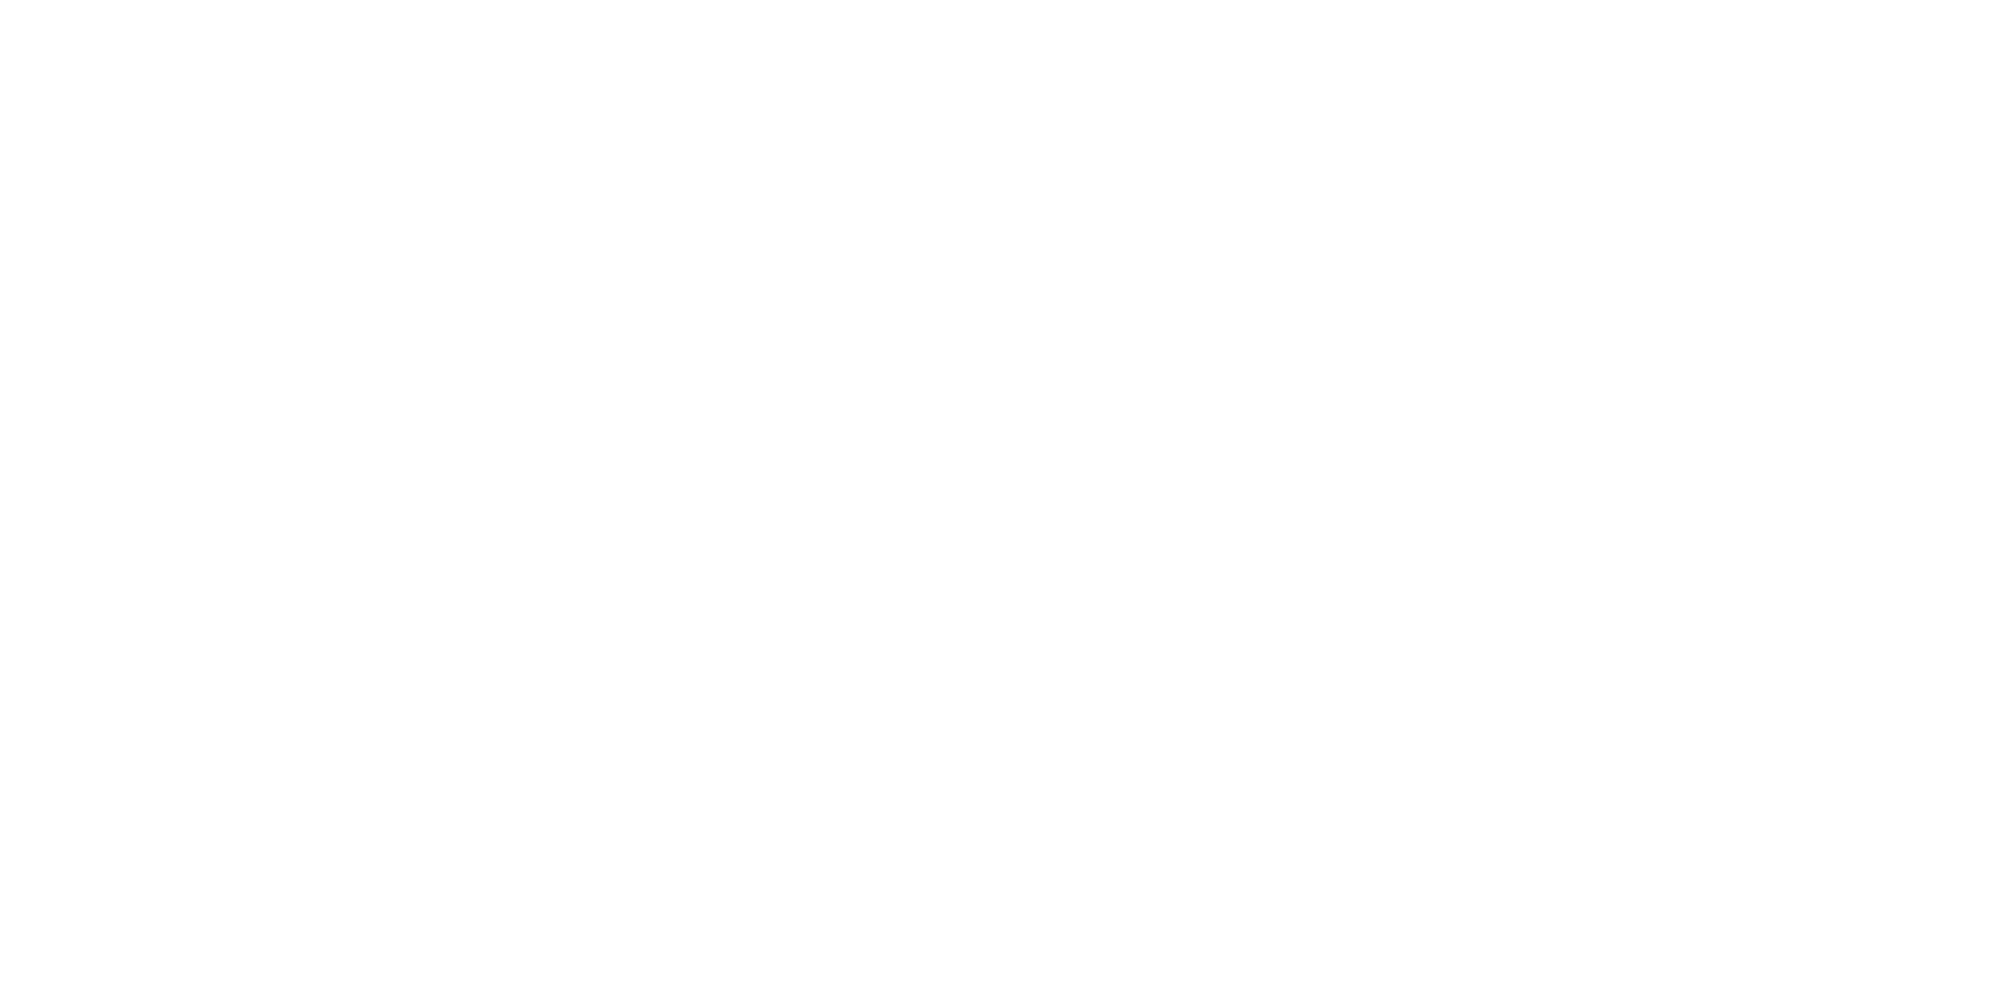

<IPython.core.display.Javascript object>


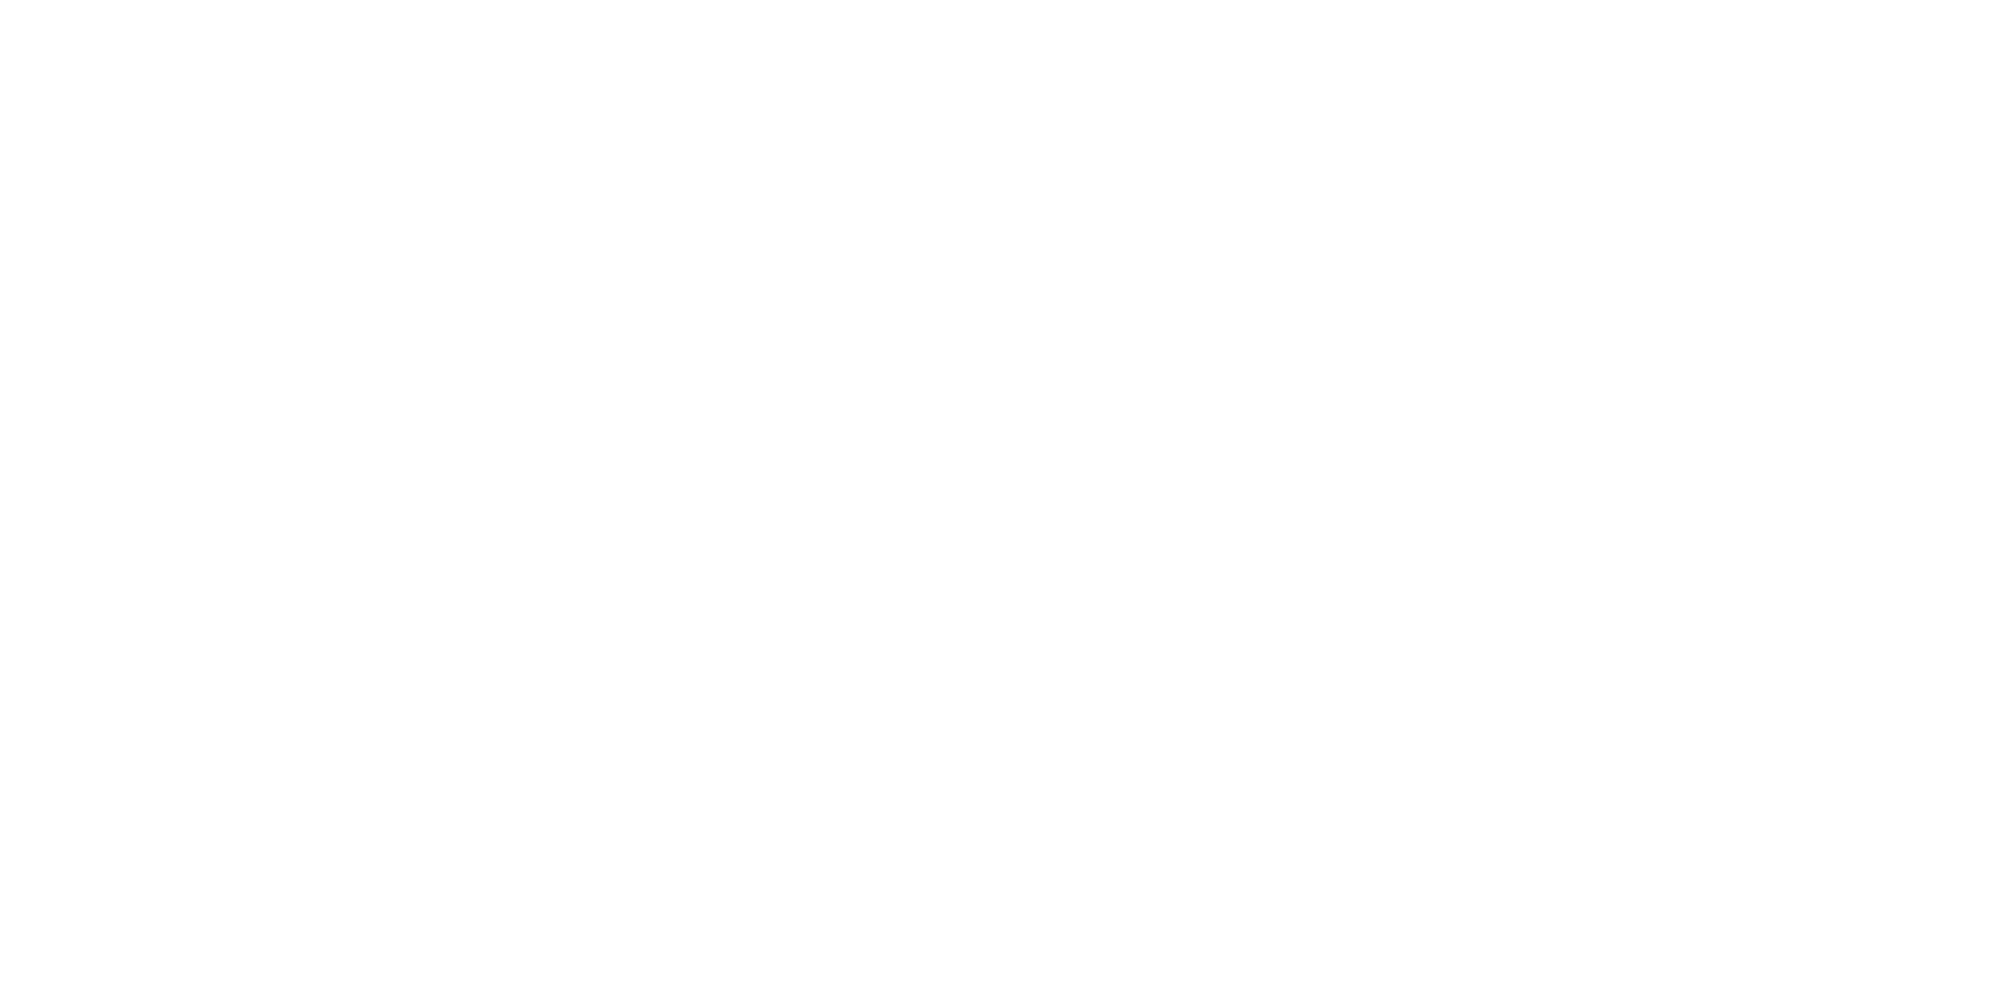

<IPython.core.display.Javascript object>


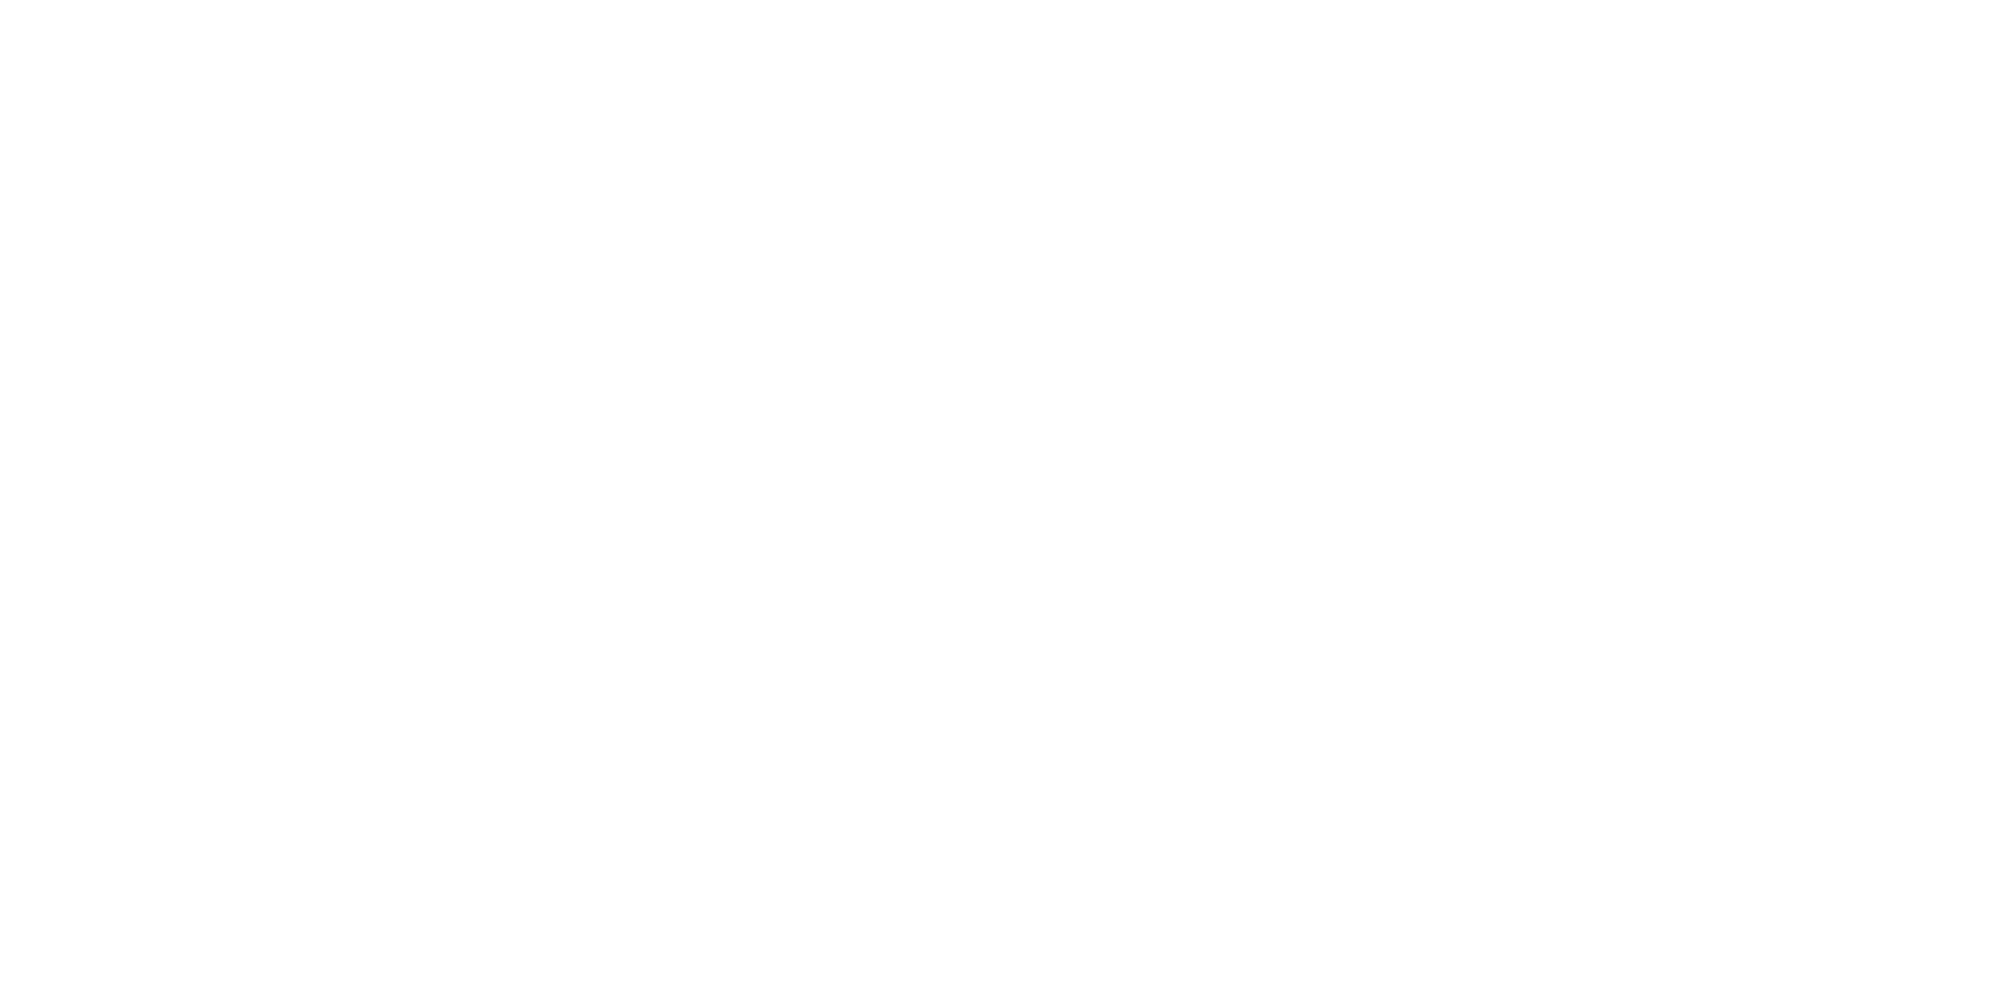

<IPython.core.display.Javascript object>


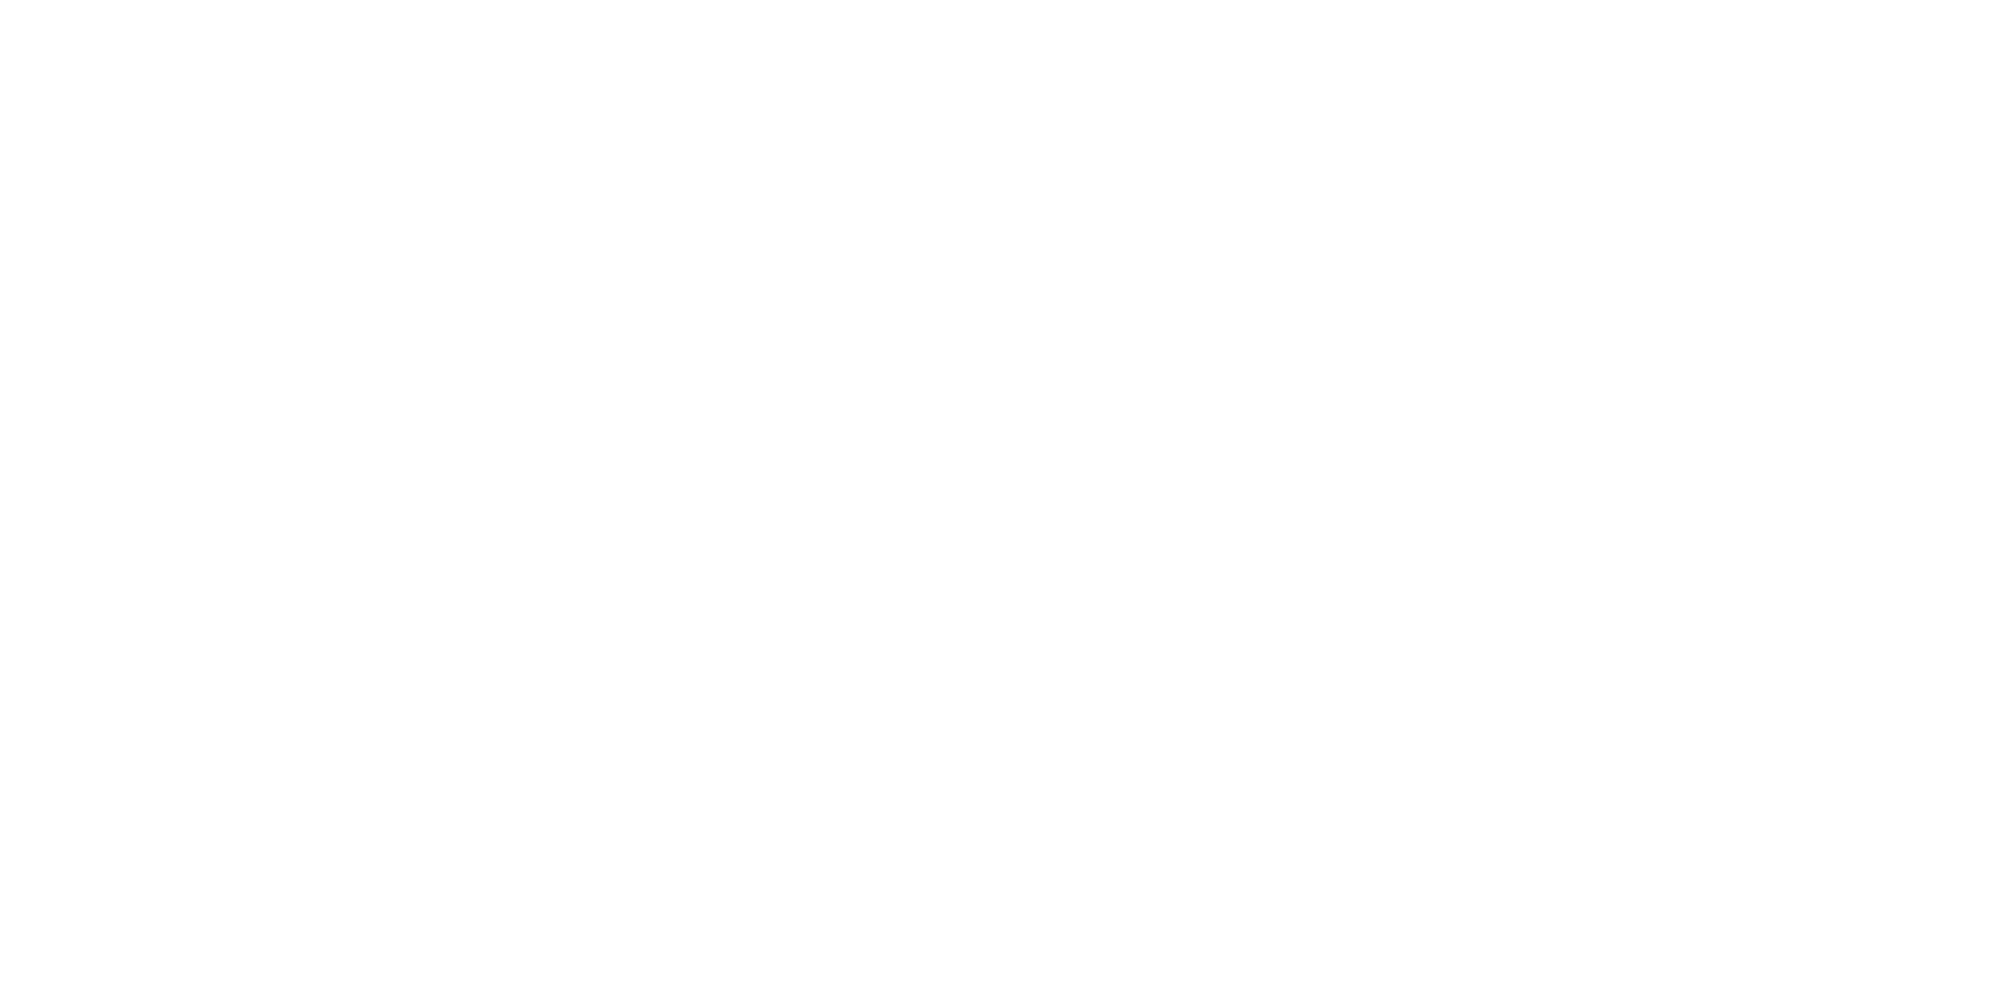

<IPython.core.display.Javascript object>


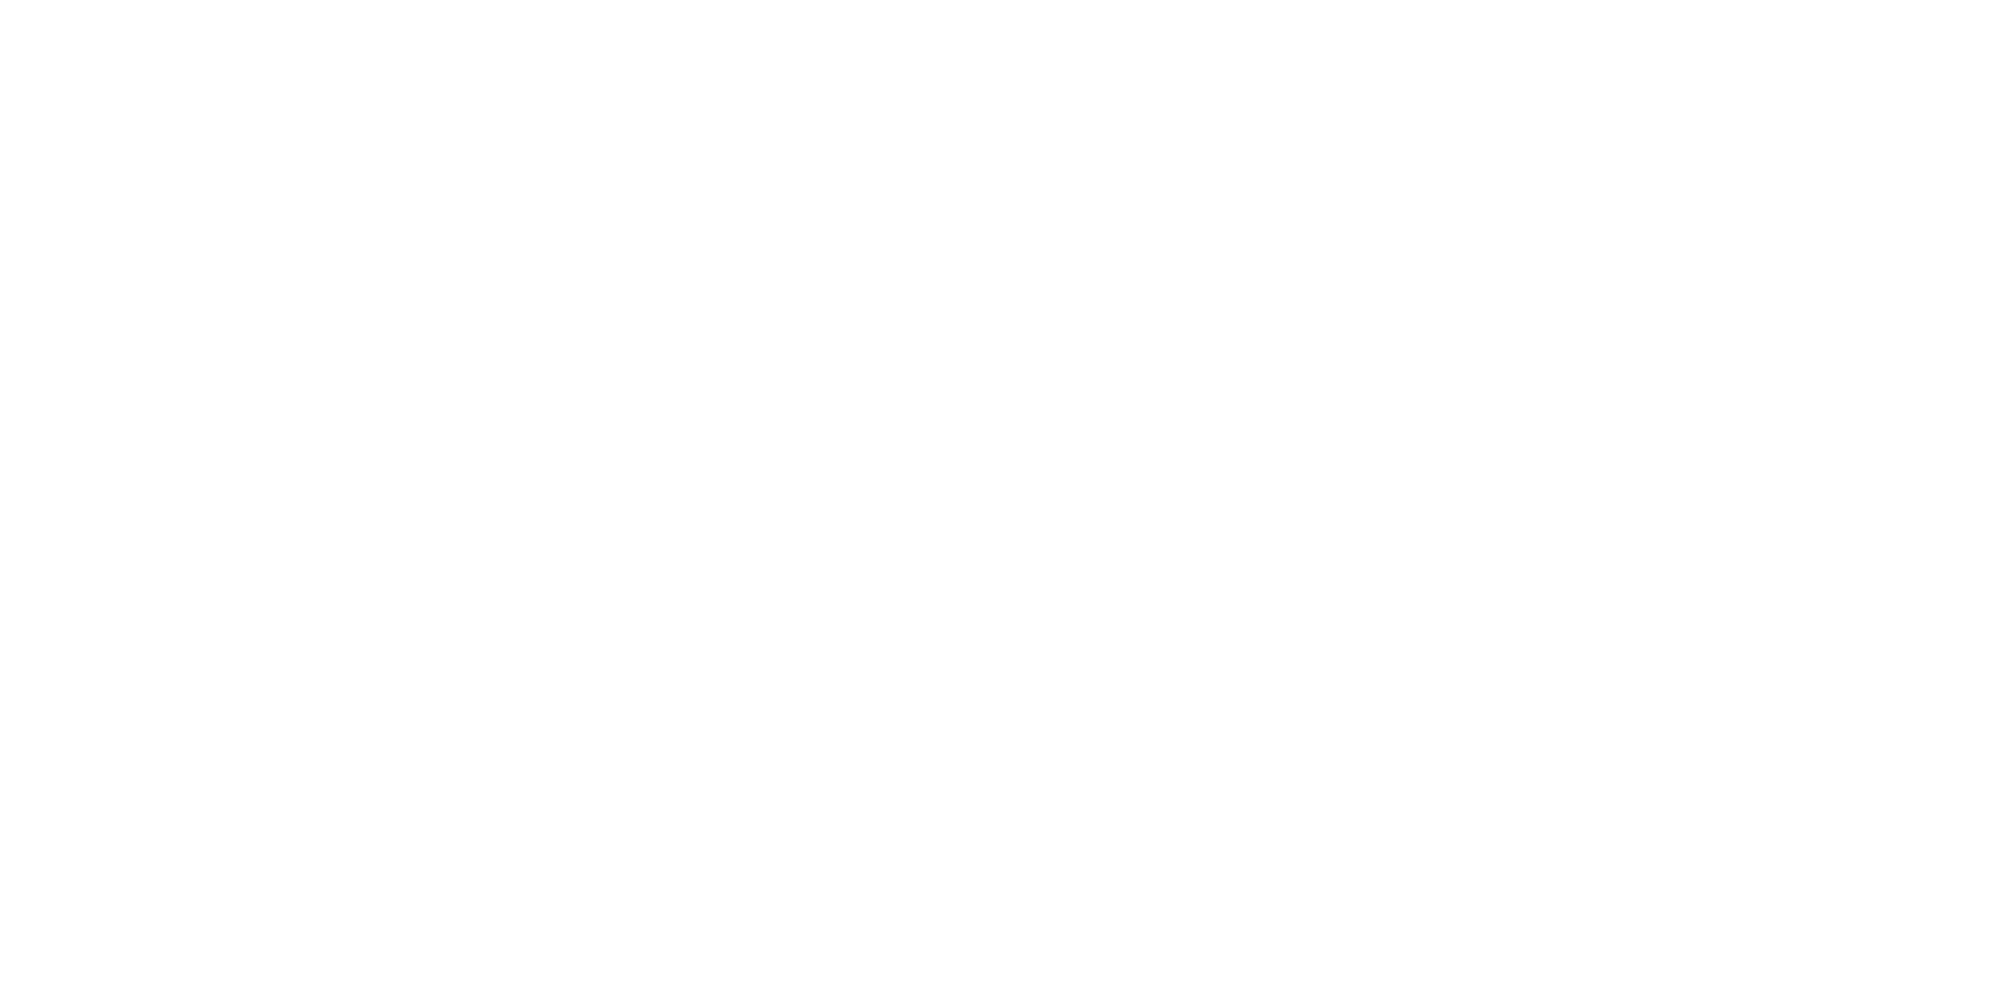

<IPython.core.display.Javascript object>


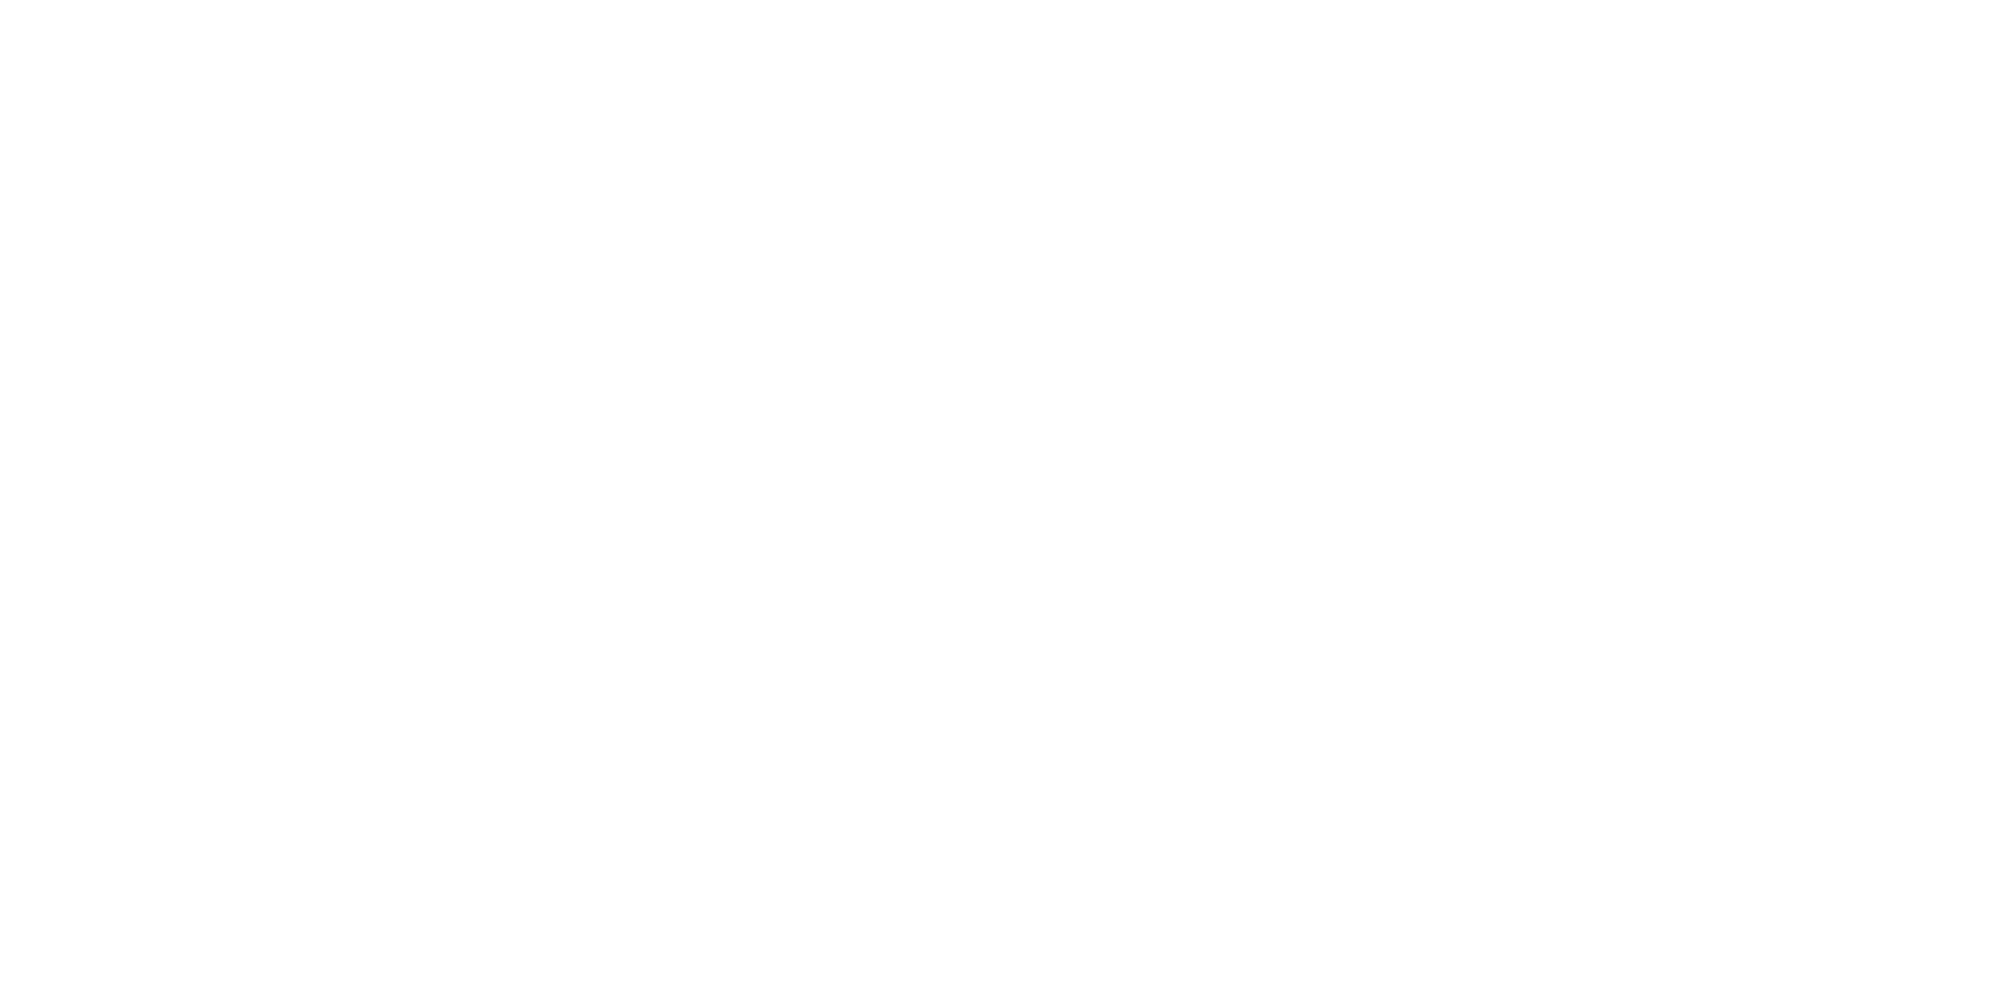

<IPython.core.display.Javascript object>


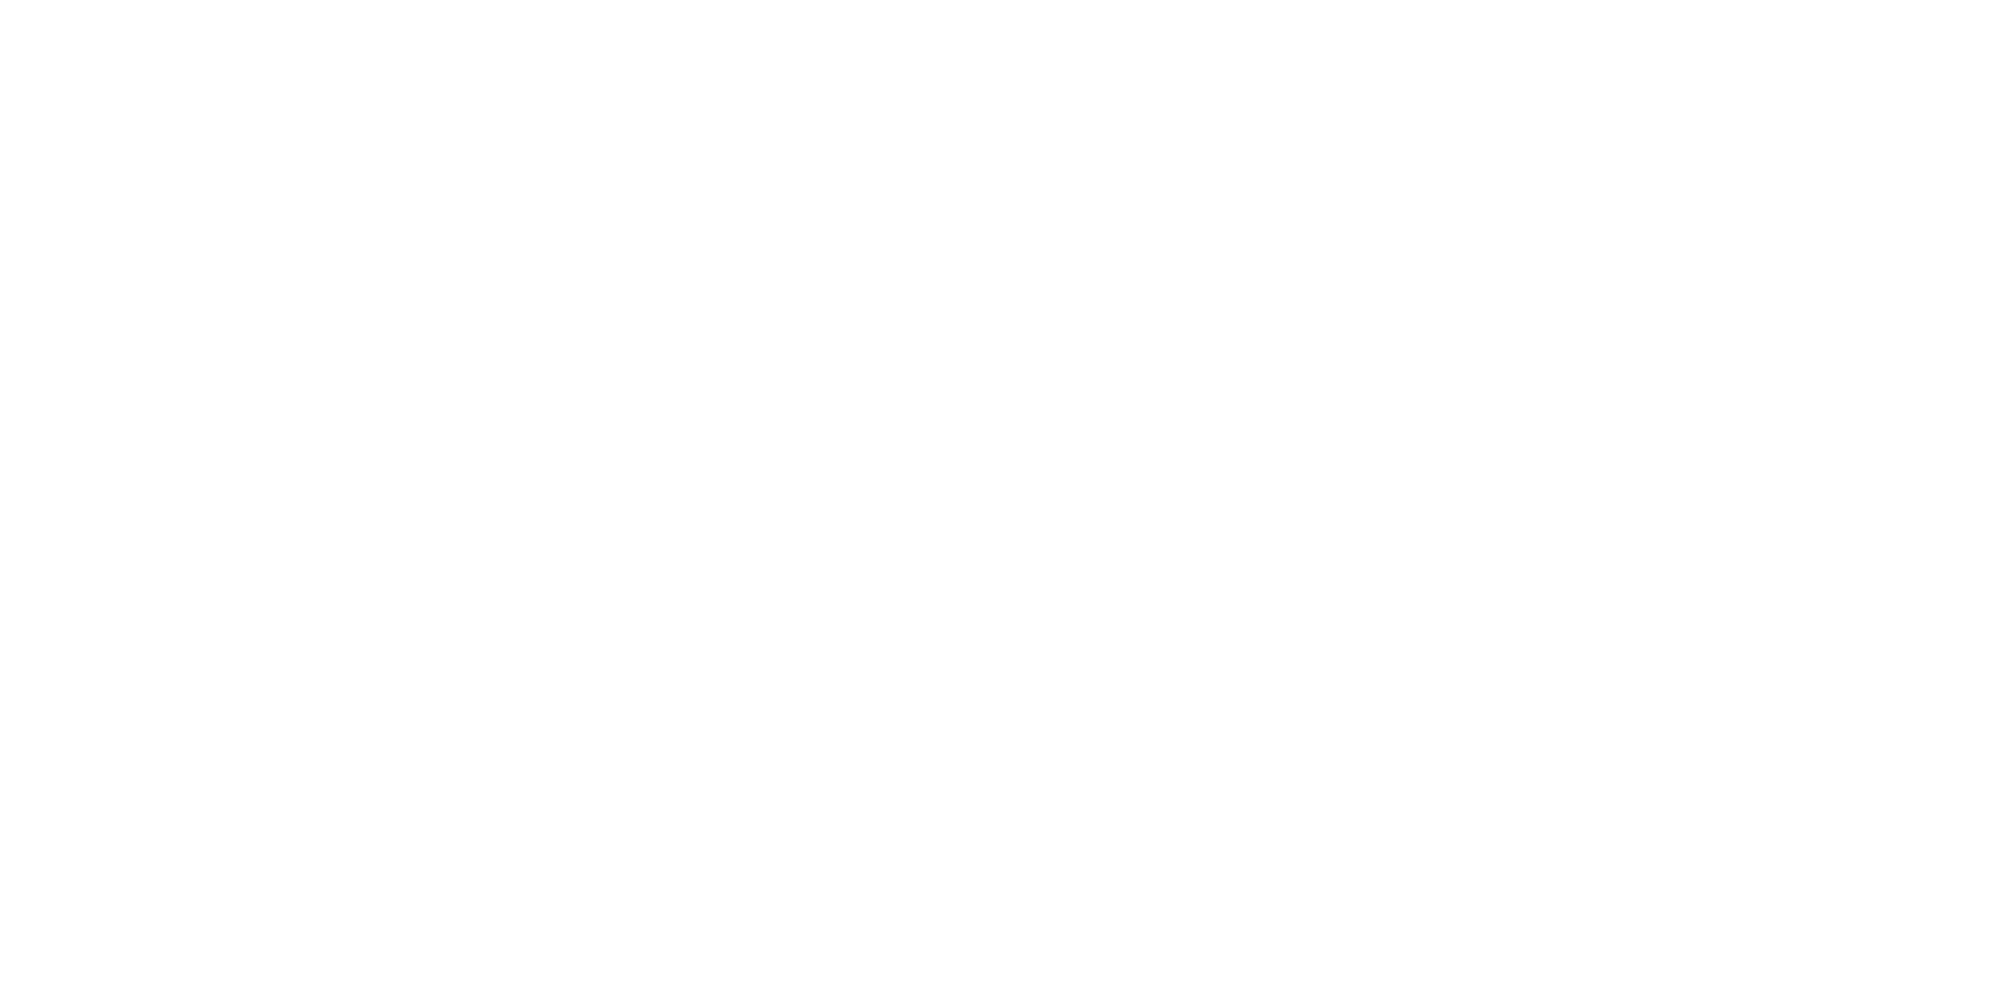

<IPython.core.display.Javascript object>


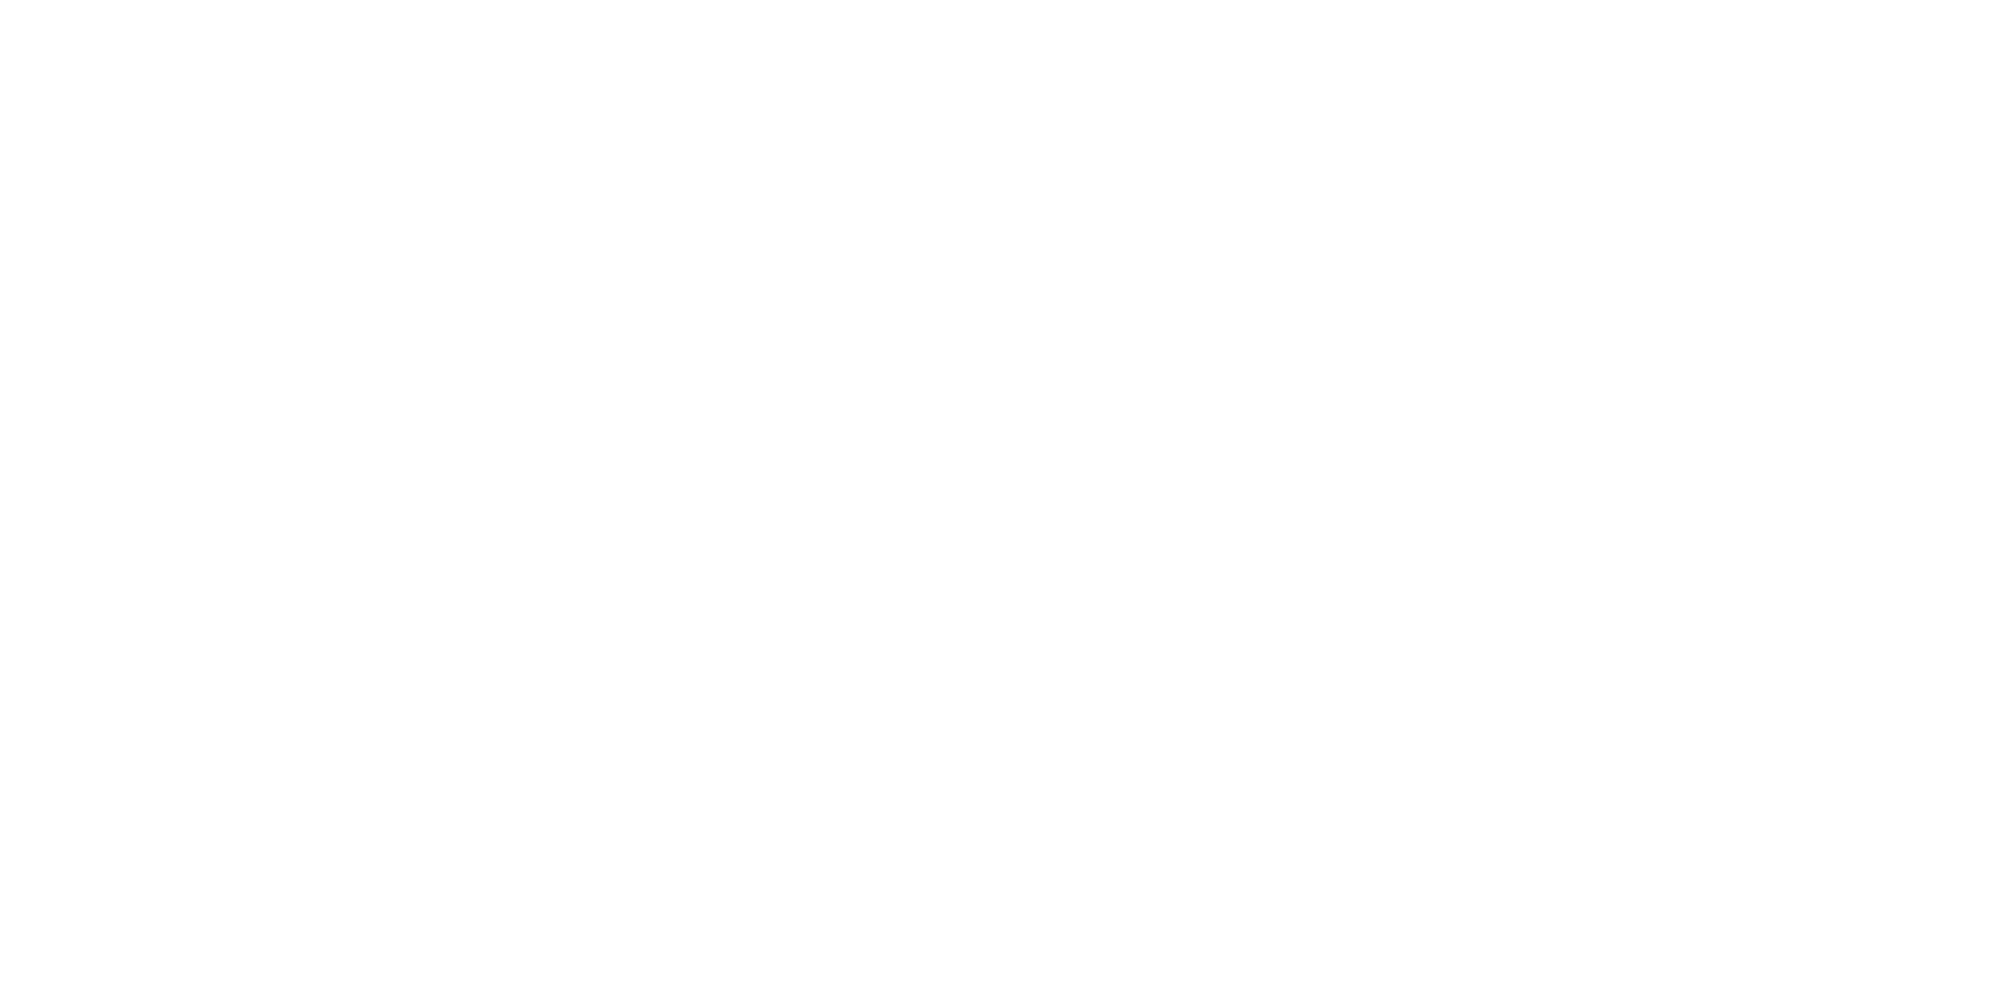

<IPython.core.display.Javascript object>


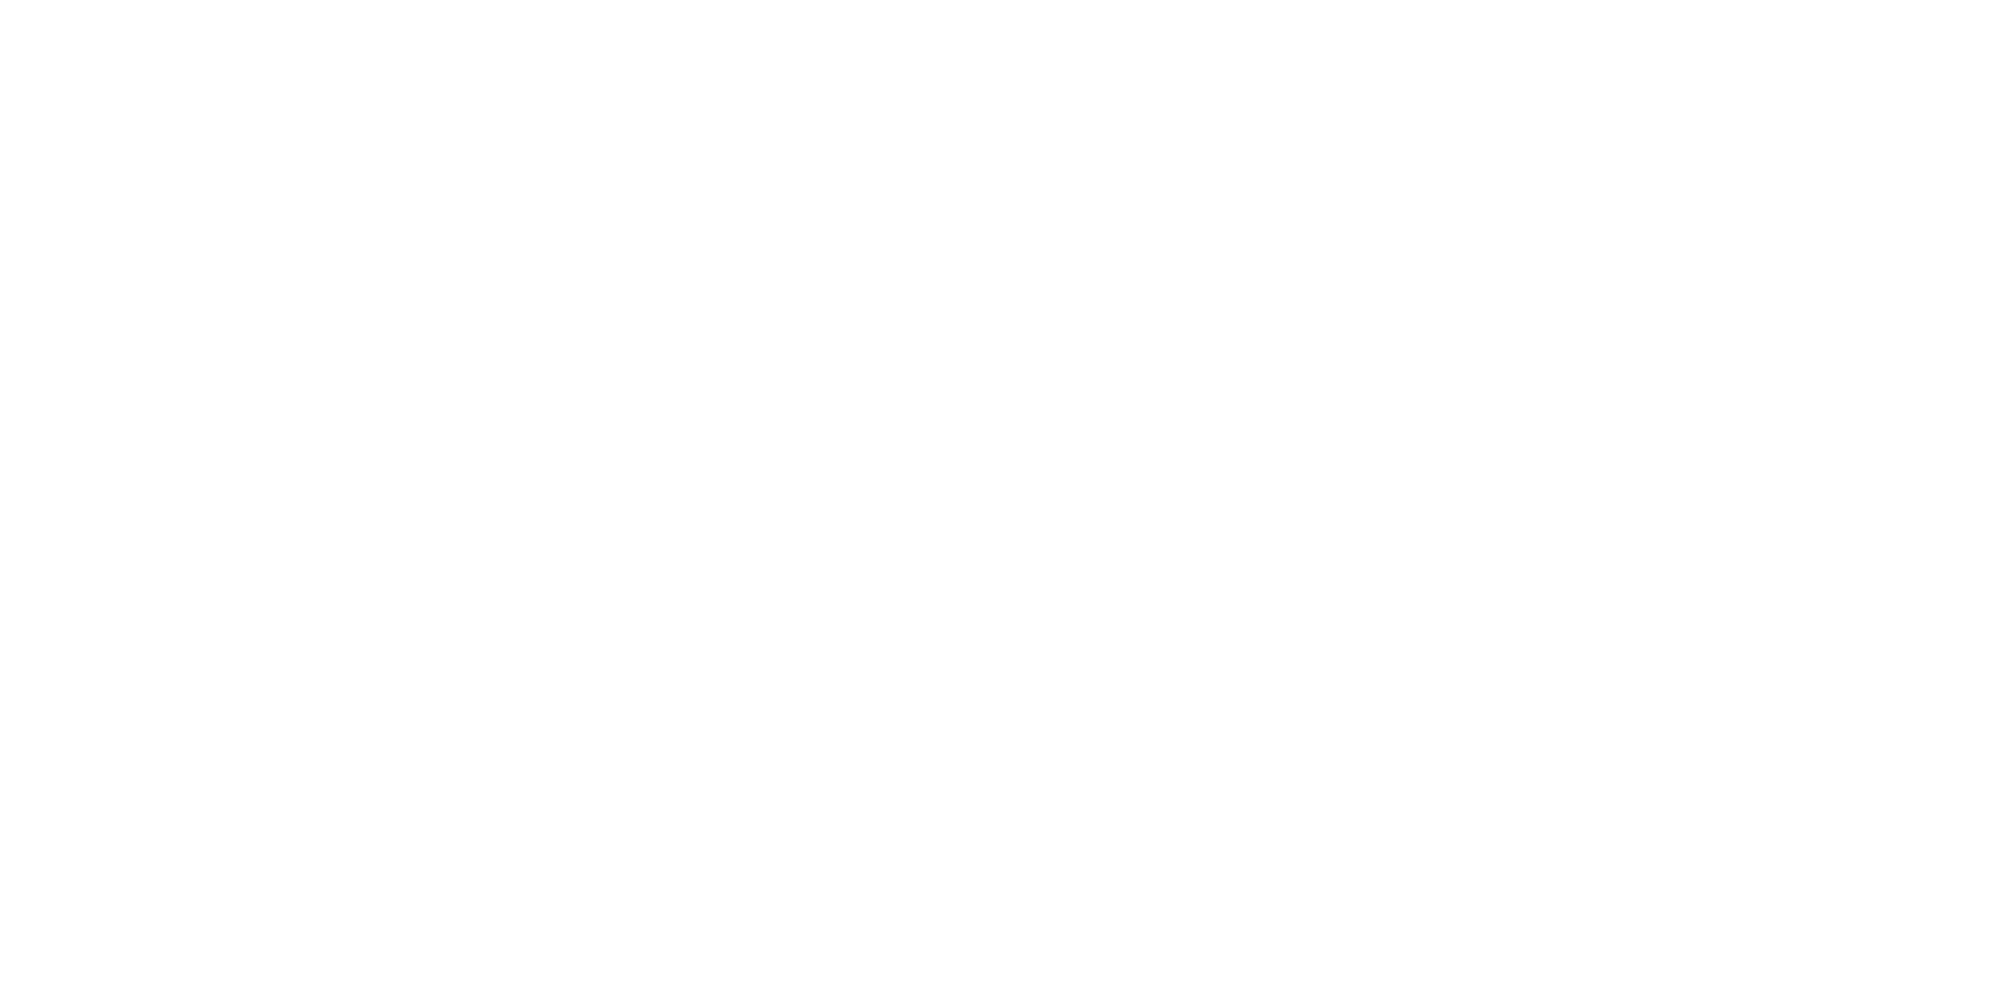

<IPython.core.display.Javascript object>


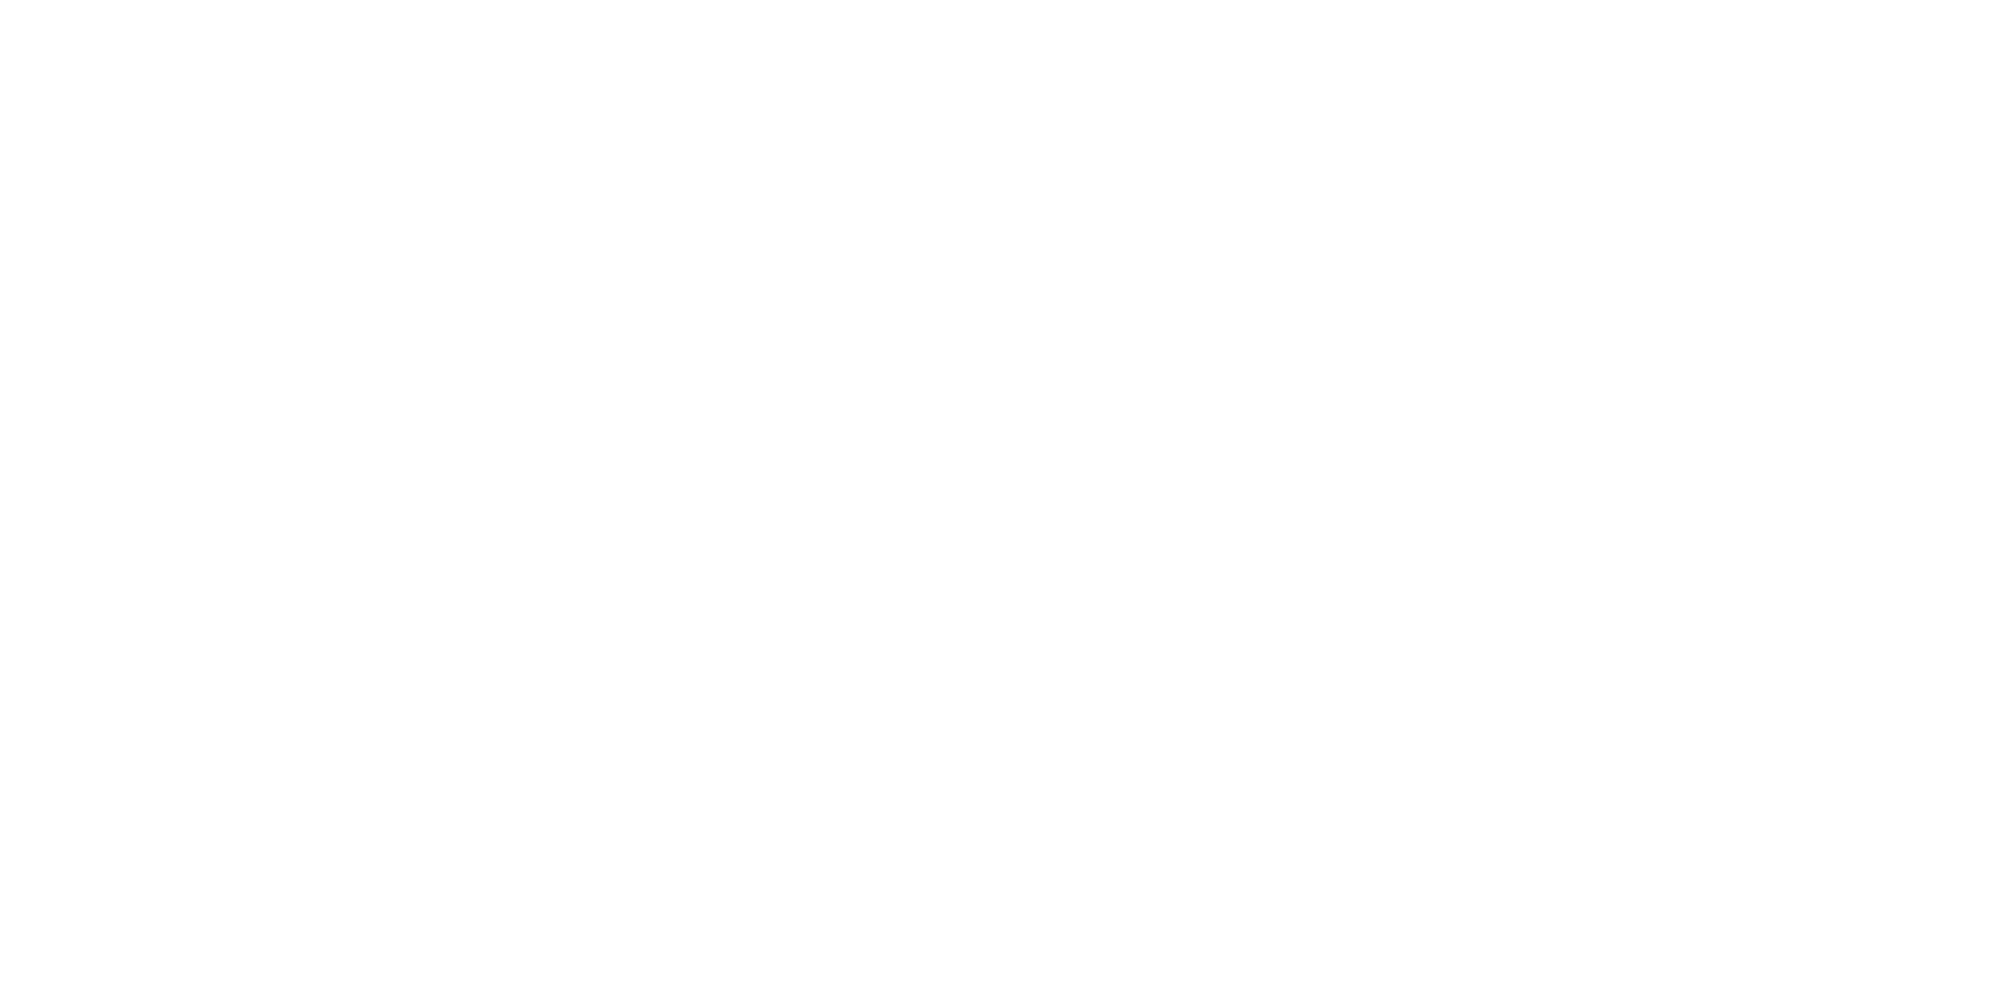

<IPython.core.display.Javascript object>


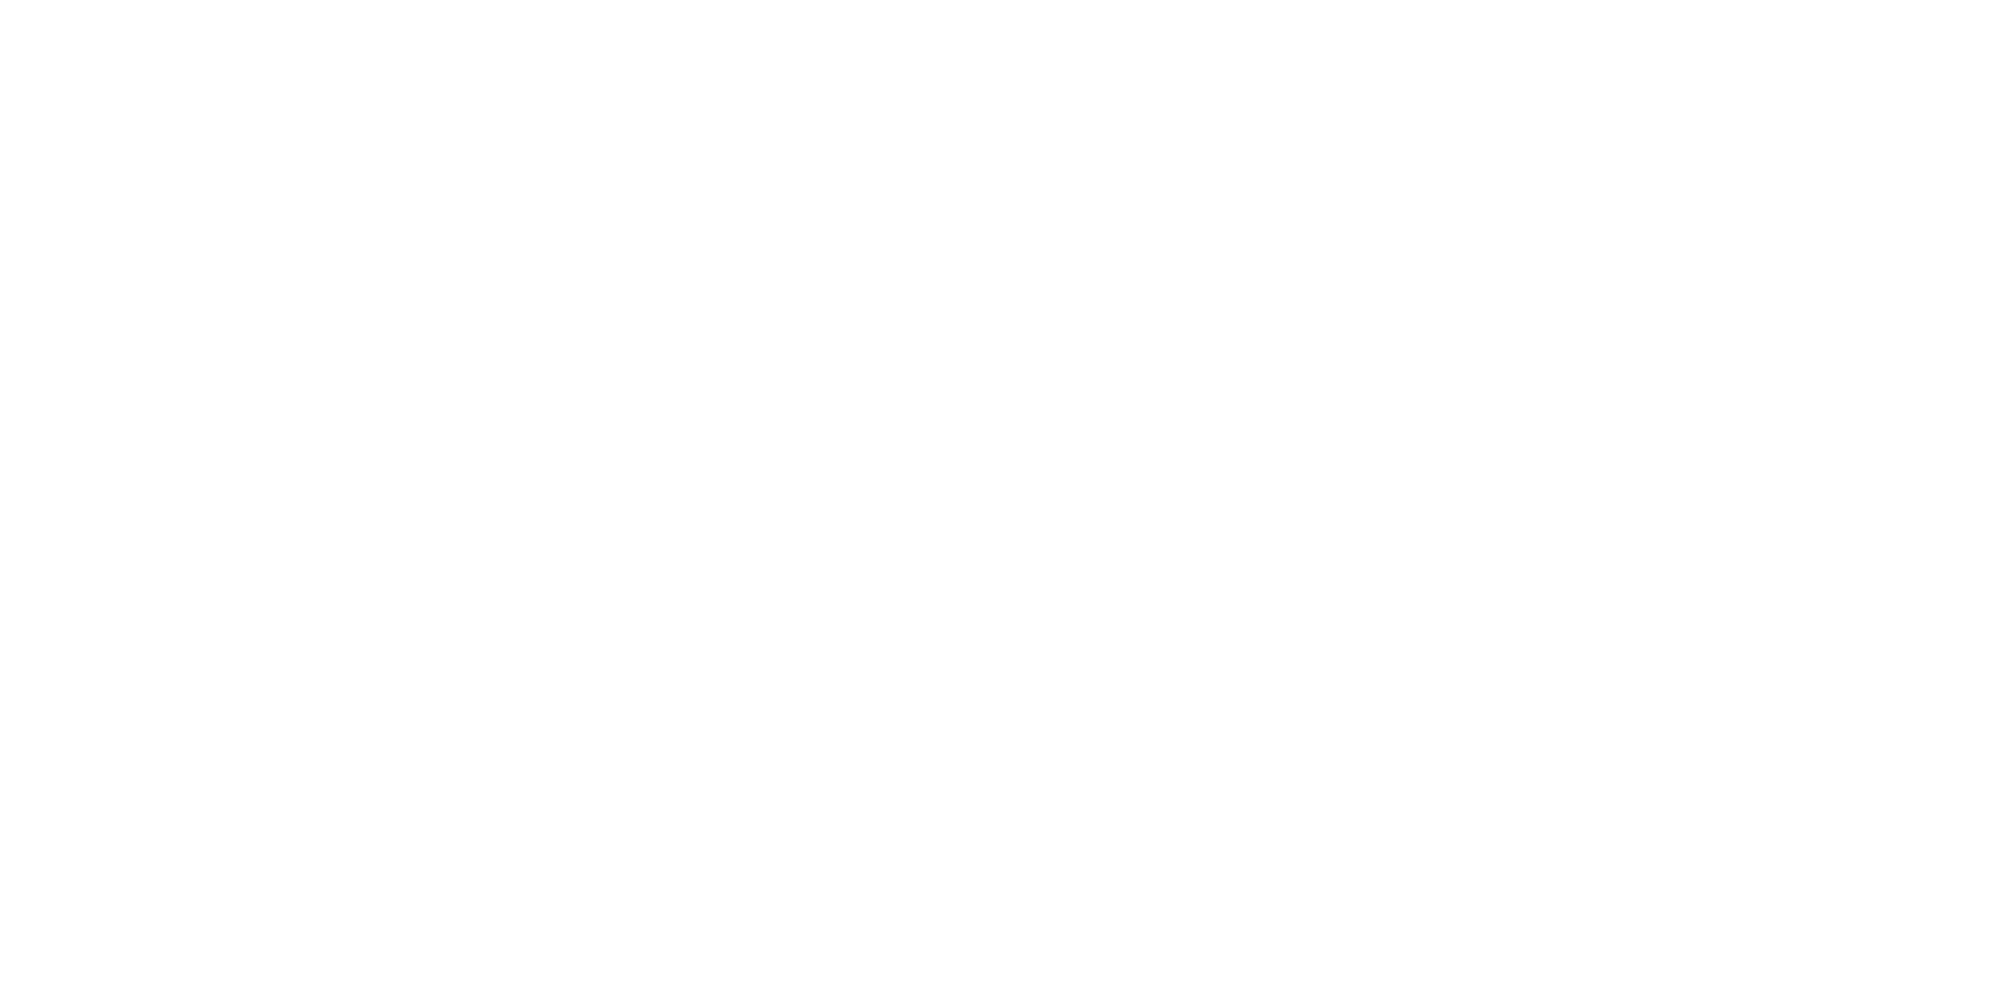

<IPython.core.display.Javascript object>


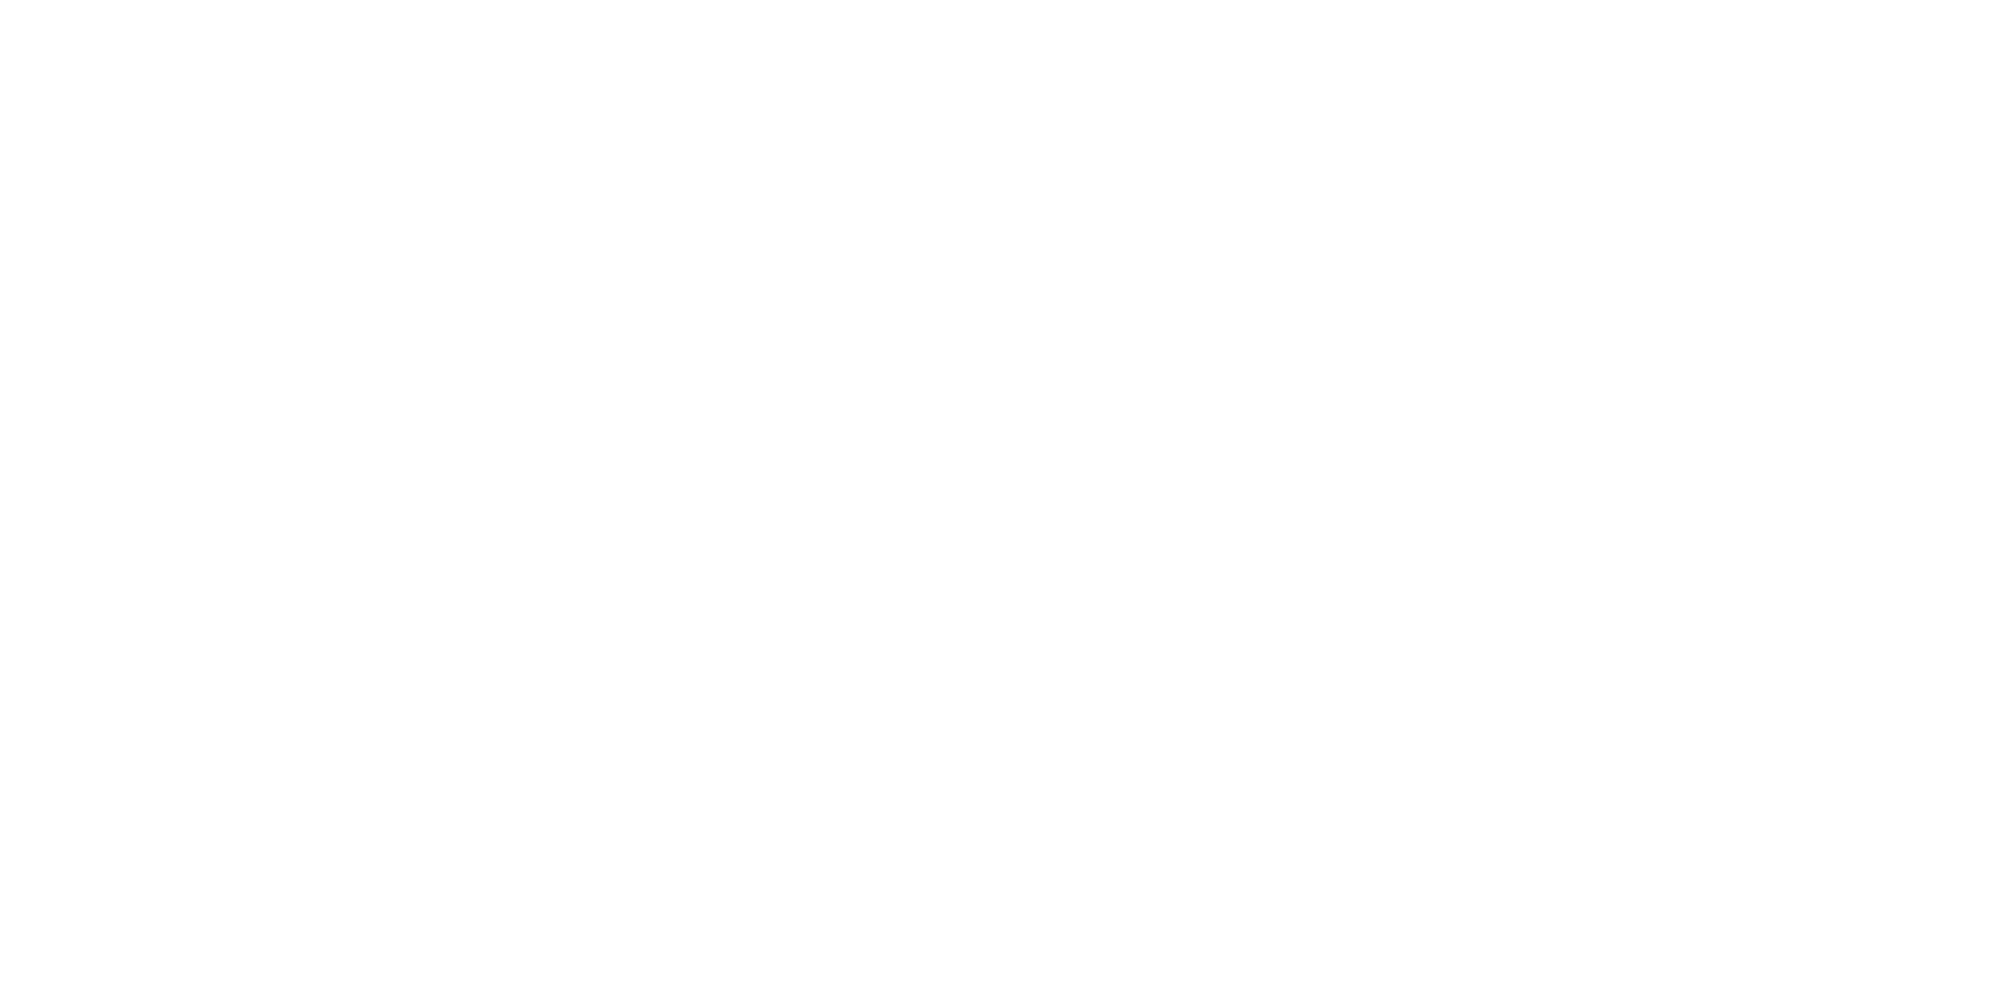

<IPython.core.display.Javascript object>


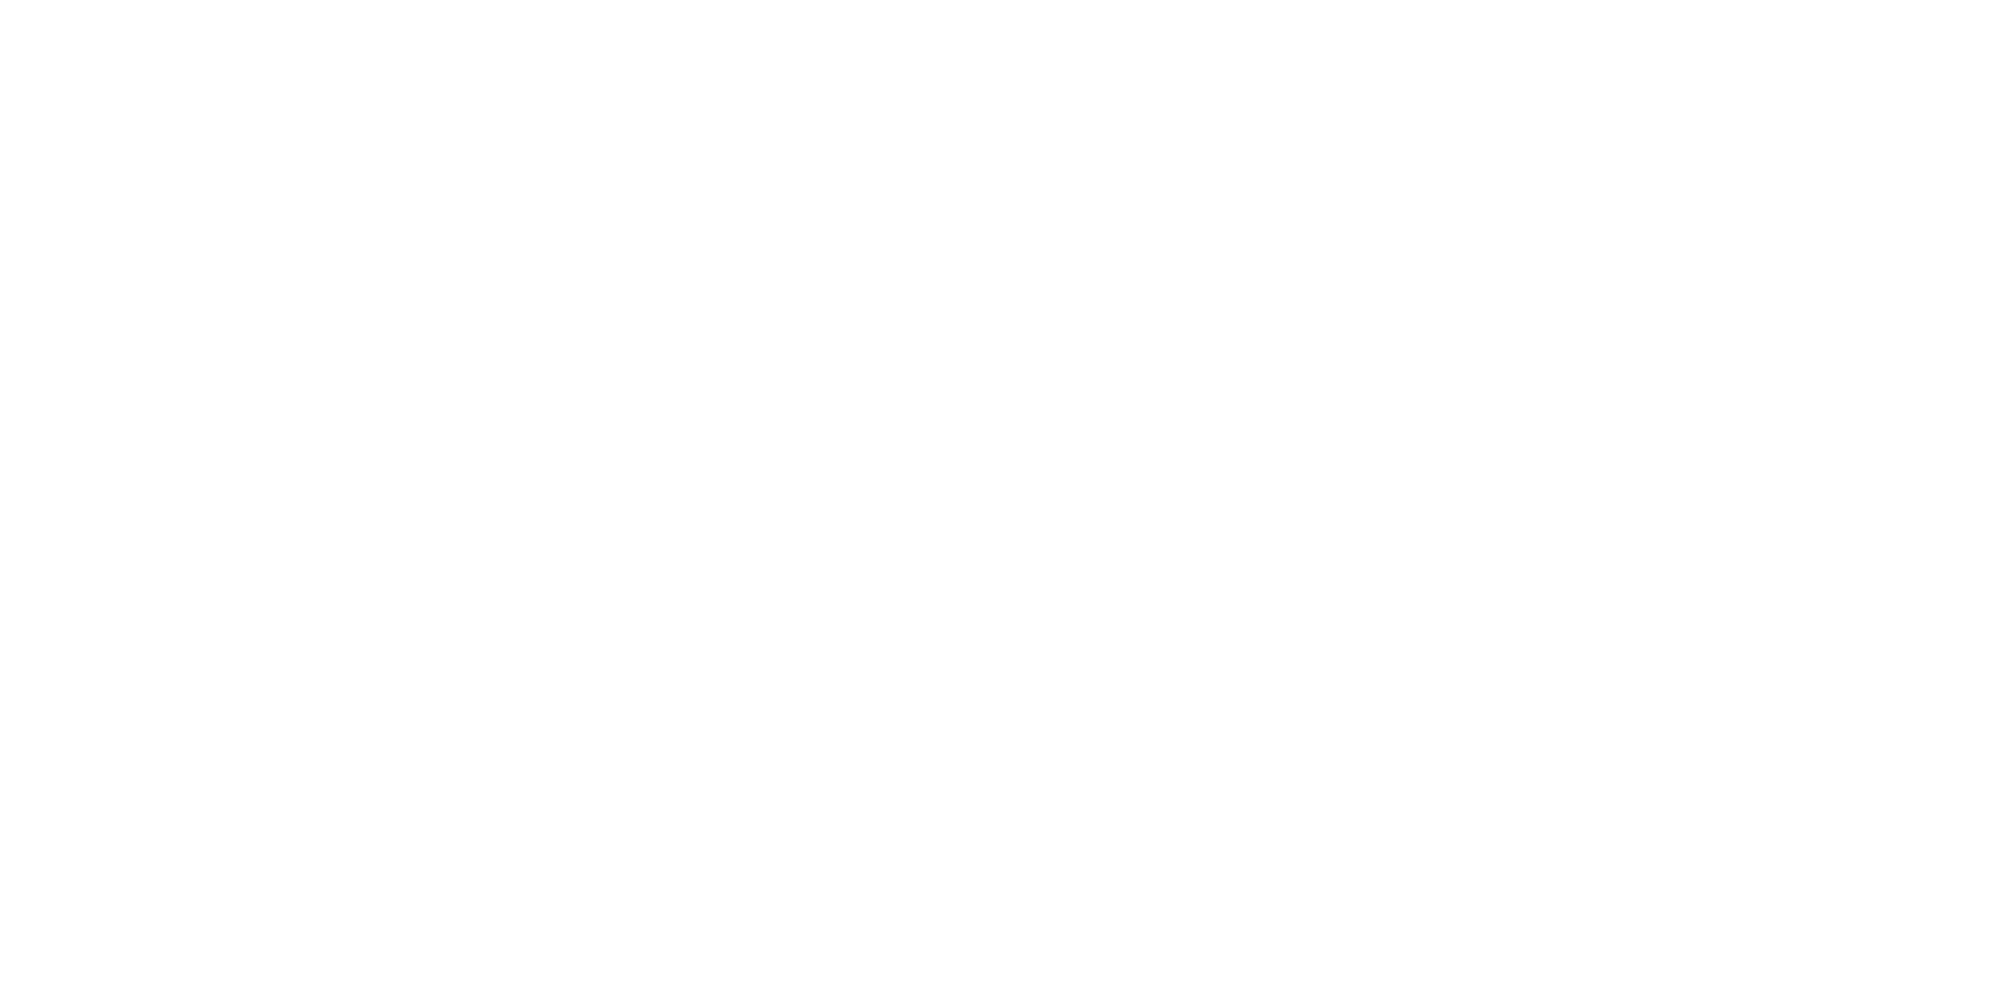

<IPython.core.display.Javascript object>


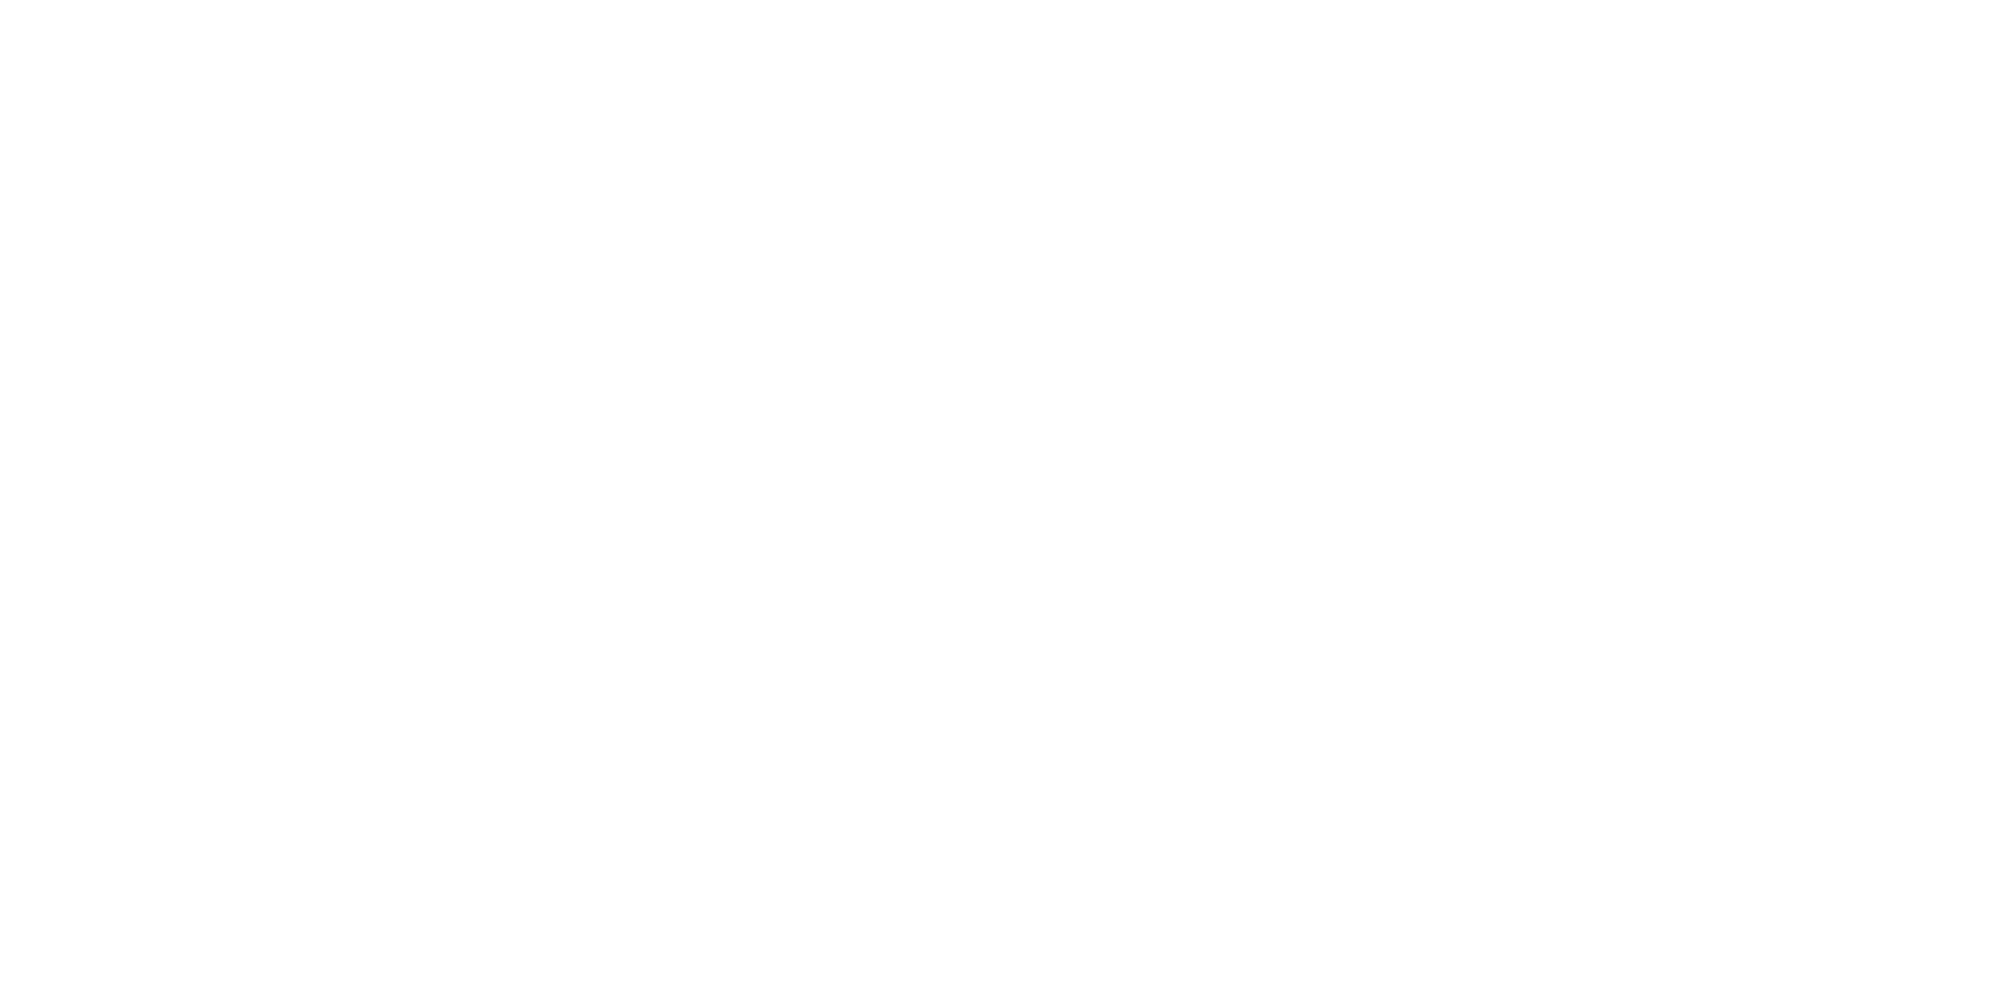

<IPython.core.display.Javascript object>


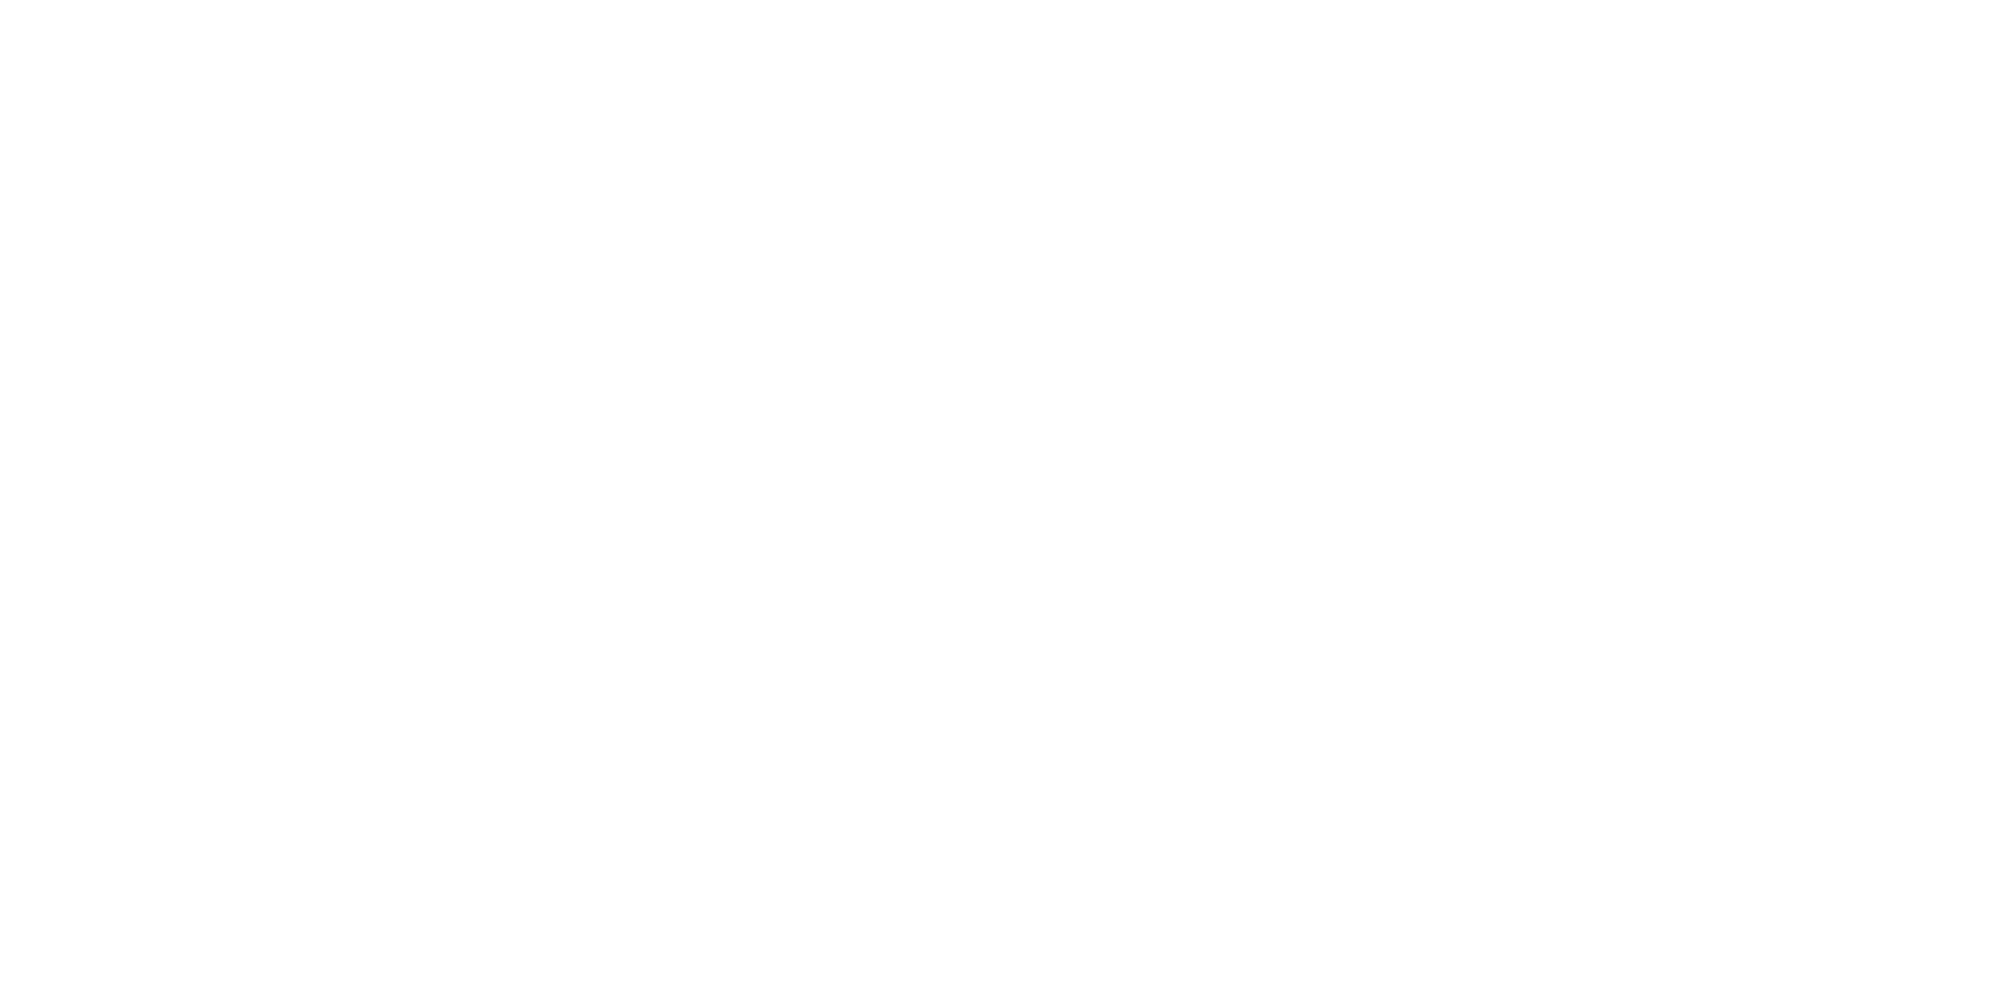

<IPython.core.display.Javascript object>


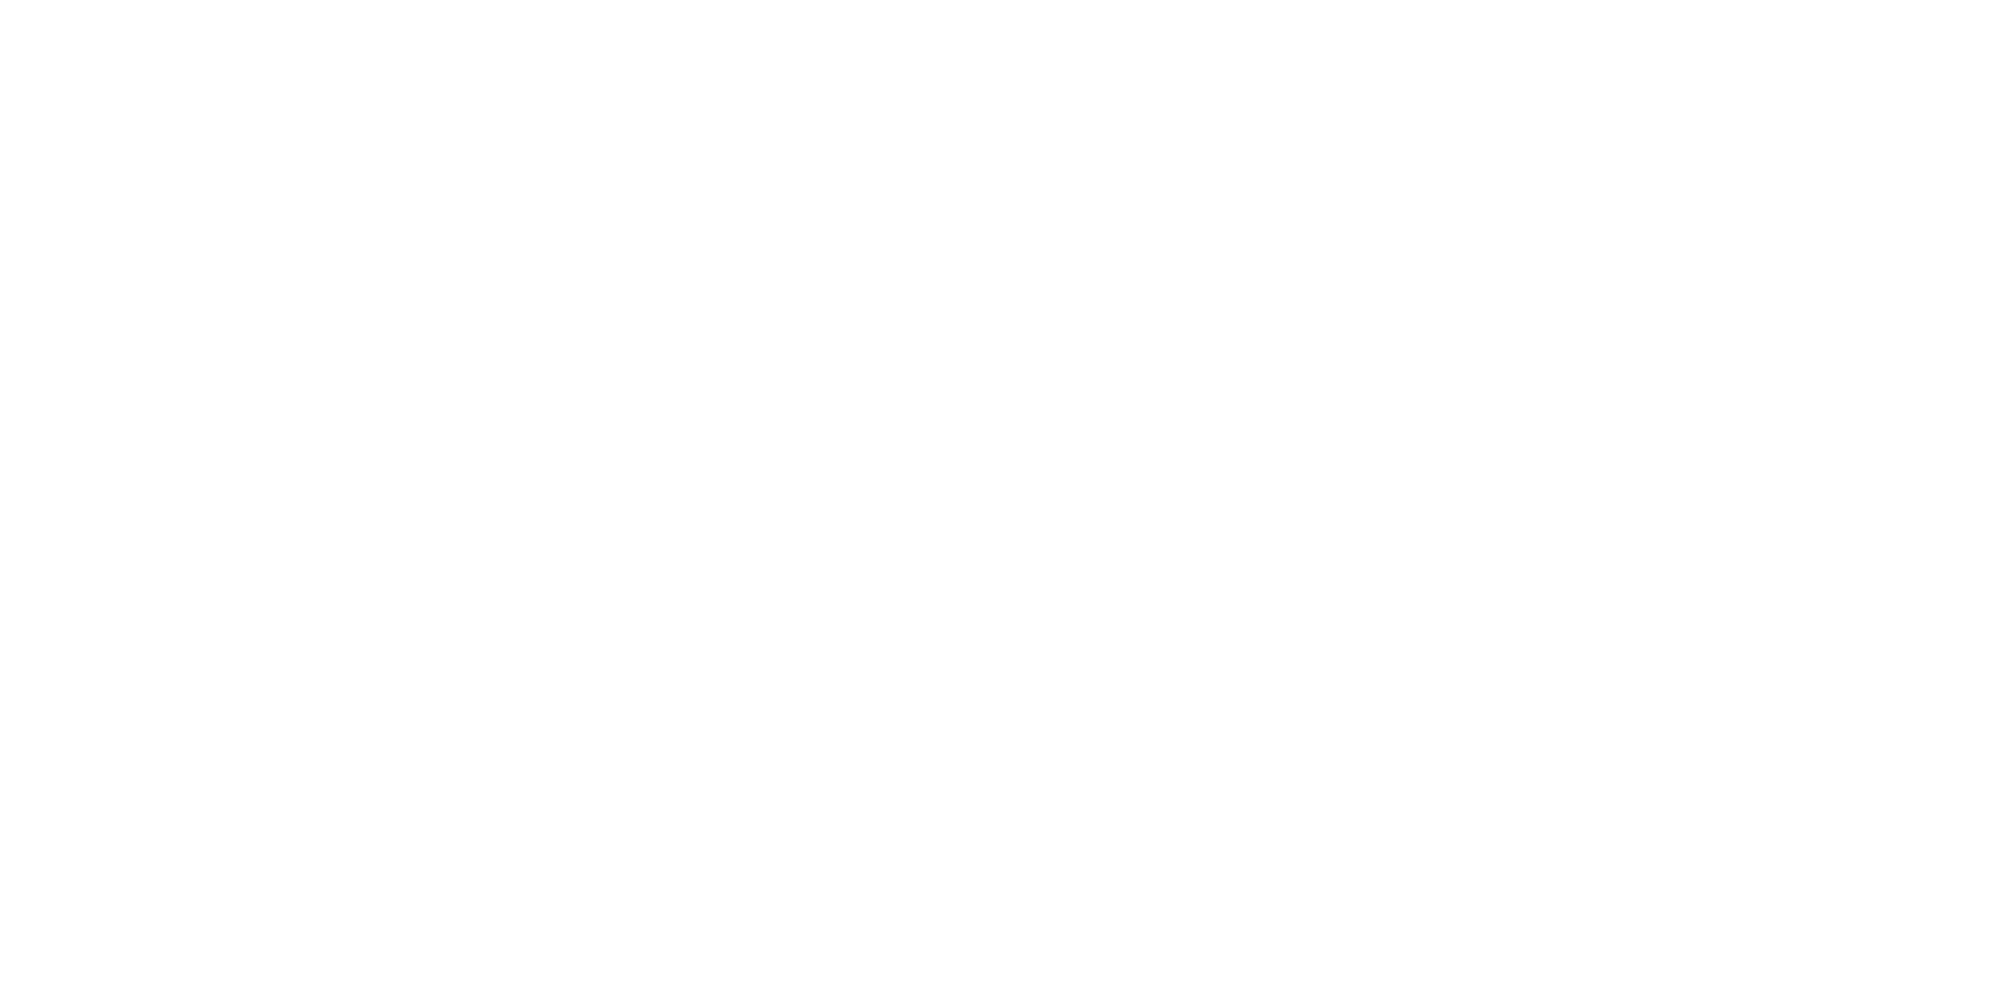

<IPython.core.display.Javascript object>


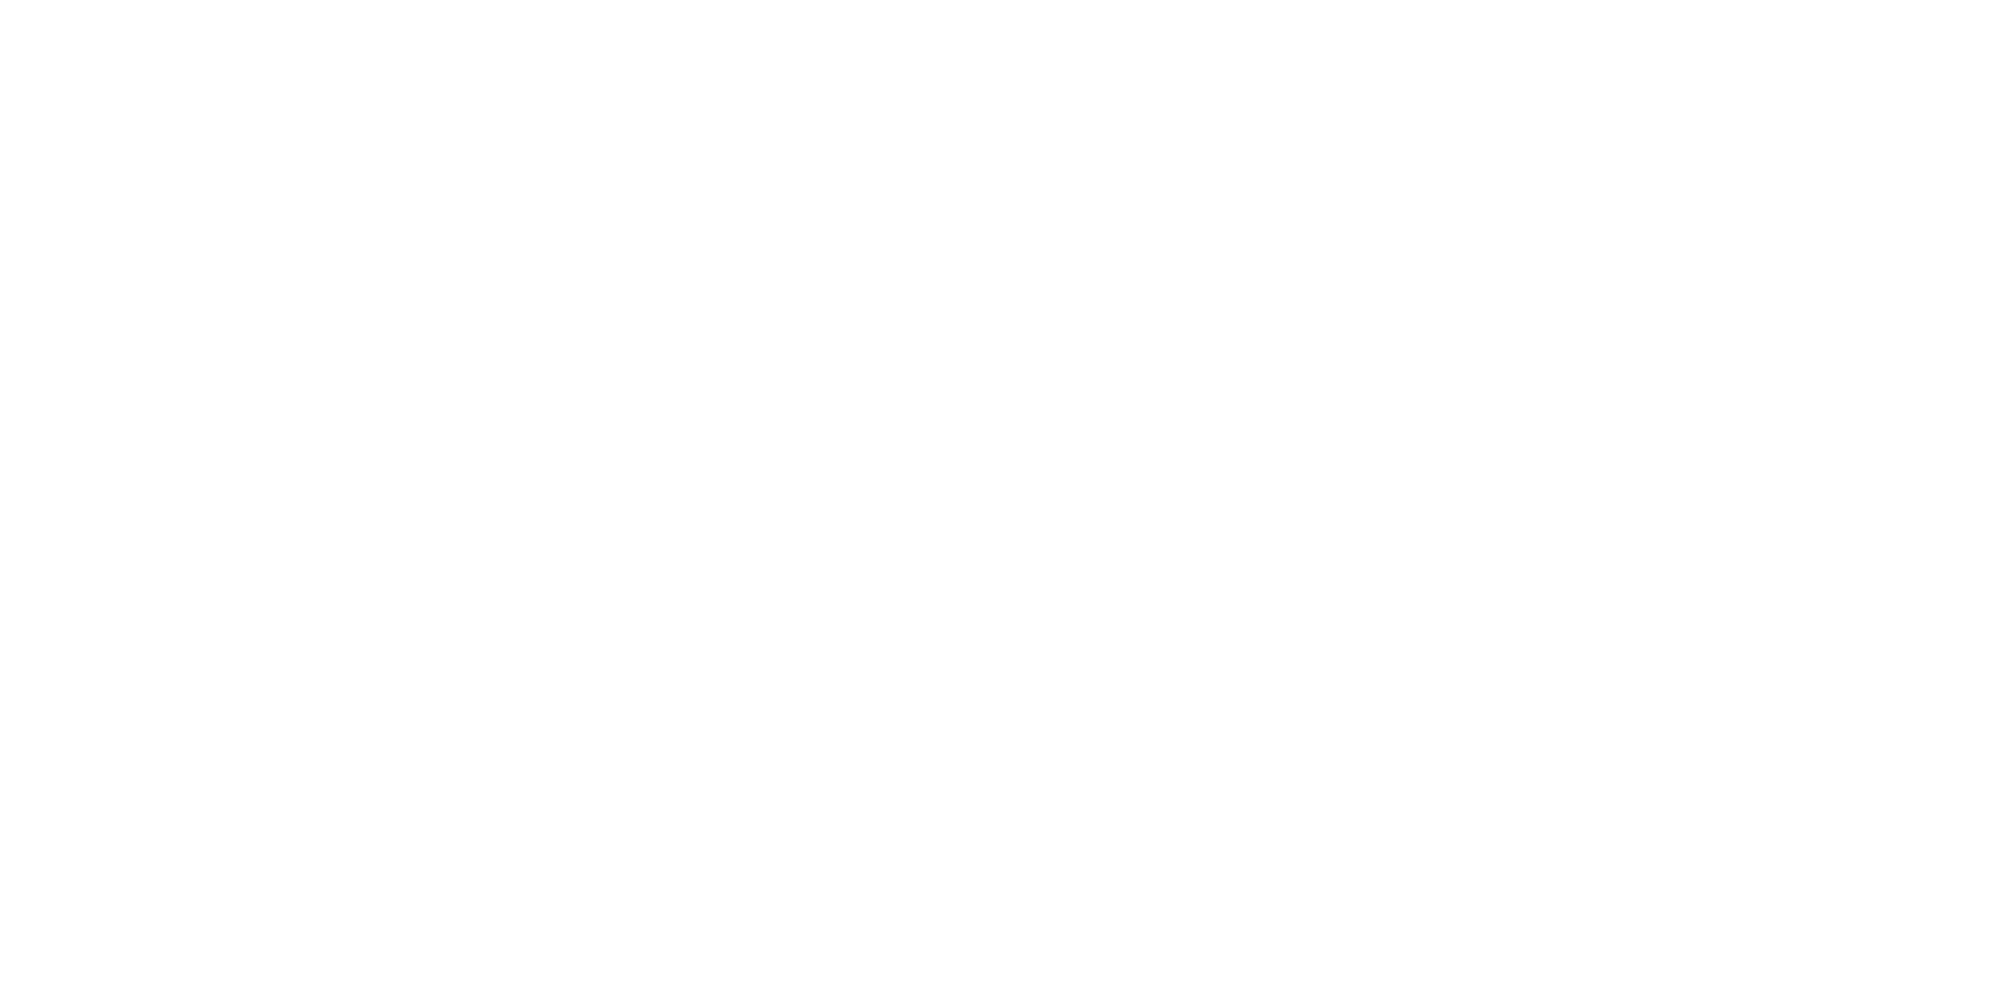

<IPython.core.display.Javascript object>


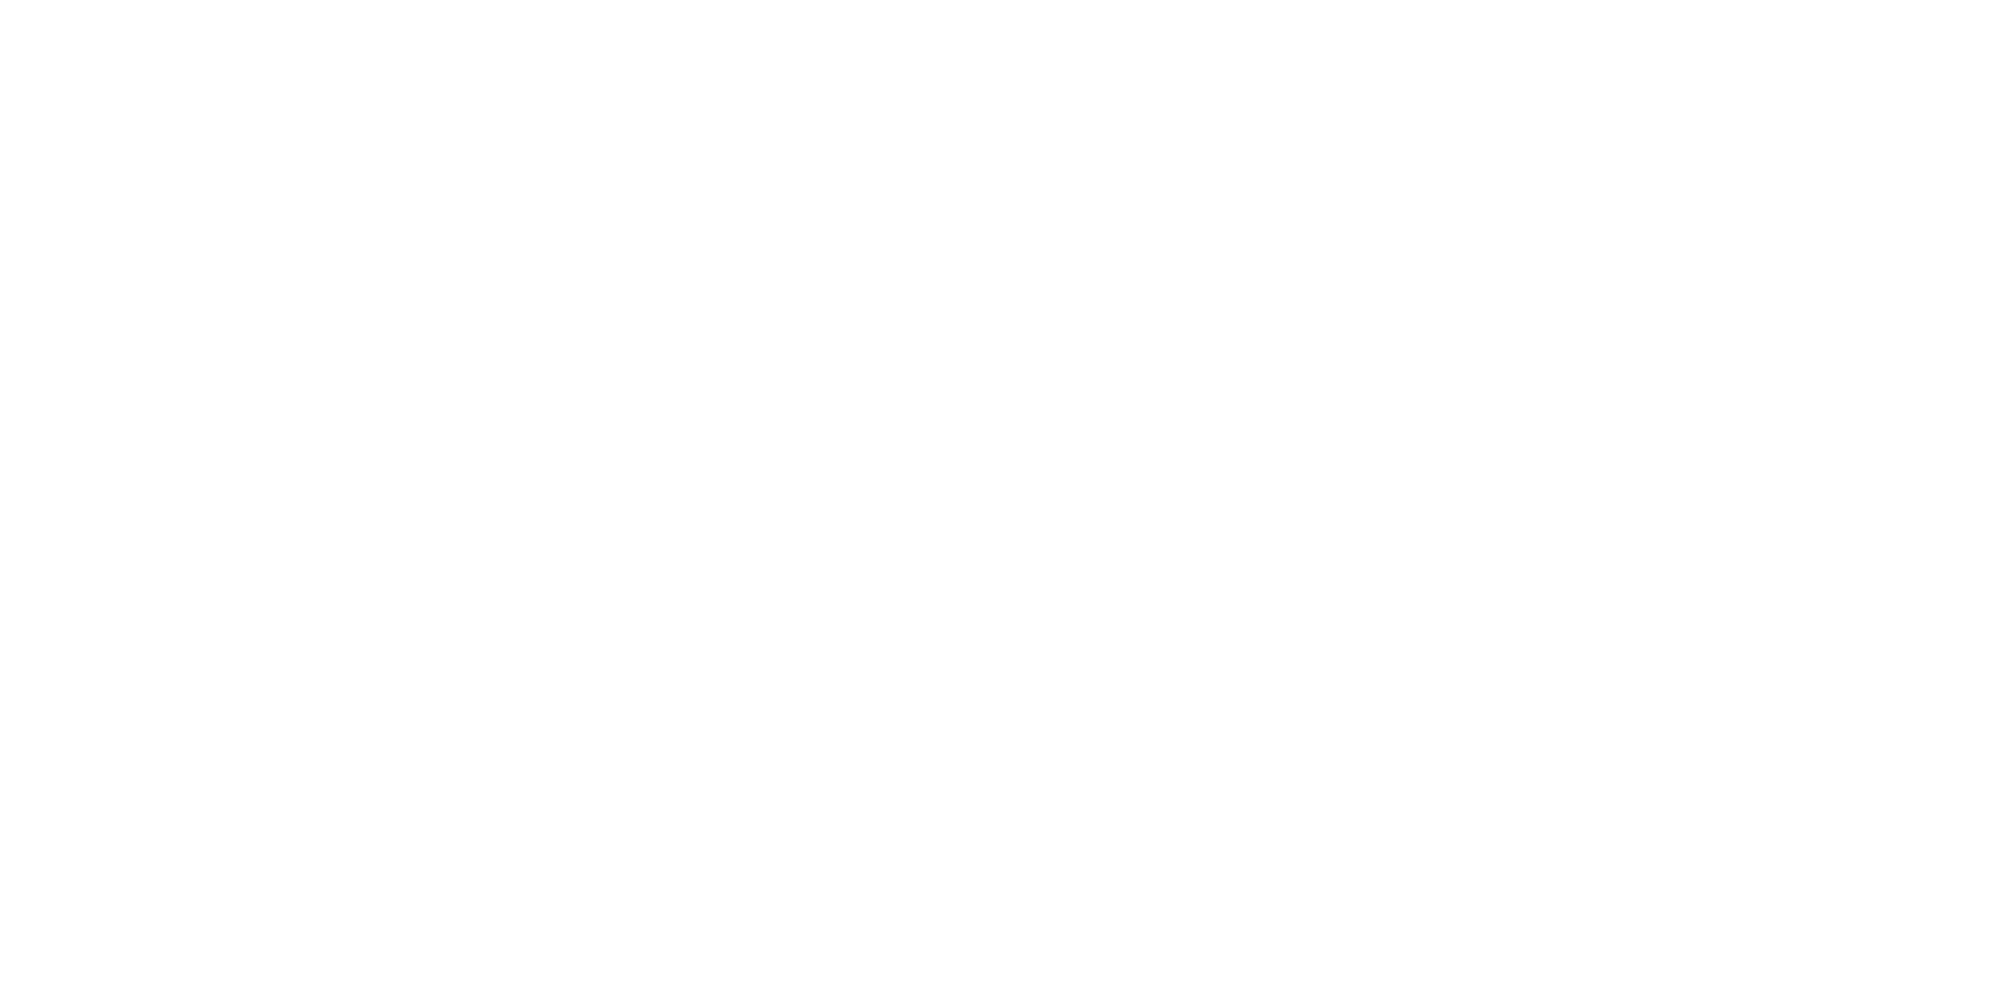

<IPython.core.display.Javascript object>


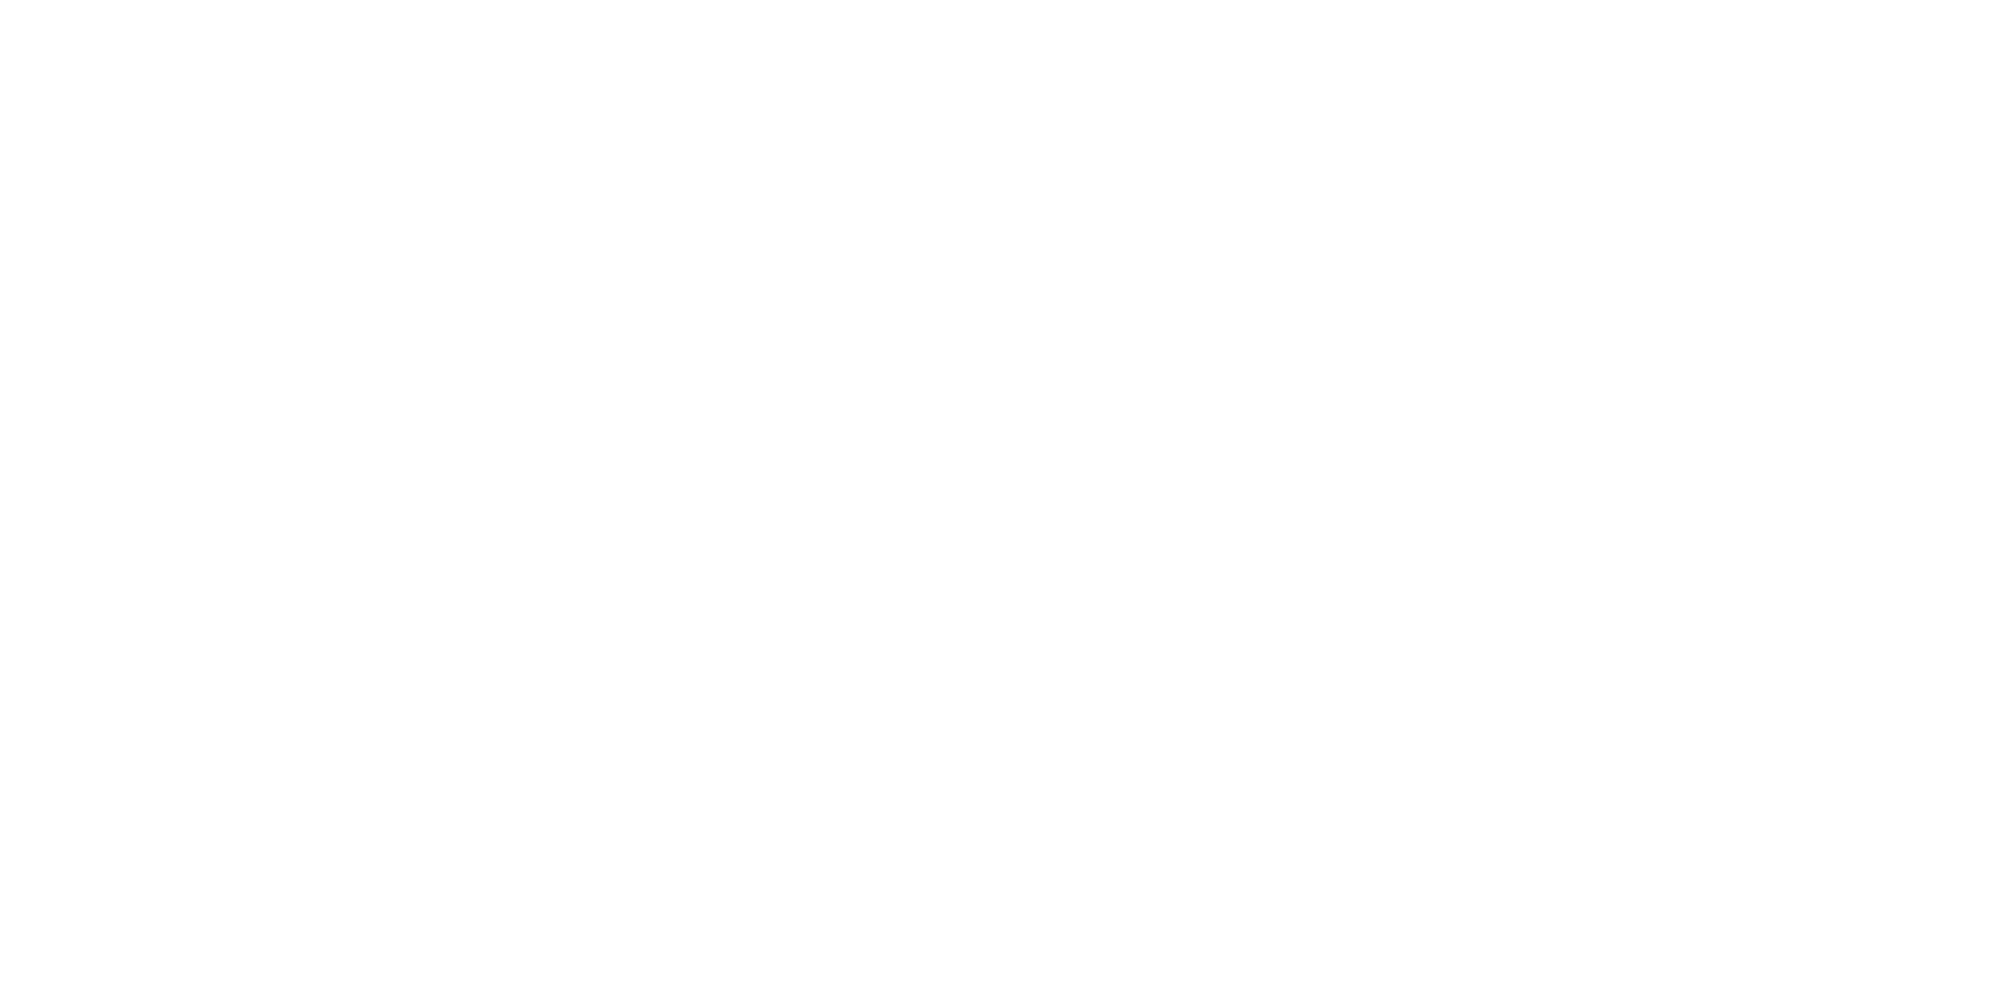

<IPython.core.display.Javascript object>


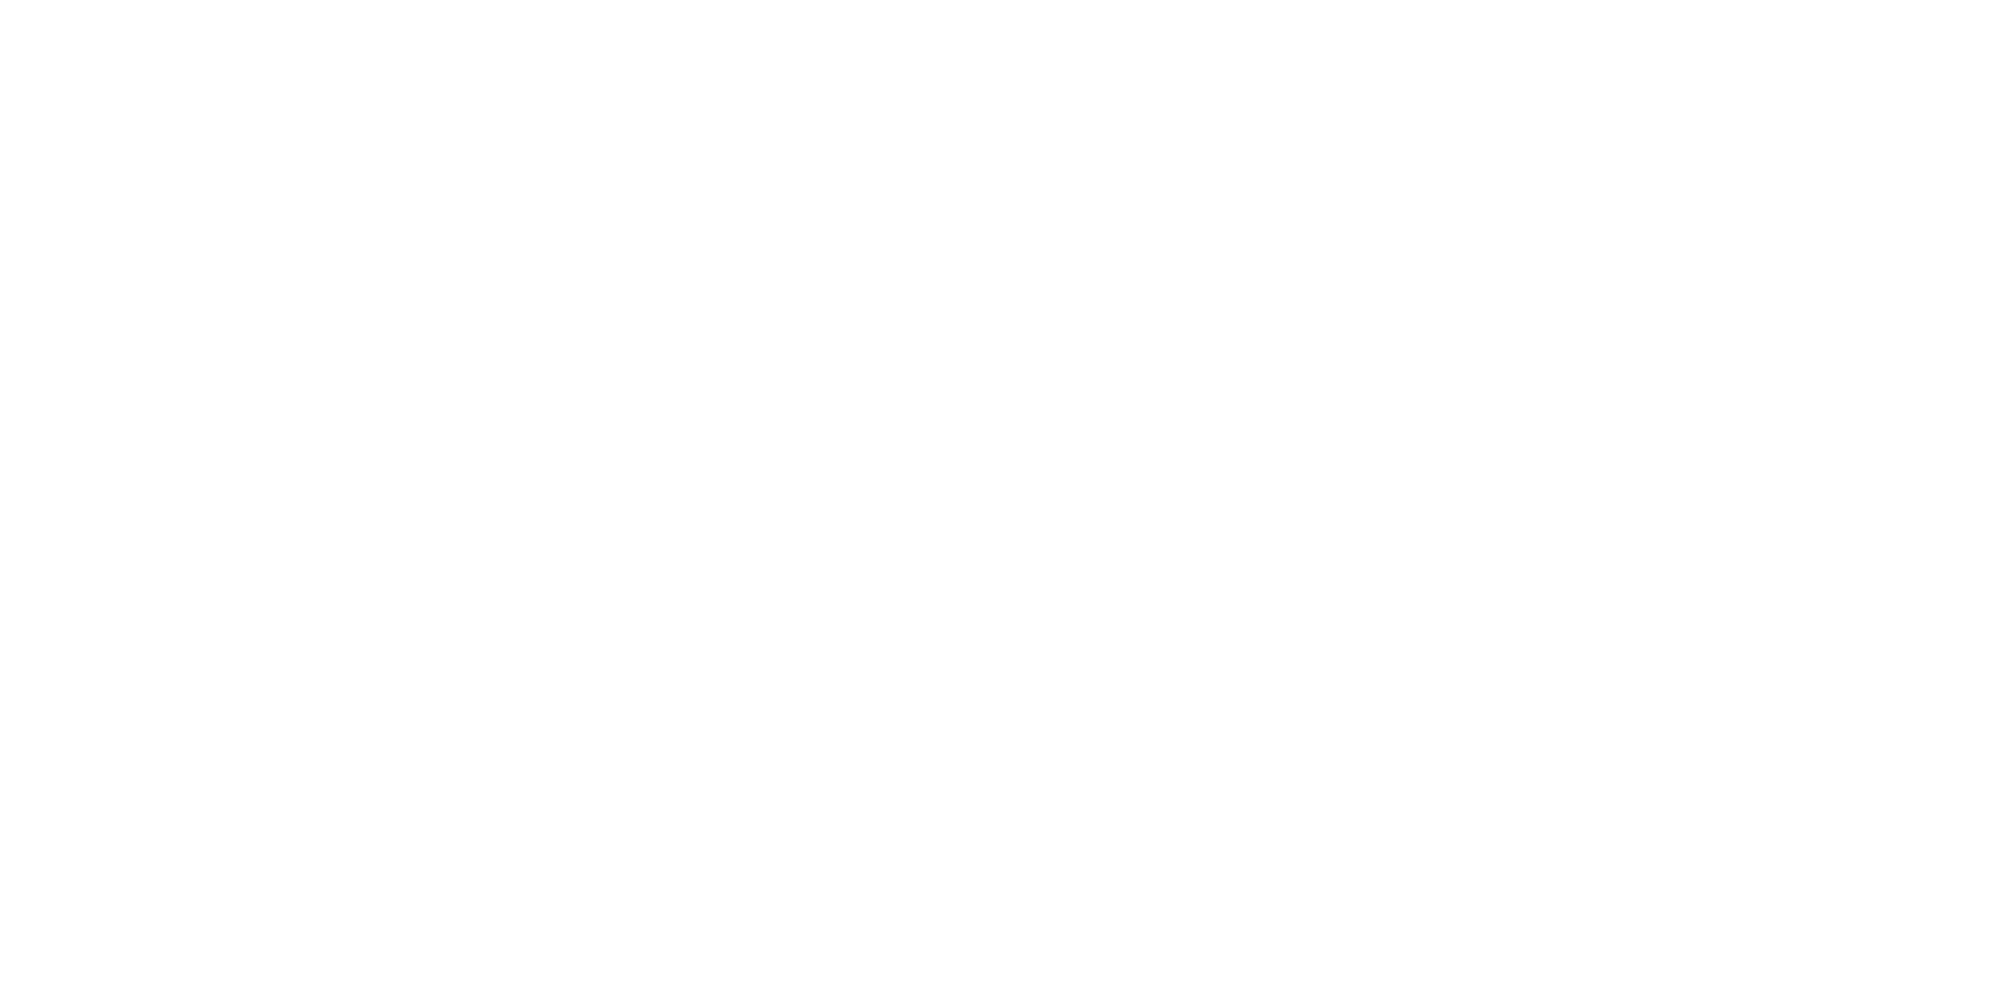

<IPython.core.display.Javascript object>


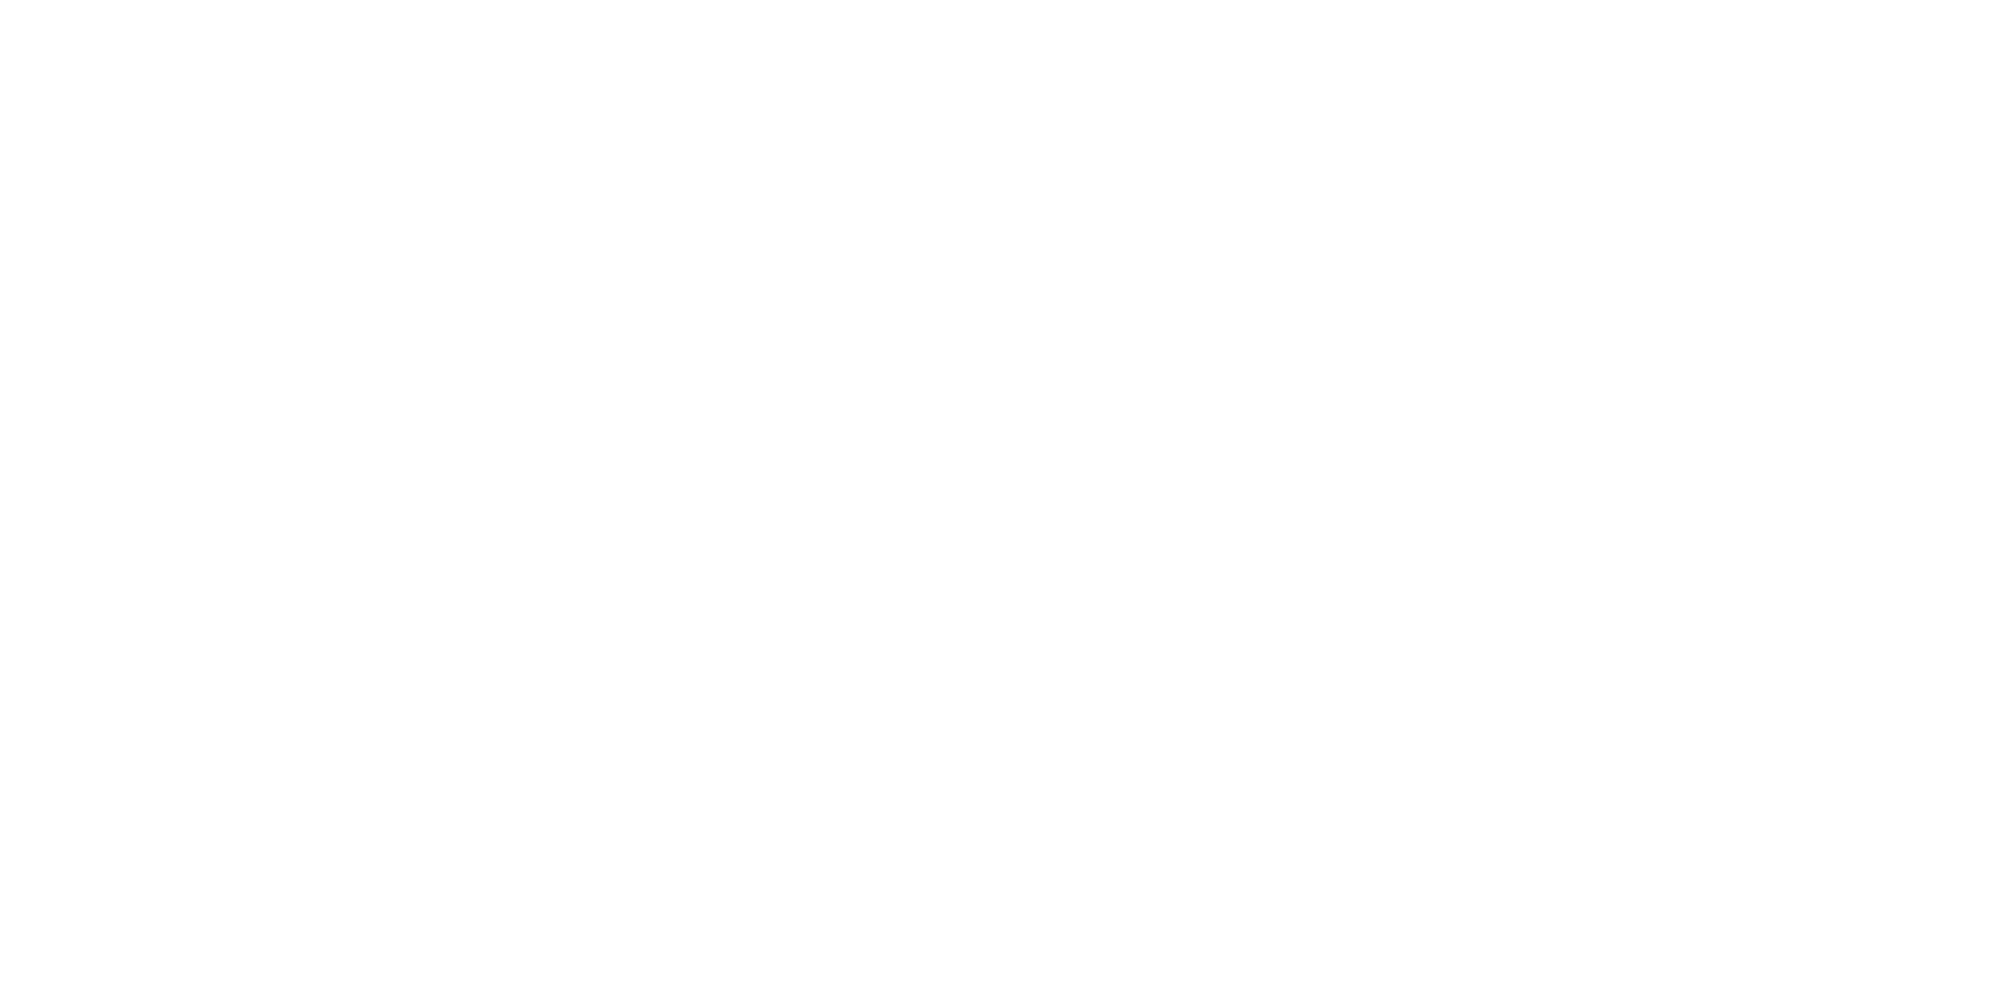

<IPython.core.display.Javascript object>


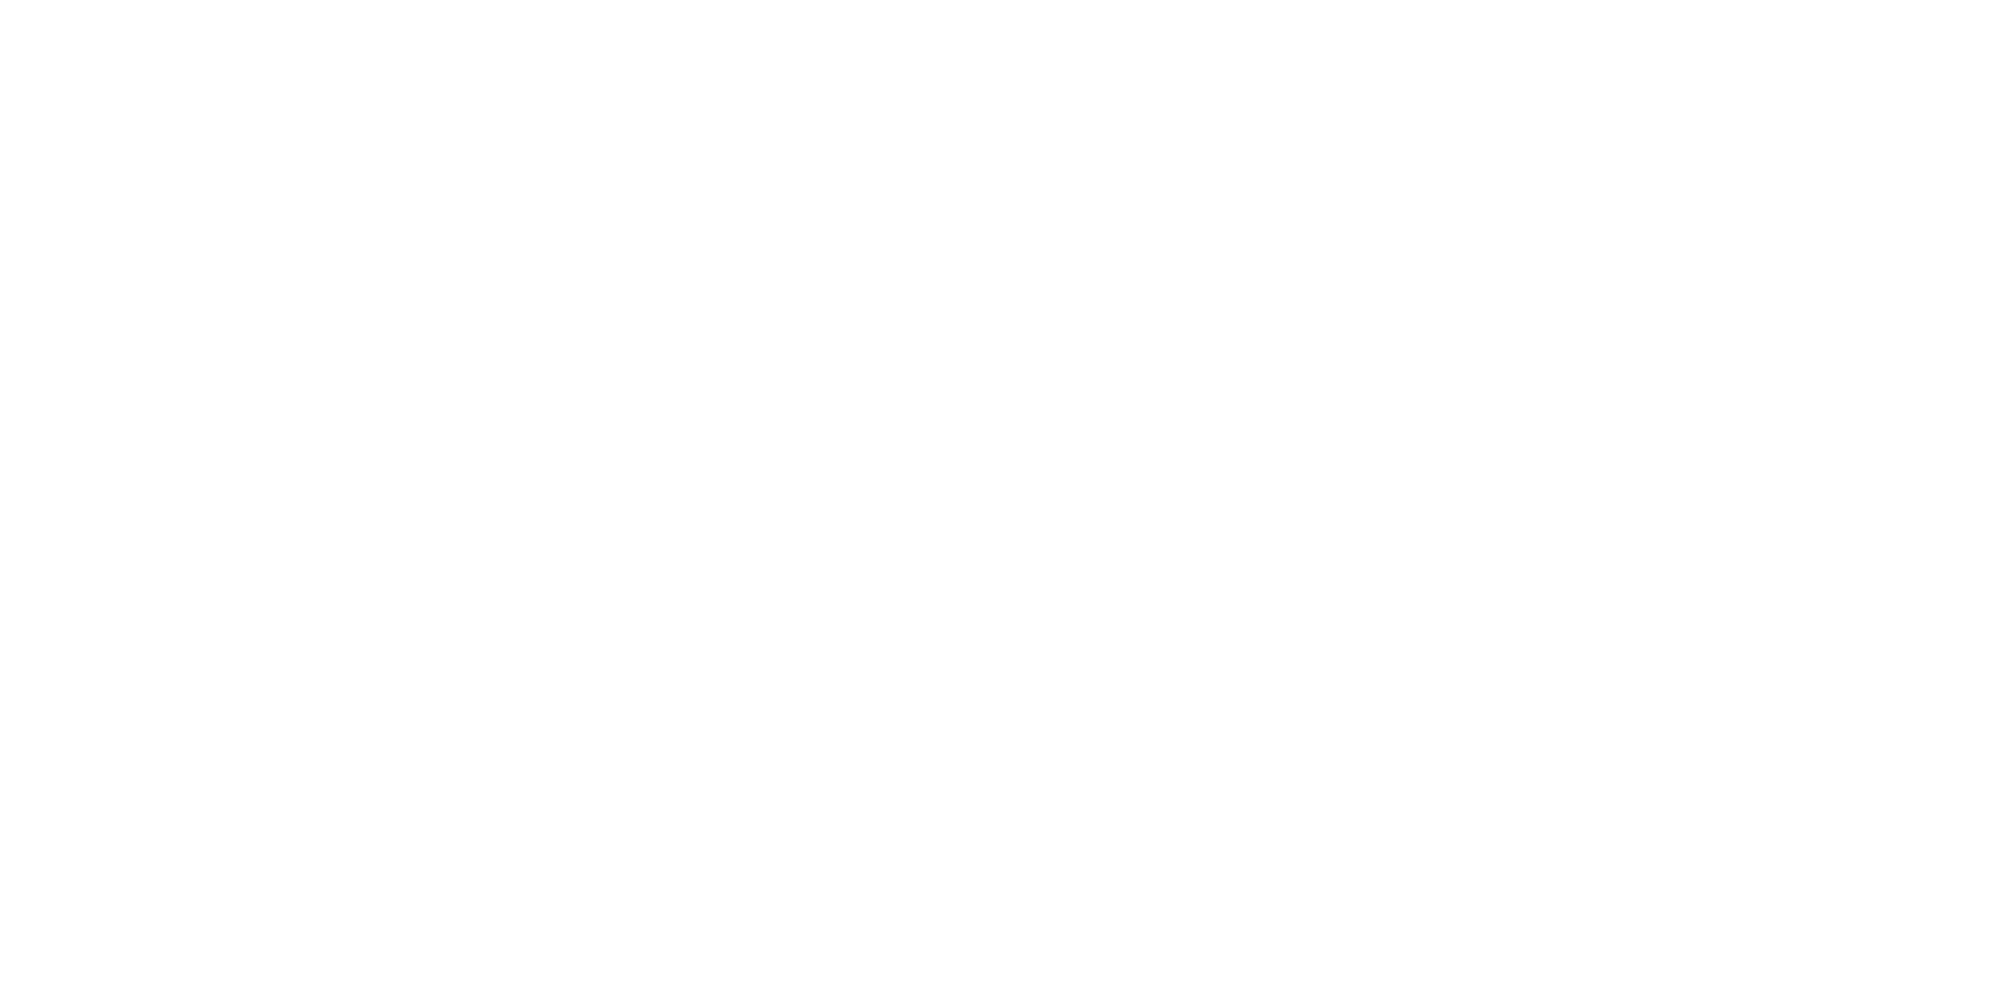

In [126]:
new_order_vec = np.sum(np.abs(data_A), axis = 1) / np.max(np.abs(data_A), axis = 1) / data_A.shape[1]
new_order_vec = np.flip(np.argsort(new_order_vec))
s_imgs = np.array([np.sqrt(np.sum(data_S[:,:,k]**2)) for k in range(data_S.shape[2])])

my_proxM_supergif_name = 'proxMetric_superGIF_test19.gif'
create_superGIF(data_A, s_imgs, dataset, new_order_vec, my_proxM_supergif_name)

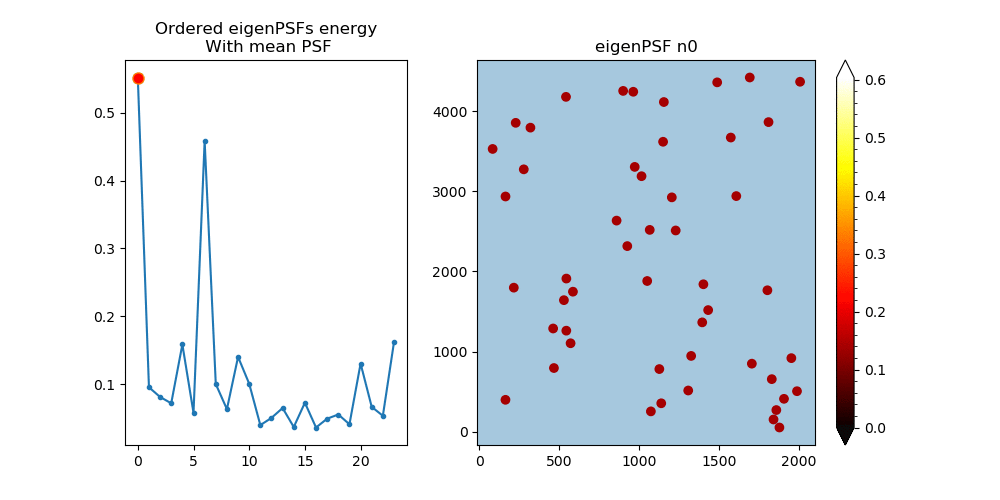

In [127]:
show_gif(my_proxM_supergif_name)

In [ ]:
eigeinPSF = 24

In [106]:
aa = np.random.randn(5,3)*10
bb = np.random.rand(3,3)
print(aa)
print(bb)

[[ -9.97243558  -4.18839596  -3.80897242]
 [ 17.95548929 -10.51615371   1.49841183]
 [  5.5727694   -2.93588156   2.44070789]
 [-12.0097076    7.51426788  -4.95676957]
 [  2.09782178  -3.97000757 -13.33002262]]
[[0.28666729 0.10361721 0.07129227]
 [0.51515619 0.17688643 0.50240514]
 [0.32293452 0.15370105 0.8725337 ]]


In [107]:
np.concatenate((aa,bb),axis=0)

array([[ -9.97243558,  -4.18839596,  -3.80897242],
       [ 17.95548929, -10.51615371,   1.49841183],
       [  5.5727694 ,  -2.93588156,   2.44070789],
       [-12.0097076 ,   7.51426788,  -4.95676957],
       [  2.09782178,  -3.97000757, -13.33002262],
       [  0.28666729,   0.10361721,   0.07129227],
       [  0.51515619,   0.17688643,   0.50240514],
       [  0.32293452,   0.15370105,   0.8725337 ]])